# Data Science Project - Group 10

This notebook implements our Data Science project. The object of our project is to predict the price of a house based on their bedrooms, bathroom, locations and total square feet

# Problem Description

The problem under consideration involves predicting the selling or renting prices of real estate properties in Bengaluru, India, based on various features of the properties. The objective is to develop a machine learning model capable of accurately estimating the prices of houses, which can assist buyers, sellers, and real estate agents in making informed decisions about real estate transactions.


## Objective:

The primary goal is to create a predictive model that can accurately forecast the selling or renting prices of real estate properties in Bengaluru. This model will be a valuable asset for individuals and organizations involved in the real estate industry, enabling them to assess property values and make informed decisions regarding buying, selling, or renting properties in the region.


# Data Description

The dataset contains information about real estate properties in Bengaluru, India. It includes various attributes that describe different aspects of the properties. Below is a description of each attribute: 

- **area_type**: Describes the type of area of the property (e.g., Super Built-up Area, Built-up Area, Plot Area, Carpet Area).
- **availability**: Indicates the availability of the property for sale or rent (e.g., Ready To Move, Immediate Possession, Under Construction).
- **location**: Refers to the location of the property in Bengaluru, India.
- **size**: Indicates the size of the property, usually represented by the number of bedrooms.
- **society**: Represents the society or residential complex to which the property belongs.
- **total_sqft**: The total area of the property in square feet.
- **bath**: Number of bathrooms in the property.
- **balcony**: Number of balconies in the property.
- **price**: The price of the property for sale or rent in Indian Rupees (INR).

Link to dataset:
- https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

# <font color="red">Important</font>

### If you want to run all the notebook and save the models, you need to update the **models_dir** that is below the imports, if you don't wanna save the models please delete that variable

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.cluster.hierarchy as sch
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, DBSCAN
#from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from itertools import combinations

from scipy.stats import ttest_ind, f_oneway, ttest_rel
from scipy.cluster.hierarchy import dendrogram, linkage

import umap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from minisom import MiniSom

from collections import Counter

import pickle
import json
import os
import shutil
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

In [2]:
#models_dir = "C:/Users/vitor_pl48eof/PycharmProjects/Ciencia-Dados-2024-G10_2/Project/Models/"
#os.makedirs(os.path.dirname(models_dir), exist_ok=True)


# For testing purposes
dir_index = 1
models_dir = f"C:/Users/vitor_pl48eof/PycharmProjects/Ciencia-Dados-2024-G10_2/Project/Models{dir_index}/"


while os.path.exists(models_dir):
    dir_index += 1
    models_dir = f"C:/Users/vitor_pl48eof/PycharmProjects/Ciencia-Dados-2024-G10_2/Project/Models{dir_index}/"
    
os.makedirs(os.path.dirname(models_dir), exist_ok=True)
print(models_dir)


C:/Users/vitor_pl48eof/PycharmProjects/Ciencia-Dados-2024-G10_2/Project/Models1/


### Class to load data

In [3]:
class DataLoader:
    """
    Generic Class responsible for loading the dataset and splitting it into training and testing sets.

    Attributes:
        filename (str): The filename of the dataset to load.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int or None): The seed used by the random number generator for reproducibility.

    Attributes (after loading the data):
        data_train (DataFrame): The training data features.
        labels_train (Series): The training data labels.
        data_test (DataFrame): The testing data features.
        labels_test (Series): The testing data labels.

    Methods:
        _load_data(): Loads the dataset, splits it into training and testing sets,
                      and assigns the data and labels to the appropriate attributes.
    """

    def __init__(self, filename, test_size=0.2, random_state=None):
        """
        Initializes the DataLoader with the filename of the dataset, 
        the proportion of data to include in the test split, 
        and the random state for reproducibility.
        """
        self.filename = filename
        self.test_size = test_size
        self.random_state = random_state
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

        # Load data
        self._load_data()

    def _load_data(self):
        """
        Loads the dataset from the specified filename, 
        splits it into training and testing sets using train_test_split(),
        and assigns the data and labels to the appropriate attributes.
        """
        try:
            # Load the dataset
            df = pd.read_csv(self.filename)
            
            # Split the data into features and labels
            X = df
            y = df['price']
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
            
            # Assign the data and labels to attributes
            self.data_train = X_train
            self.labels_train = y_train
            self.data_test = X_test
            self.labels_test = y_test
            
            print("Data loaded successfully.")
            
        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [4]:
data_loader = DataLoader("bengaluru_house_prices.csv")

# Access the data and labels attributes
print("Training data shape:", data_loader.data_train.shape)
print("Training labels shape:", data_loader.labels_train.shape)
print("Testing data shape:", data_loader.data_test.shape)
print("Testing labels shape:", data_loader.labels_test.shape)

Data loaded successfully.
Training data shape: (10656, 9)
Training labels shape: (10656,)
Testing data shape: (2664, 9)
Testing labels shape: (2664,)


### Class to clean the data

In [5]:
class CleanData:
    """
    A class to clean and pre-process the data
    """

    def __init__(self, data_loader):
        """
        Initializes the CleanData object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove unnecessary columns from both data_train and data_test
        self.data_train = self.data_train.drop(columns=['area_type', 'society', 'availability'])
        self.data_test = self.data_test.drop(columns=['area_type', 'society', 'availability'])
        
        # Simplify 'size' column to create 'rooms' column for both train and test data
        self.data_train['rooms'] = self.data_train['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else x)
        self.data_train.drop(columns=['size'], inplace=True)
        
        self.data_test['rooms'] = self.data_test['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else x)
        self.data_test.drop(columns=['size'], inplace=True)
        
        # Convert 'total_sqft' values to single values
        self.data_train['total_sqft'] = self.data_train['total_sqft'].apply(self._convert_values)
        self.data_test['total_sqft'] = self.data_test['total_sqft'].apply(self._convert_values)
        
        # Drop rows with NaN values
        self.data_train.dropna(inplace=True)
        self.data_test.dropna(inplace=True)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]

    def _convert_values(self, x):
        '''
        Converts values in 'total_sqft' column to single values

        :param x: Value in 'total_sqft' column
        :return: Converted value
        '''
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        else:
            if 'Sq. Meter' in x:
                numeric_part = x.split('Sq. Meter')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqm_value = float(numeric_value)
                    sqft_value = sqm_value * 10.7639
                    return sqft_value
            elif 'Sq. Yards' in x:
                numeric_part = x.split('Sq. Yards')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value: 
                    sqy_value = float(numeric_value)
                    sqft_value = sqy_value * 9
                    return sqft_value
            else:
                try:
                    return pd.to_numeric(x)
                except ValueError:
                    return None

In [6]:
clean_data = CleanData(data_loader)
clean_data.clean_data()

# Access the data and labels attributes
print("Training data shape:", clean_data.data_train.shape)
print("Training labels shape:", clean_data.labels_train.shape)
print("Testing data shape:", clean_data.data_test.shape)
print("Testing labels shape:", clean_data.labels_test.shape)

Training data shape: (10150, 6)
Training labels shape: (10150,)
Testing data shape: (2547, 6)
Testing labels shape: (2547,)


### Class to clean based on locations

In [7]:
class FilterLocations:
    """
    A class to filter the data based on locations
    """

    def __init__(self, data_loader):
        """
        Initializes the FilterLocations object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        
        # Filter locations with less than 10 rows of data
        self.data_train = self._filter_locations(self.data_train)
        self.data_test = self._filter_locations(self.data_test)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]
        
        
    def _filter_locations(self, df):
        '''
        Filters locations with less than 10 rows of data

        :param df: DataFrame containing the data
        :return: DataFrame with filtered locations
        '''
        location_counts = df.groupby('location').size()
        valid_locations = location_counts[location_counts >= 10].index.tolist()
        filtered_df = df[df['location'].isin(valid_locations)]
        
        # Print out the filtered indices
        print("Filtered indices:", filtered_df.index)
        
        return filtered_df

In [8]:
filter_locations = FilterLocations(clean_data)
filter_locations.clean_data()

# Access the data and labels attributes
print("Training data shape:", filter_locations.data_train.shape)
print("Training labels shape:", filter_locations.labels_train.shape)
print("Testing data shape:", filter_locations.data_test.shape)
print("Testing labels shape:", filter_locations.labels_test.shape)

Filtered indices: Index([ 2951, 11698,  3091,  6117, 13032,  5842, 13040,  8900,  3698, 11363,
       ...
        7124, 12988,  5694,  1968, 10203,   876, 11299,  9484,  3264, 10317],
      dtype='int64', length=7793)
Filtered indices: Index([12803,  7424,  2905, 10523,  8676,  6185,  1347,  9432,  2080, 13257,
       ...
         513,  9655,  6897,  9471, 10254, 12850, 10898,  7830, 11834, 11040],
      dtype='int64', length=1253)
Training data shape: (7793, 6)
Training labels shape: (7793,)
Testing data shape: (1253, 6)
Testing labels shape: (1253,)


### Class to remove outliers based on Price per Square Feat

In [9]:
class RemovePriceBySquareFeatOutliers:
    """
    A class to remove the outliers based on price per square feat
    """

    def __init__(self, data_loader):
        """
        Initializes the RemovePriceBySquareFeatOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Calculate price per sqft
        self.data_loader.data_train['price_per_sqft'] = self.data_loader.data_train['price'] / self.data_train['total_sqft']
        self.data_loader.data_test['price_per_sqft'] = self.data_loader.data_test['price'] / self.data_test['total_sqft']
        
        # Remove outliers
        self.data_train = self._remove_outliers(self.data_train)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        
    def _remove_outliers(self, df):
        '''
        Removes outliers from the dataset

        :param df: DataFrame containing the data
        :return: DataFrame with outliers removed
        '''
        # Assuming outlier removal based on sqft per bedroom
        return df[~(df['total_sqft'] / df['rooms'] < 300)]  

In [10]:
remove_price_by_square_feat = RemovePriceBySquareFeatOutliers(filter_locations)
remove_price_by_square_feat.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_price_by_square_feat.data_train.shape)
print("Training labels shape:", remove_price_by_square_feat.labels_train.shape)
print("Testing data shape:", remove_price_by_square_feat.data_test.shape)
print("Testing labels shape:", remove_price_by_square_feat.labels_test.shape)

Training data shape: (7513, 7)
Training labels shape: (7513,)
Testing data shape: (1253, 7)
Testing labels shape: (1253,)


### Class to remove outliers based on Locations Price

In [11]:
class RemovePriceLocationsOutliers:
    """
    A class to remove outliers based on location using mean and one standard deviation
    """

    def __init__(self, data_loader):
        """
        Initializes the RemoveLocationBasedOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove outliers based on location
        self._remove_prices_outliers()
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        
    def _remove_prices_outliers(self):
        '''
        Remove outliers per location using mean and one standard deviation
        '''
        for key, subdf in self.data_train.groupby('location'):
            m = np.mean(subdf.price_per_sqft)
            st = np.std(subdf.price_per_sqft)
            self.data_train = self.data_train.drop(subdf[(subdf.price_per_sqft < (m - st)) | (subdf.price_per_sqft > (m + st))].index)

In [12]:
remove_price_location = RemovePriceLocationsOutliers(remove_price_by_square_feat)
remove_price_location.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_price_location.data_train.shape)
print("Training labels shape:", remove_price_location.labels_train.shape)
print("Testing data shape:", remove_price_location.data_test.shape)
print("Testing labels shape:", remove_price_location.labels_test.shape)

Training data shape: (5888, 7)
Training labels shape: (5888,)
Testing data shape: (1253, 7)
Testing labels shape: (1253,)


### Class to remove outliers based on Bedrooms

In [13]:
class RemoveBedroomsOutliers:
    """
    A class to remove outliers based on bedrooms using mean and one standard deviation
    """

    def __init__(self, data_loader):
        """
        Initializes the RemoveBedroomsOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove outliers based on bedrooms
        self._remove_bedroom_outliers()
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        
    def _remove_bedroom_outliers(self):
        '''
        Removes more outliers based on the price and the number of bedrooms
        We remove the data where 2 bedrooms apartments whose price_per_sqft is less than mean of 1 bedroom apartment
        '''
        exclude_indices = np.array([])
        for location, location_df in self.data_train.groupby('location'):
            room_stats = {}
            for room, room_df in location_df.groupby('rooms'):
                room_stats[room] = {
                    'mean': np.mean(room_df.price_per_sqft),
                    'std': np.std(room_df.price_per_sqft),
                    'count': room_df.shape[0]
                }
            for room, room_df in location_df.groupby('rooms'):
                stats = room_stats.get(room - 1)
                if stats and stats['count'] > 5:
                    exclude_indices = np.append(exclude_indices,
                                                room_df[room_df.price_per_sqft < (stats['mean'])].index.values)
        self.data_train = self.data_train.drop(exclude_indices, axis='index')

In [14]:
remove_bedroom = RemoveBedroomsOutliers(remove_price_location)
remove_bedroom.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_bedroom.data_train.shape)
print("Training labels shape:", remove_bedroom.labels_train.shape)
print("Testing data shape:", remove_bedroom.data_test.shape)
print("Testing labels shape:", remove_bedroom.labels_test.shape)

Training data shape: (4582, 7)
Training labels shape: (4582,)
Testing data shape: (1253, 7)
Testing labels shape: (1253,)


### Remove remaining outliers

In [15]:
class RemoveRemainingOutliers:
    """
    Class for cleaning operations.

    Methods:
        remove_duplicates(): Remove duplicate rows from the dataset.
        handle_missing_values(strategy='mean'): Handle missing values using the specified strategy.
        remove_outliers(threshold=3): Remove outliers from the dataset
    """
    def __init__(self, data_loader):
        """
        Initializes the DataPreprocessing class with a DataLoader object.
        """
        self.data_loader = data_loader
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
    
    def _detect_outliers(self, threshold=4):
        """
        Detect outliers in numerical features using z-score method.
        
        Parameters:
            threshold (float): The threshold value for determining outliers.
        
        Returns:
            outliers (DataFrame): DataFrame containing the outliers.
        """
        try:
            # Check if test data is not None
            if self.data_loader.data_train is None:
                raise ValueError("Data has not been loaded yet.")
            
            # Identify numerical features
            numerical_features = self.data_train.select_dtypes(include=['number'])
            
            # Calculate z-scores for numerical features
            z_scores = (numerical_features - numerical_features.mean()) / numerical_features.std()
            
            # Find outliers based on threshold
            outliers = self.data_train[(z_scores.abs() > threshold).any(axis=1)]
            
            return outliers
        
        except ValueError as ve:
            print("Error:", ve)

    def remove_outliers(self, threshold=2):
        """
        Remove outliers from the dataset using z-score method.
        
        Parameters:
            threshold (float): The threshold value for determining outliers.
        """
        try:
            # Check if data_loader.data is not None
            if self.data_train is None:
                raise ValueError("Data has not been loaded yet.")
            
            # Detect outliers
            outliers = self._detect_outliers(threshold)
            
            # Remove outliers from the dataset
            self.data_train = self.data_train.drop(outliers.index)
            self.labels_train = self.labels_train[self.data_train.index]
            
            print("Outliers removed from the dataset.")
            
        except ValueError as ve:
            print("Error:", ve)

In [16]:
remove_outliers = RemoveRemainingOutliers(remove_bedroom)
remove_outliers.remove_outliers()

# Access the data and labels attributes
print("Training data shape:", remove_outliers.data_train.shape)
print("Training labels shape:", remove_outliers.labels_train.shape)
print("Testing data shape:", remove_outliers.data_test.shape)
print("Testing labels shape:", remove_outliers.labels_test.shape)

Outliers removed from the dataset.
Training data shape: (3926, 7)
Training labels shape: (3926,)
Testing data shape: (1253, 7)
Testing labels shape: (1253,)


In [17]:
remove_more_outliers = FilterLocations(remove_outliers)
remove_more_outliers.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_more_outliers.data_train.shape)
print("Training labels shape:", remove_more_outliers.labels_train.shape)
print("Testing data shape:", remove_more_outliers.data_test.shape)
print("Testing labels shape:", remove_more_outliers.labels_test.shape)

Filtered indices: Index([ 2951,  3091,  5842,  2979, 12141,  8196, 12113,  2962,  4783,  1022,
       ...
       10073,  4682,   705, 12079,  7124,  1968, 10203, 11299,  9484, 10317],
      dtype='int64', length=3374)
Filtered indices: Index([12803,  7424,  2905, 10523,  8676,  6185,  1347,  9432,  2080, 13257,
       ...
         513,  9655,  6897,  9471, 10254, 12850, 10898,  7830, 11834, 11040],
      dtype='int64', length=1253)
Training data shape: (3374, 7)
Training labels shape: (3374,)
Testing data shape: (1253, 7)
Testing labels shape: (1253,)


### Class to visualize data

In [18]:
class VisualizeData:
    '''
    A class to visualize the data of the DataFrame
    '''

    def plot_scatter_chart(self, df, location):
        '''
        Shows the scatter plot of a certain locations based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        matplotlib.rcParams['figure.figsize'] = (15, 10)
        sns.scatterplot(data=room2, x='total_sqft', y='price', color='skyblue', label='2 Rooms', s=50)
        sns.scatterplot(data=room3, x='total_sqft', y='price', color='salmon', marker='p', label='3 Rooms', s=50)
        plt.xlabel("Total Square Feet Area")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(location)
        plt.legend()
        plt.show()
        
    def plot_boxplot(self, df, location):
        '''
        Shows the boxplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.boxplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms', palette='pastel')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Boxplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()
        
    def plot_violinplot(self, df, location):
        '''
        Shows the violinplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.violinplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms', palette='pastel')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Violinplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()

    def plot_histogram(self, df, column, location):
        '''
        Shows the histogram of a certain column in the DataFrame for a specific location
        :param df: DataFrame containing all the data
        :param column: Specific column in the DataFrame
        :param location: Specific location in the DataFrame
        '''
        plt.figure(figsize=(8, 6))
        sns.histplot(df[df['location'] == location][column], kde=True, color='skyblue', linewidth=1)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f'Histogram of {column} in {location}')
        plt.show()
        
    def plot_heatmap(self, df):
        '''
        Shows the heatmap of correlation between columns in the DataFrame
        :param df: DataFrame containing all the data
        '''
        if 'location' in df.columns:
            df = df.drop(columns=['location'])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

In [19]:
# Initialize the VisualizeData object
vd = VisualizeData()

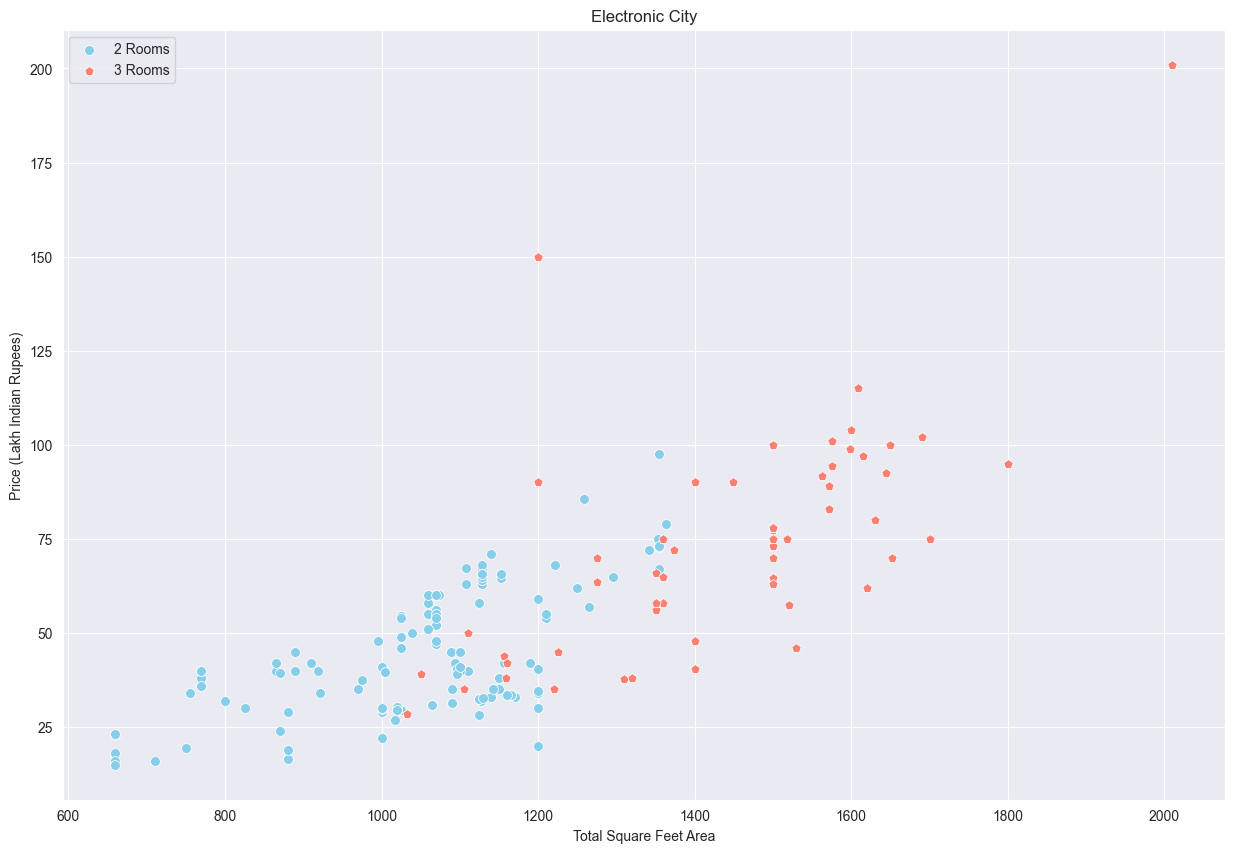

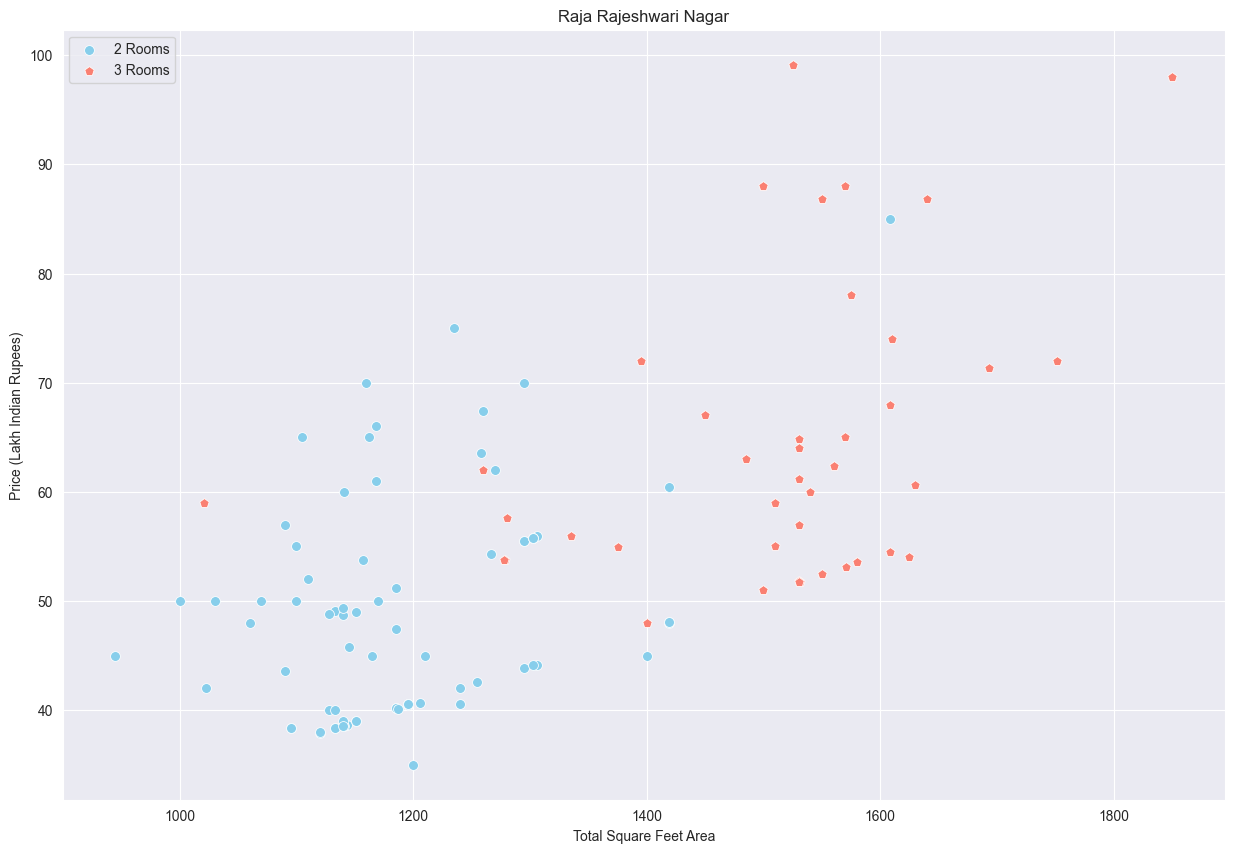

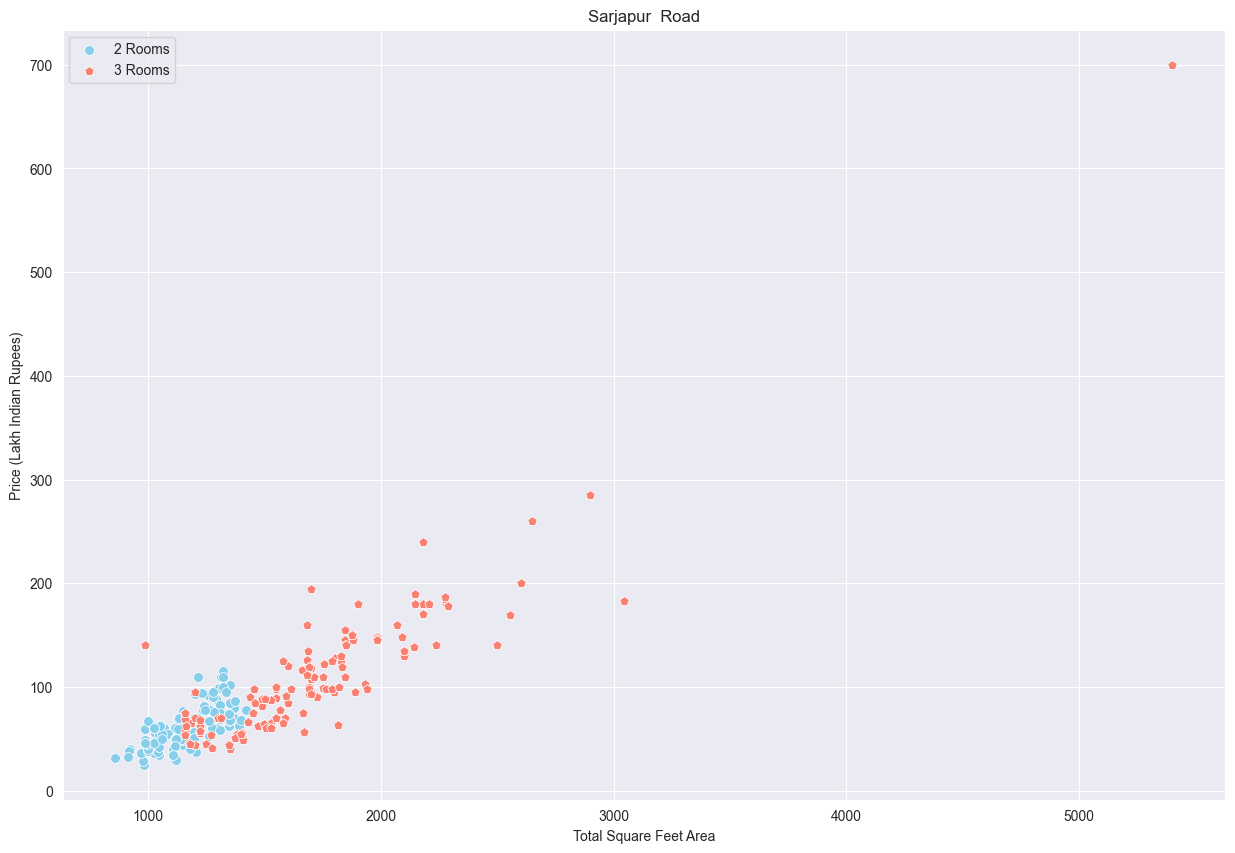

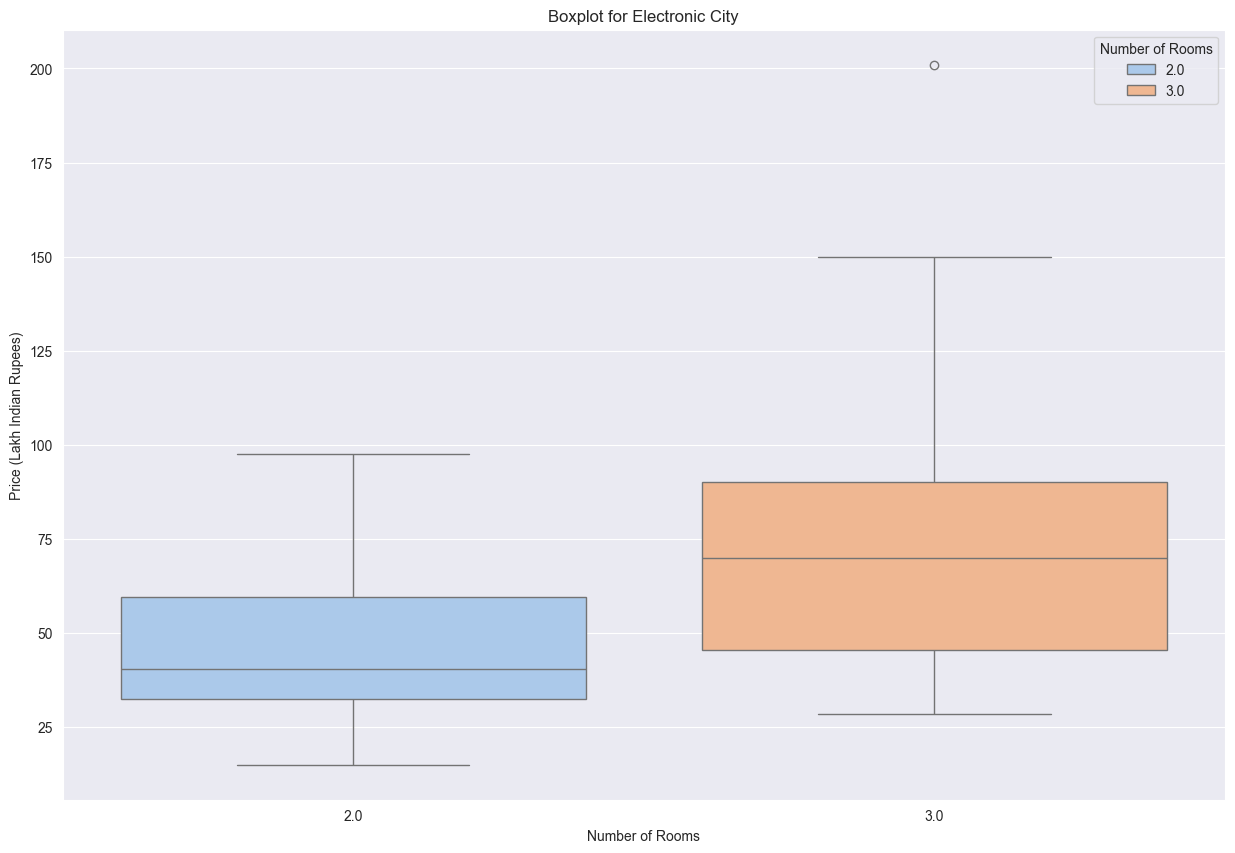

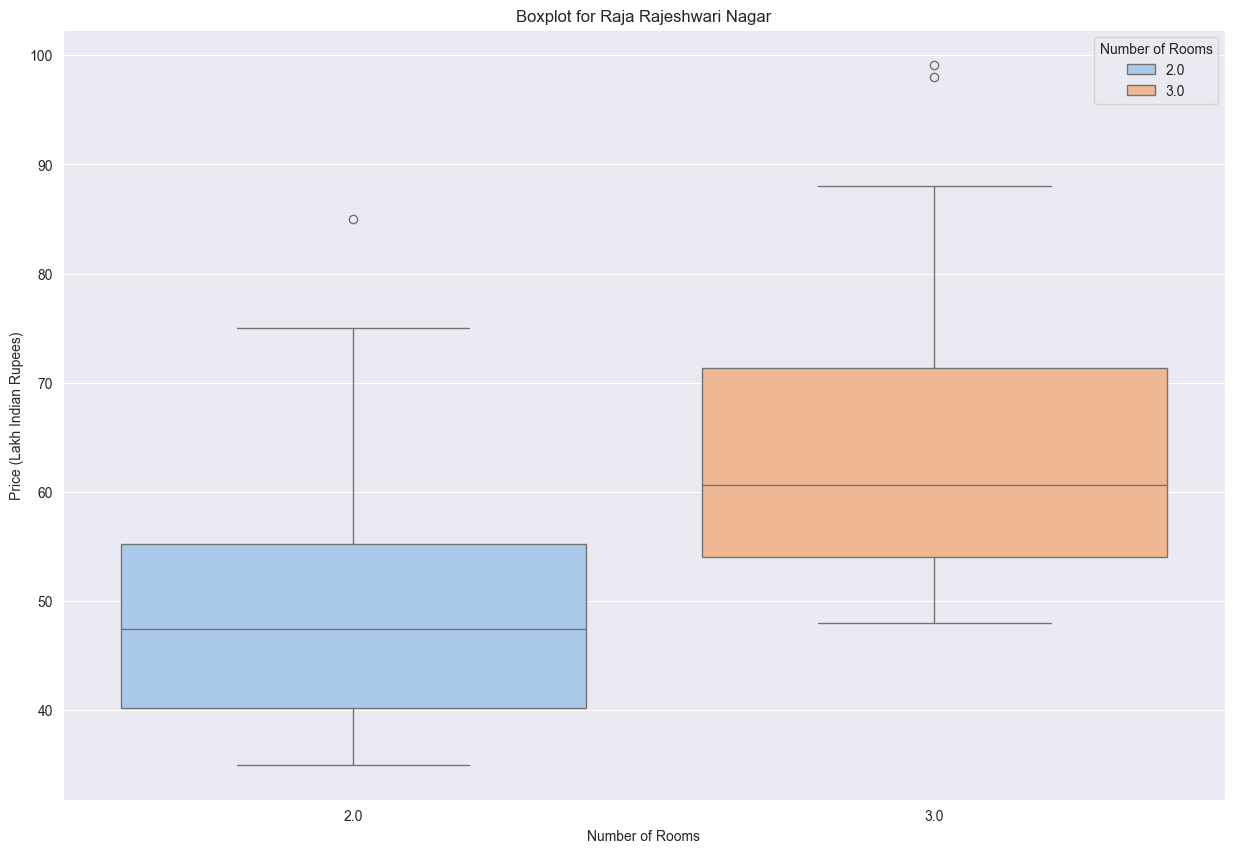

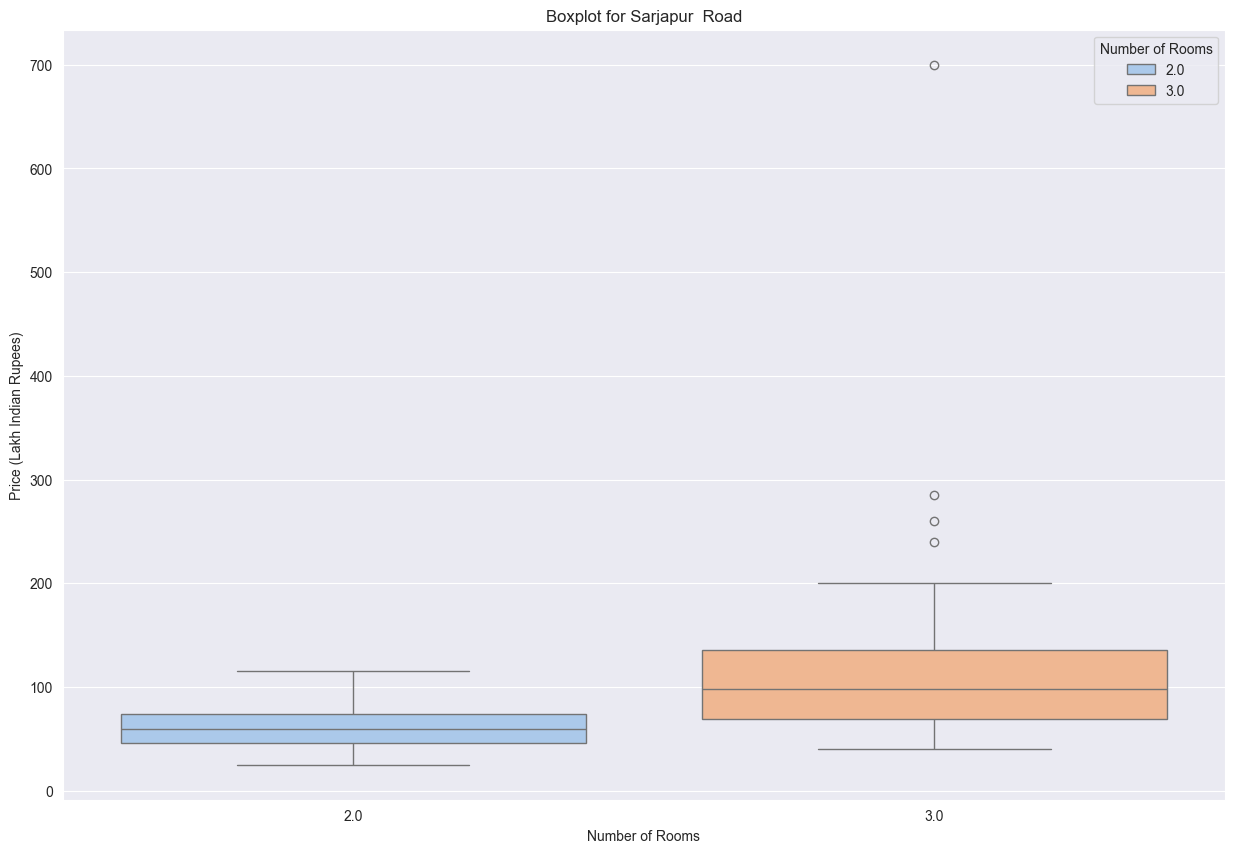

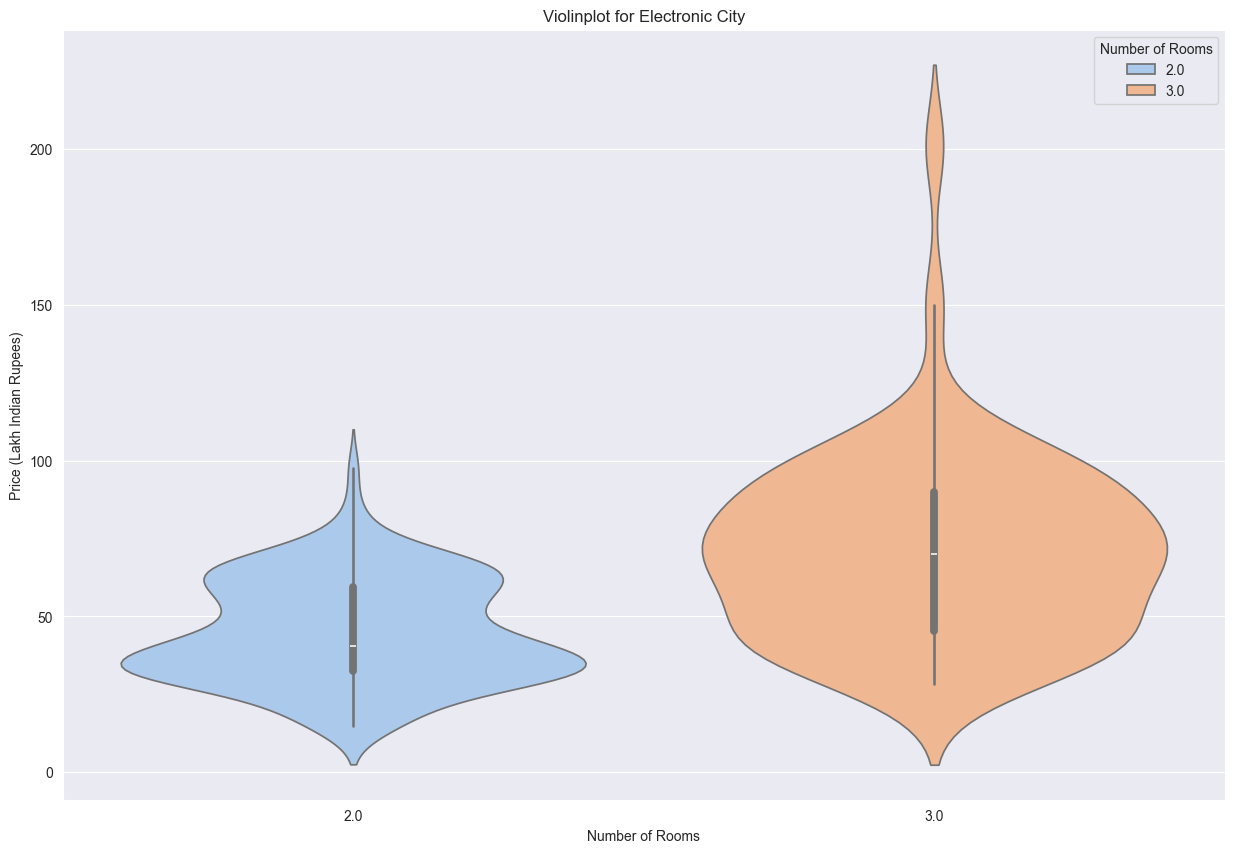

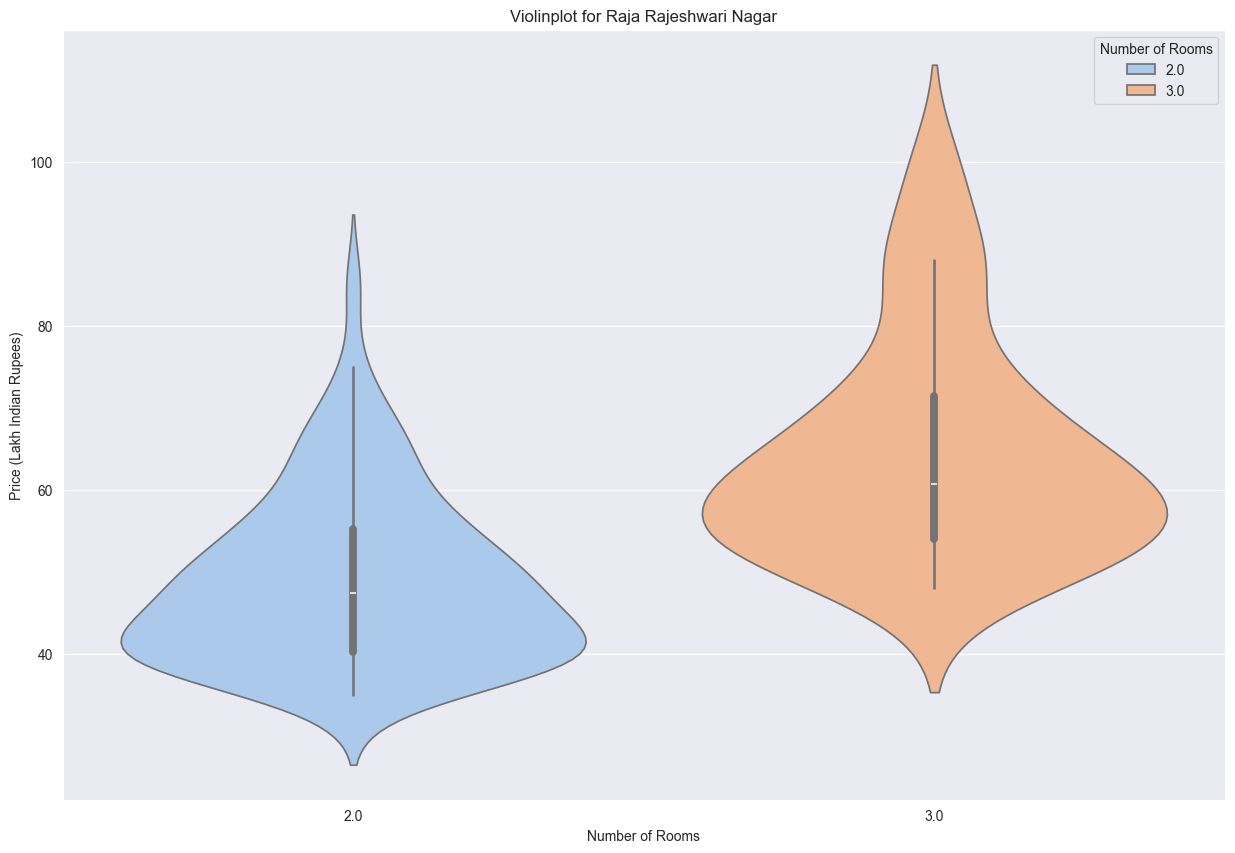

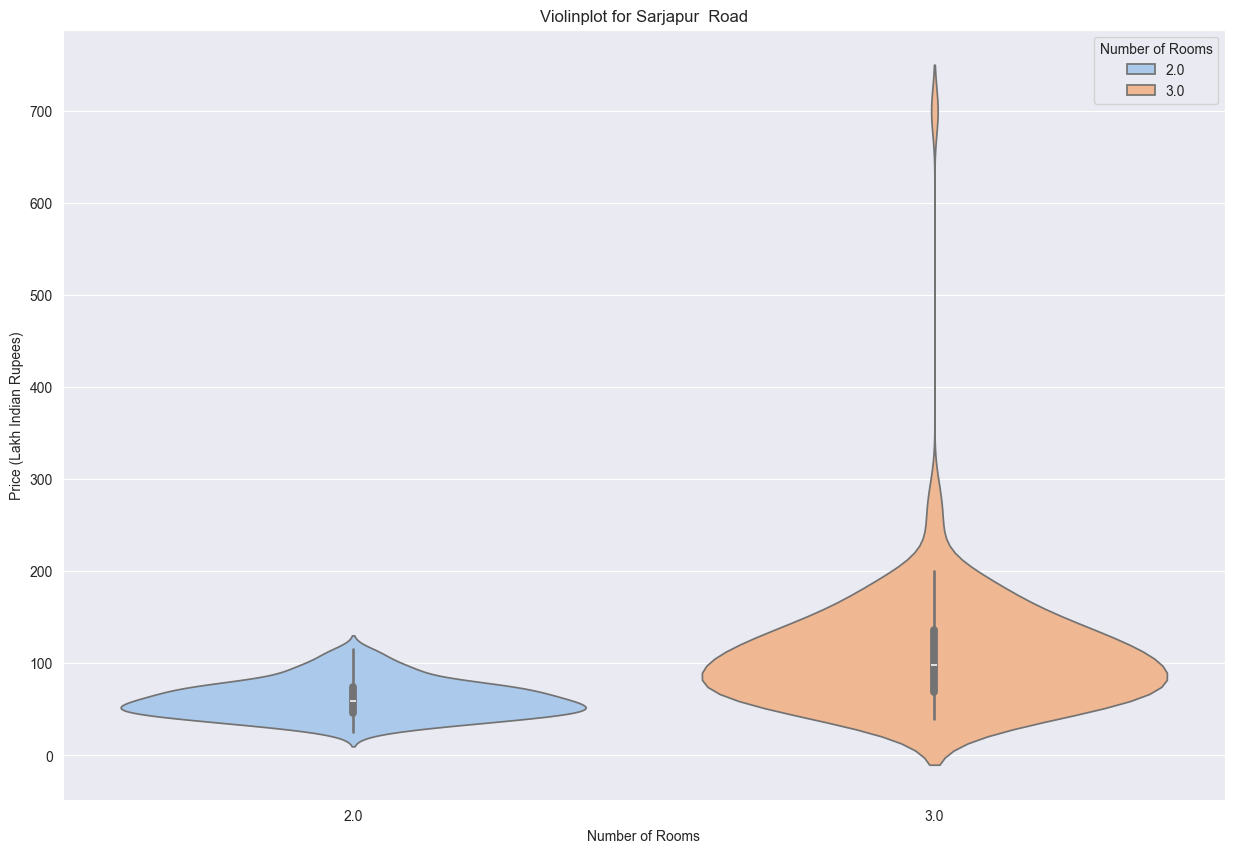

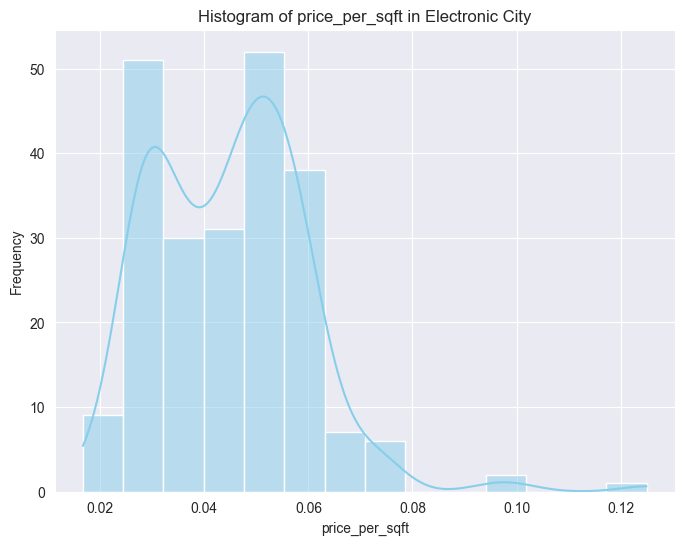

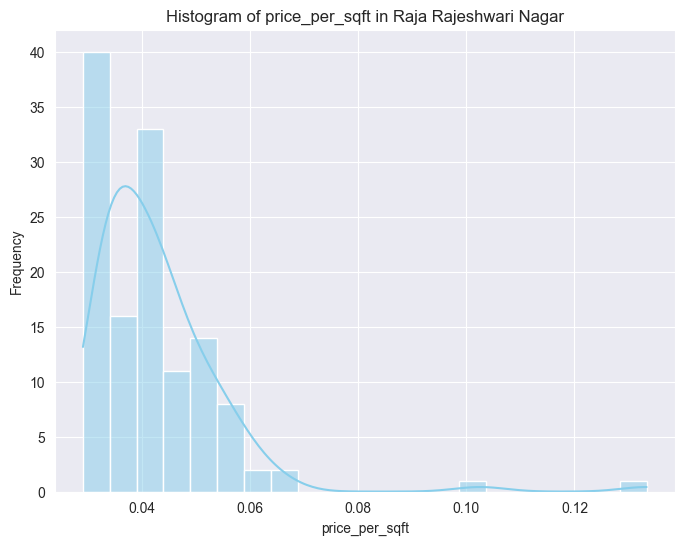

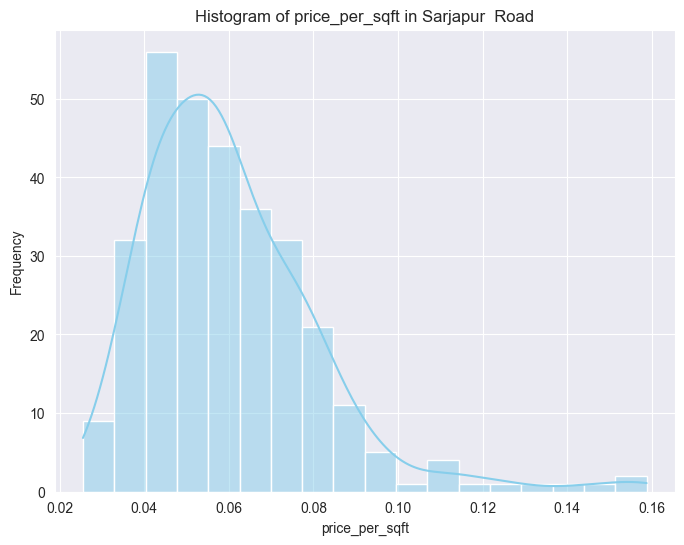

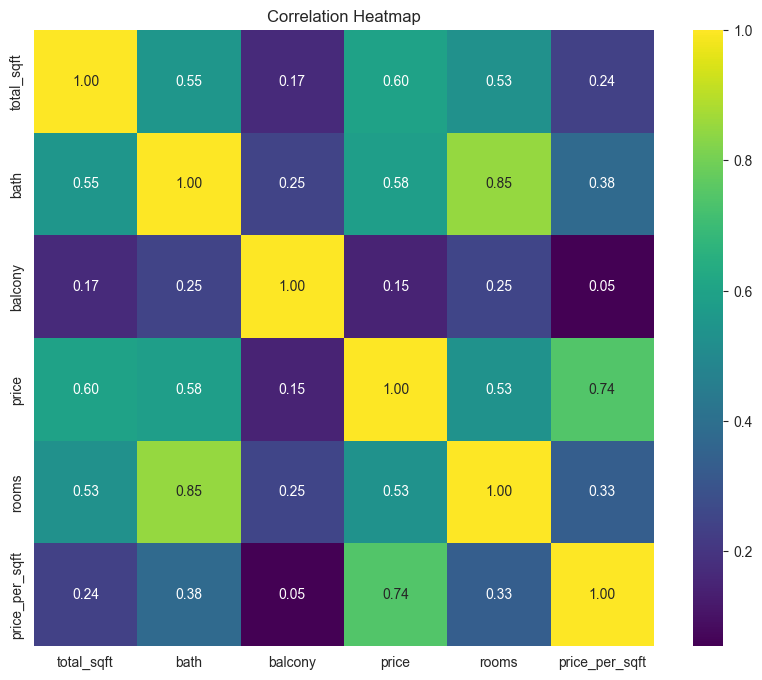

In [20]:
# Show data before outliers in scatter chart
vd.plot_scatter_chart(remove_price_by_square_feat.data_train, "Electronic City")
vd.plot_scatter_chart(remove_price_by_square_feat.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_price_by_square_feat.data_train, "Sarjapur  Road")

# Show data before outliers in box plots
vd.plot_boxplot(remove_price_by_square_feat.data_train, "Electronic City")
vd.plot_boxplot(remove_price_by_square_feat.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_price_by_square_feat.data_train, "Sarjapur  Road")

# Show data before outliers in violins plot
vd.plot_violinplot(remove_price_by_square_feat.data_train, "Electronic City")
vd.plot_violinplot(remove_price_by_square_feat.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_price_by_square_feat.data_train, "Sarjapur  Road")

# Show data before outliers in histograms
vd.plot_histogram(remove_price_by_square_feat.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_price_by_square_feat.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_price_by_square_feat.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_price_by_square_feat.data_train)

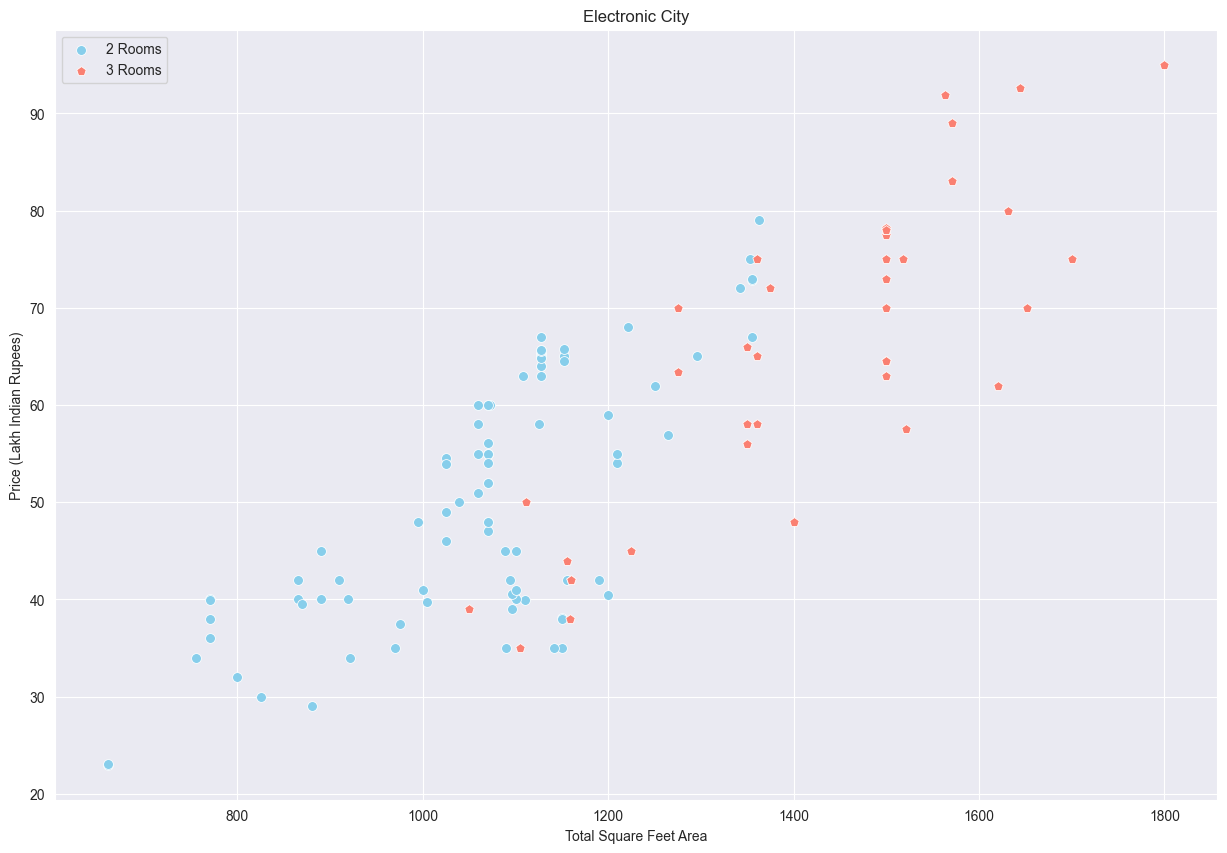

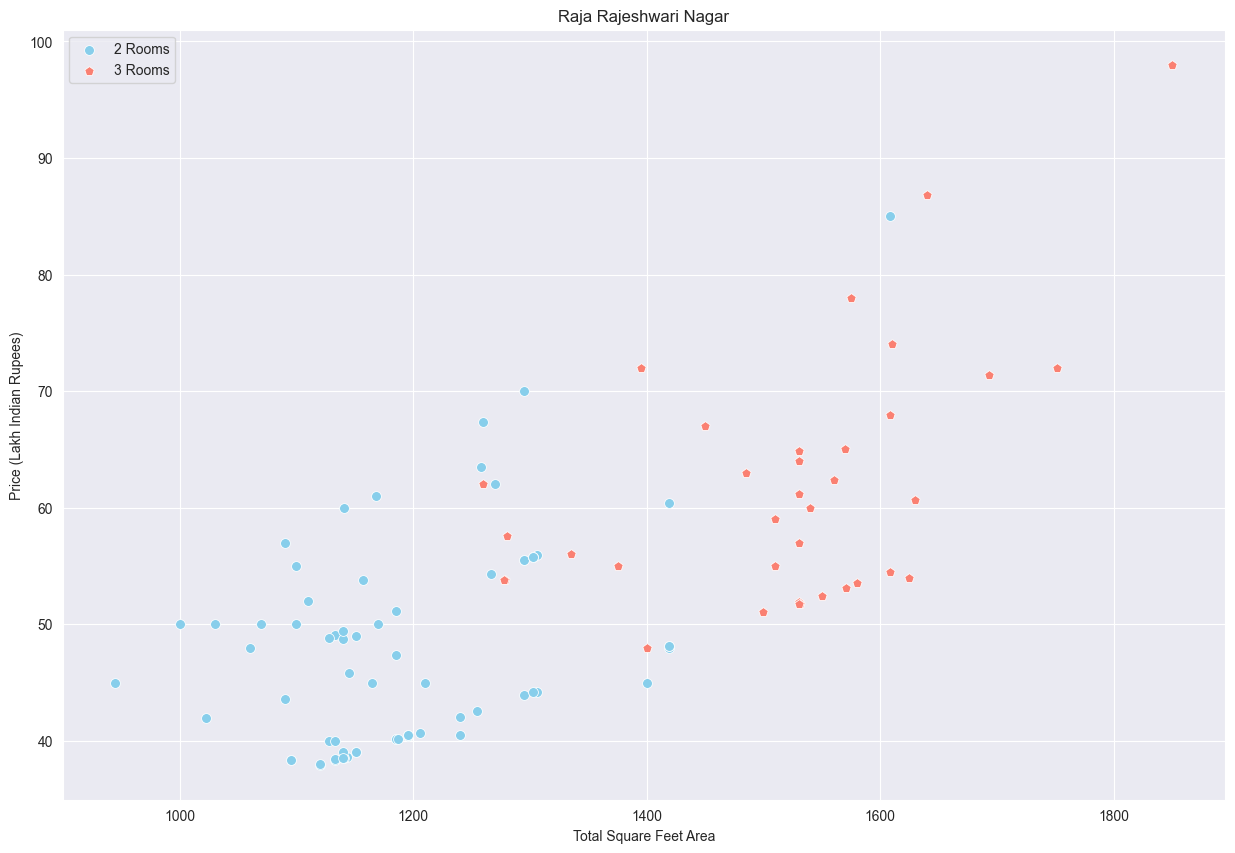

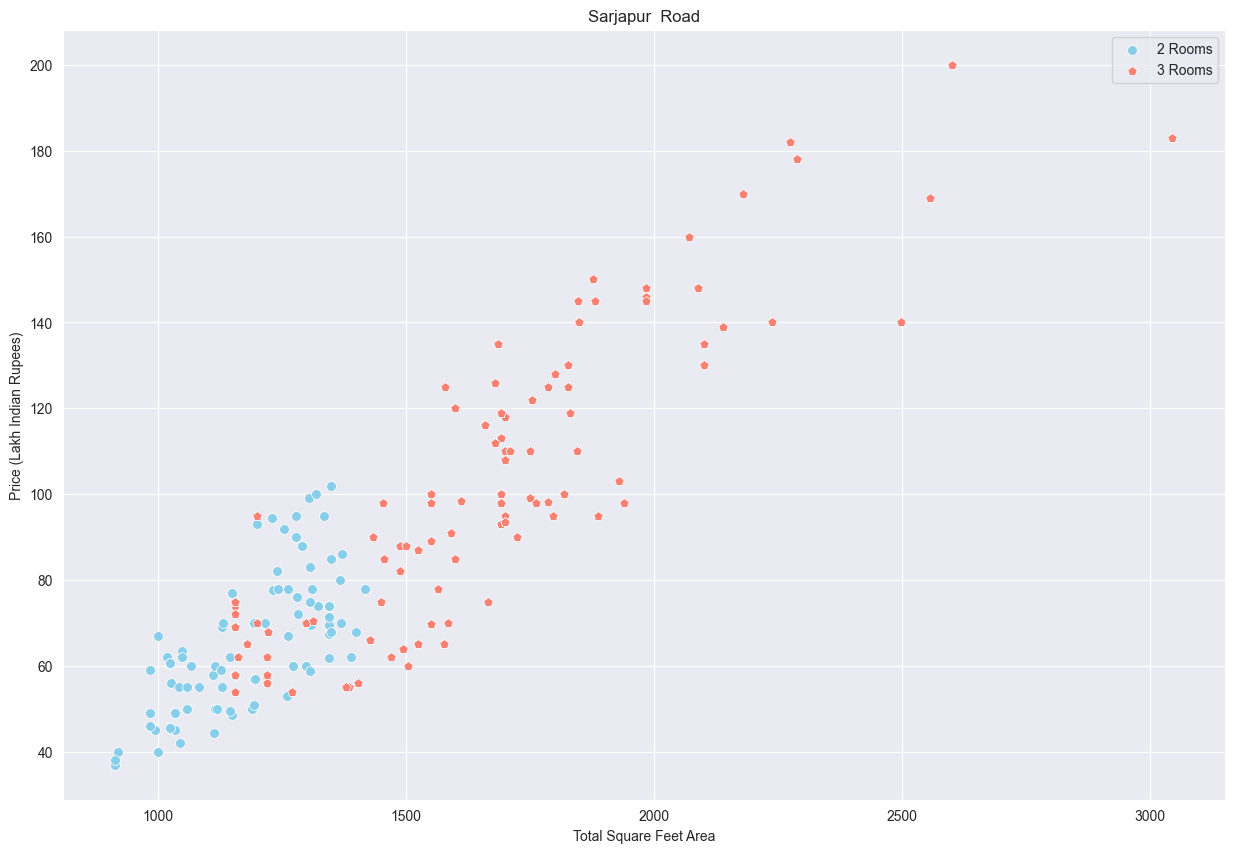

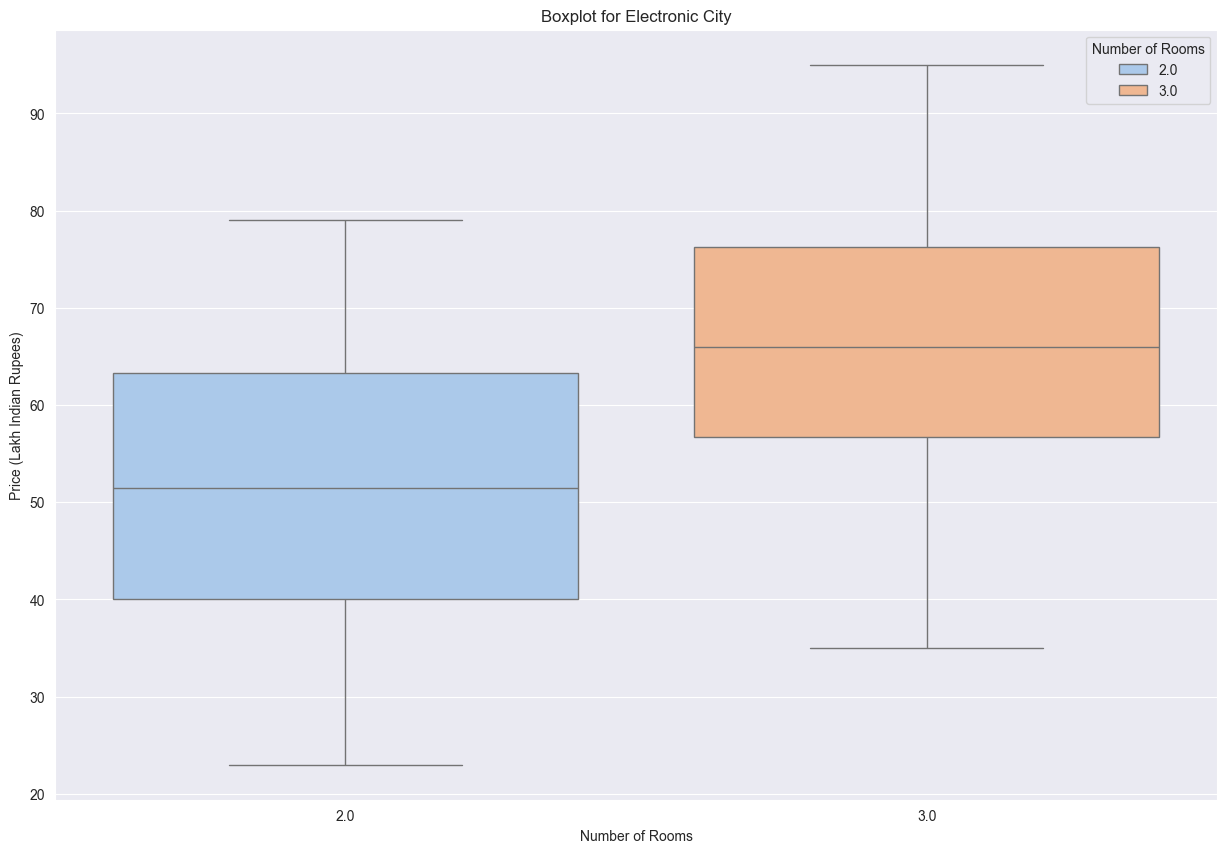

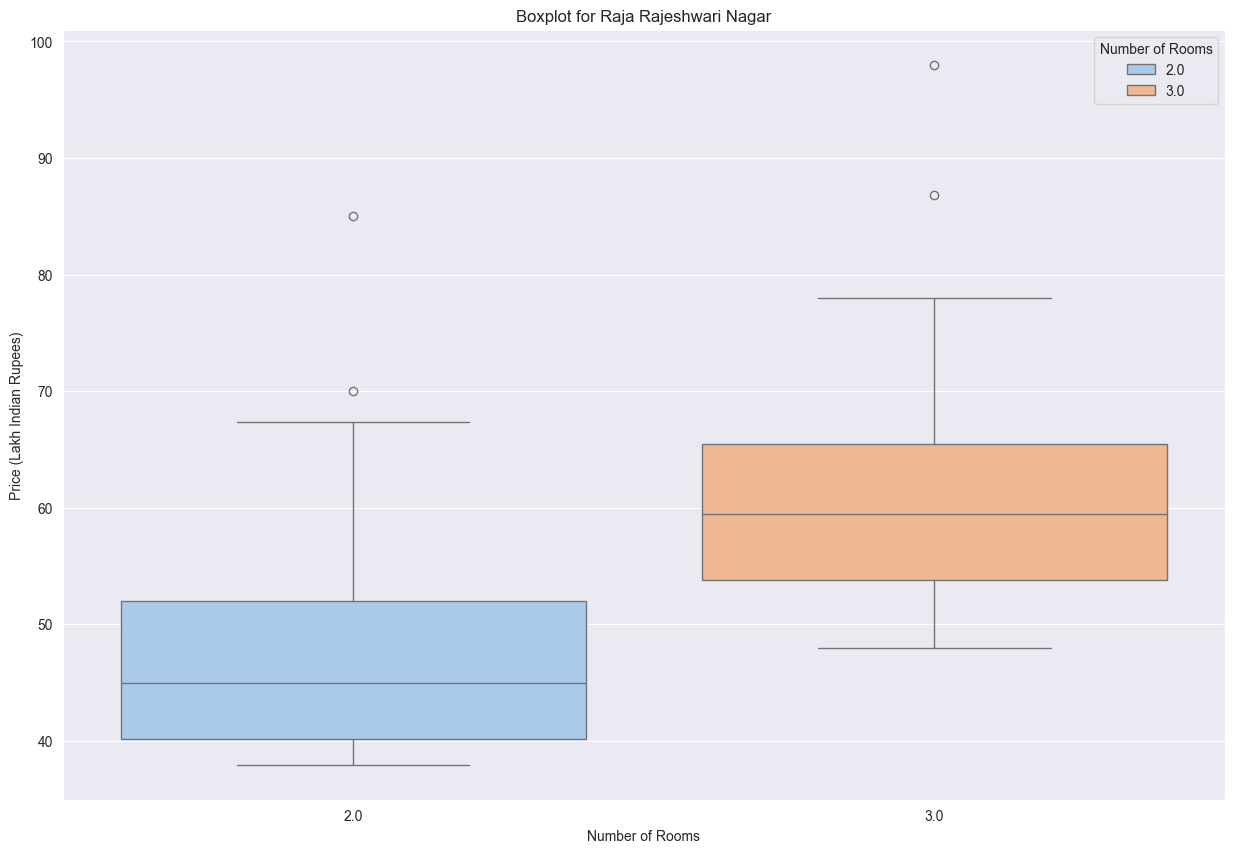

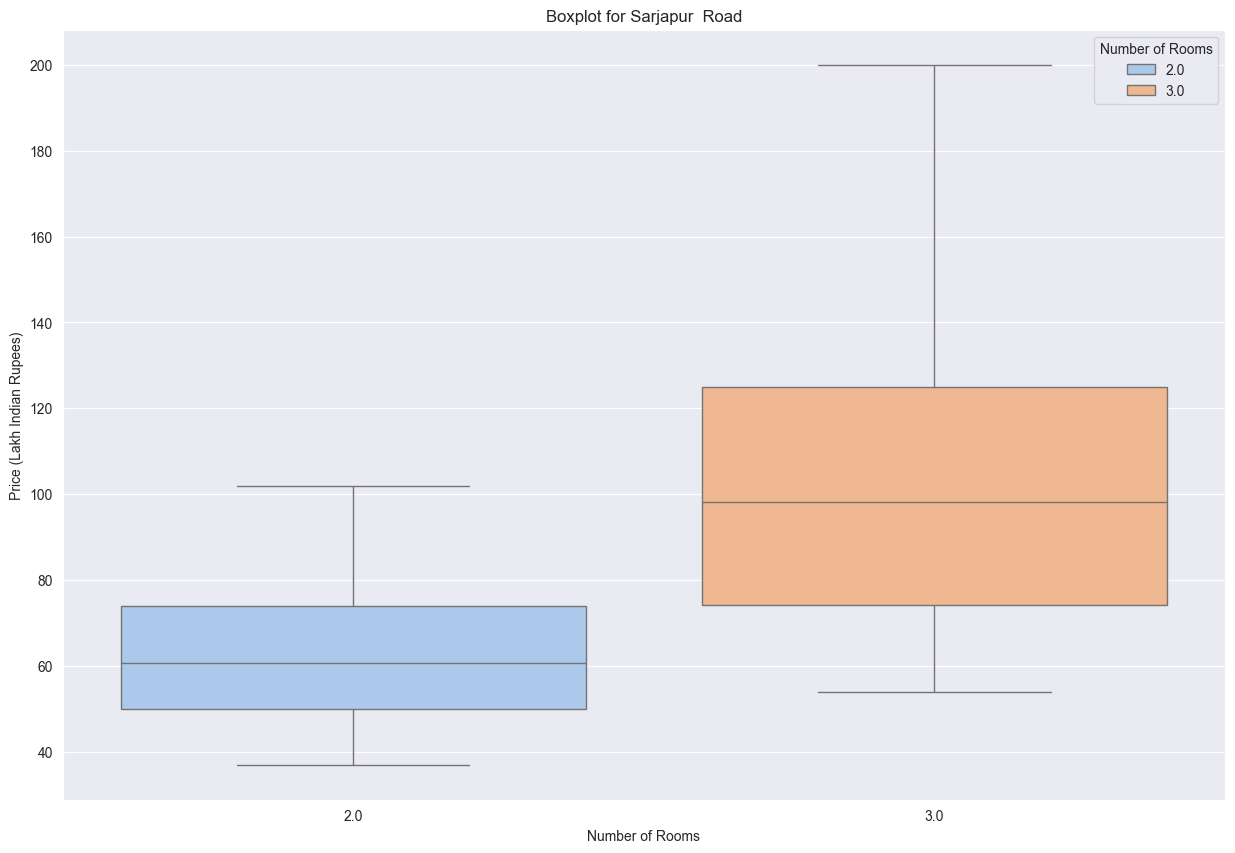

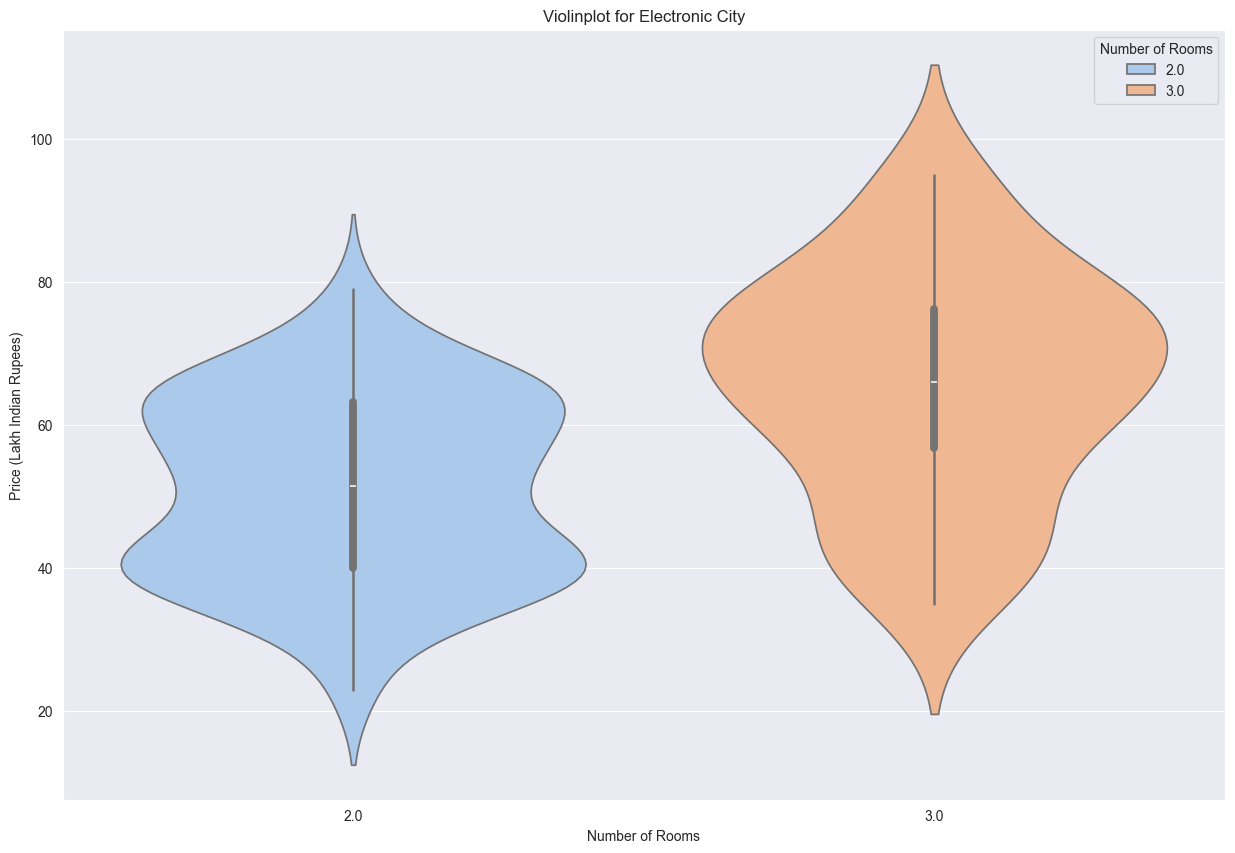

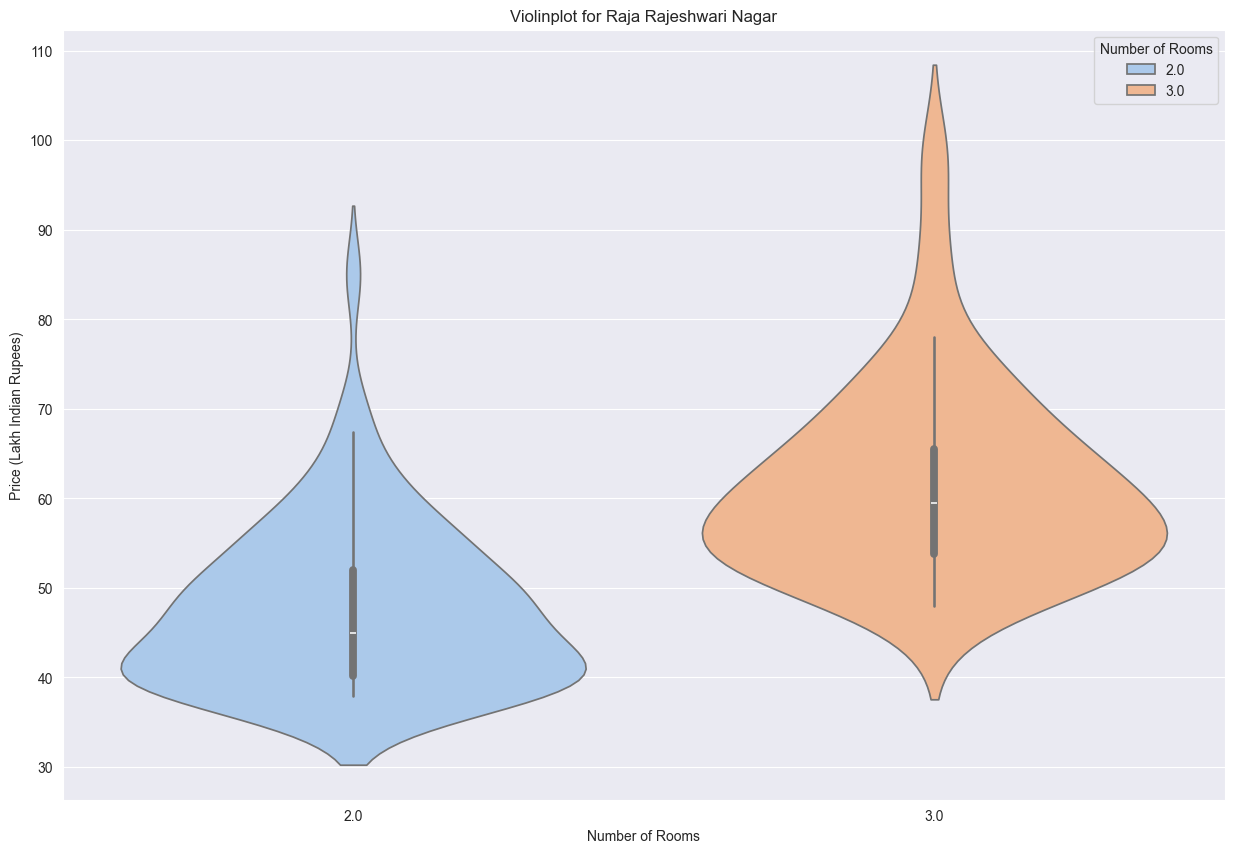

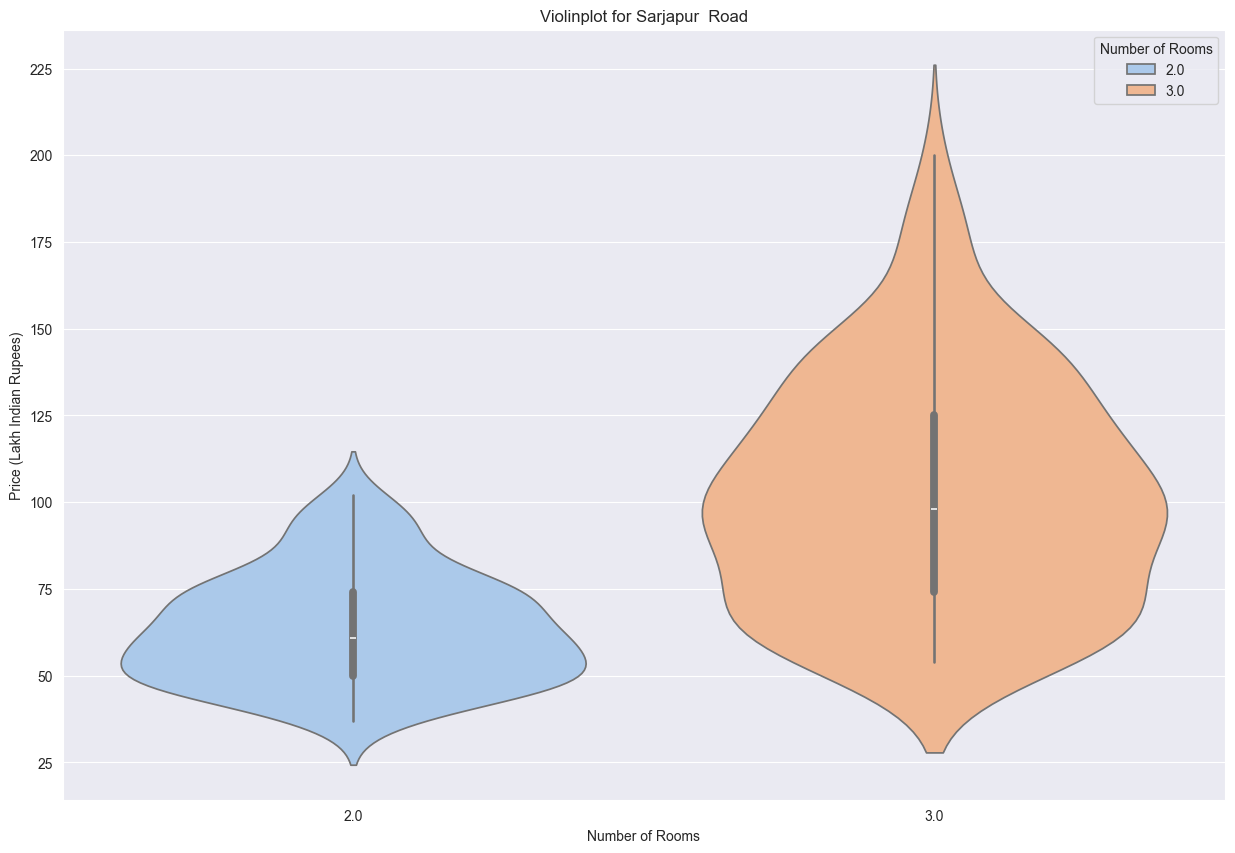

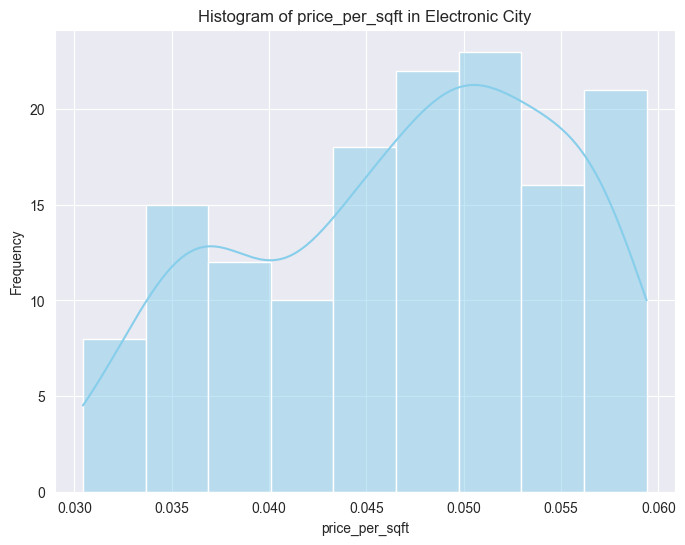

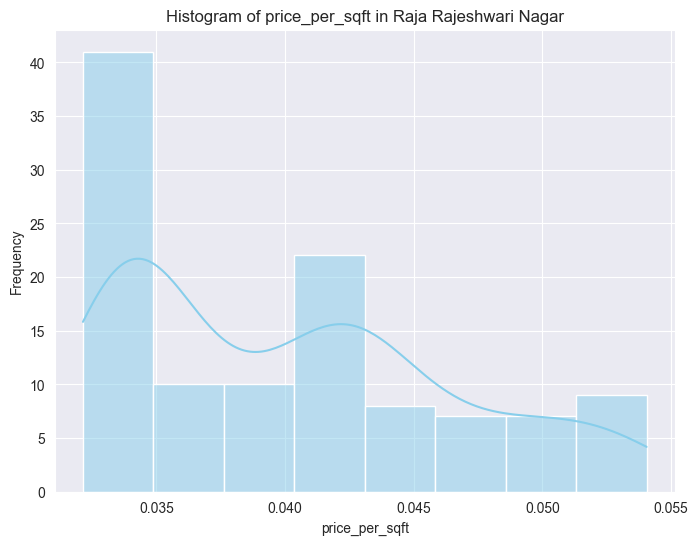

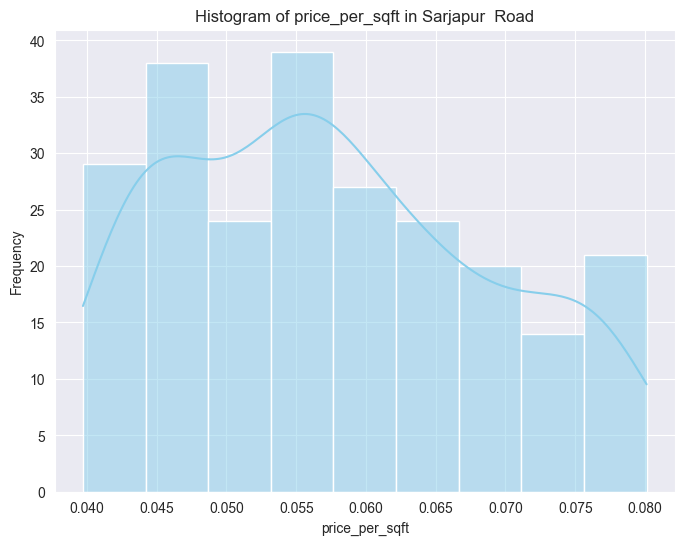

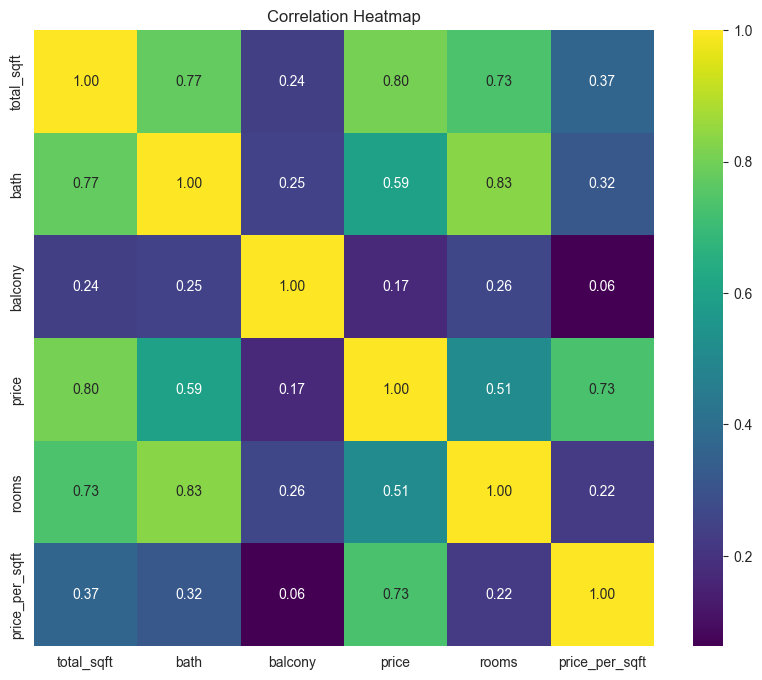

In [21]:
# See the scatter plots before the second removal
vd.plot_scatter_chart(remove_price_location.data_train, "Electronic City")
vd.plot_scatter_chart(remove_price_location.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_price_location.data_train, "Sarjapur  Road")

# Show data before the second removal in box plots
vd.plot_boxplot(remove_price_location.data_train, "Electronic City")
vd.plot_boxplot(remove_price_location.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_price_location.data_train, "Sarjapur  Road")

# Show data before the second removals in violins plot
vd.plot_violinplot(remove_price_location.data_train, "Electronic City")
vd.plot_violinplot(remove_price_location.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_price_location.data_train, "Sarjapur  Road")

# Show data before the second removal in histograms
vd.plot_histogram(remove_price_location.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_price_location.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_price_location.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_price_location.data_train)

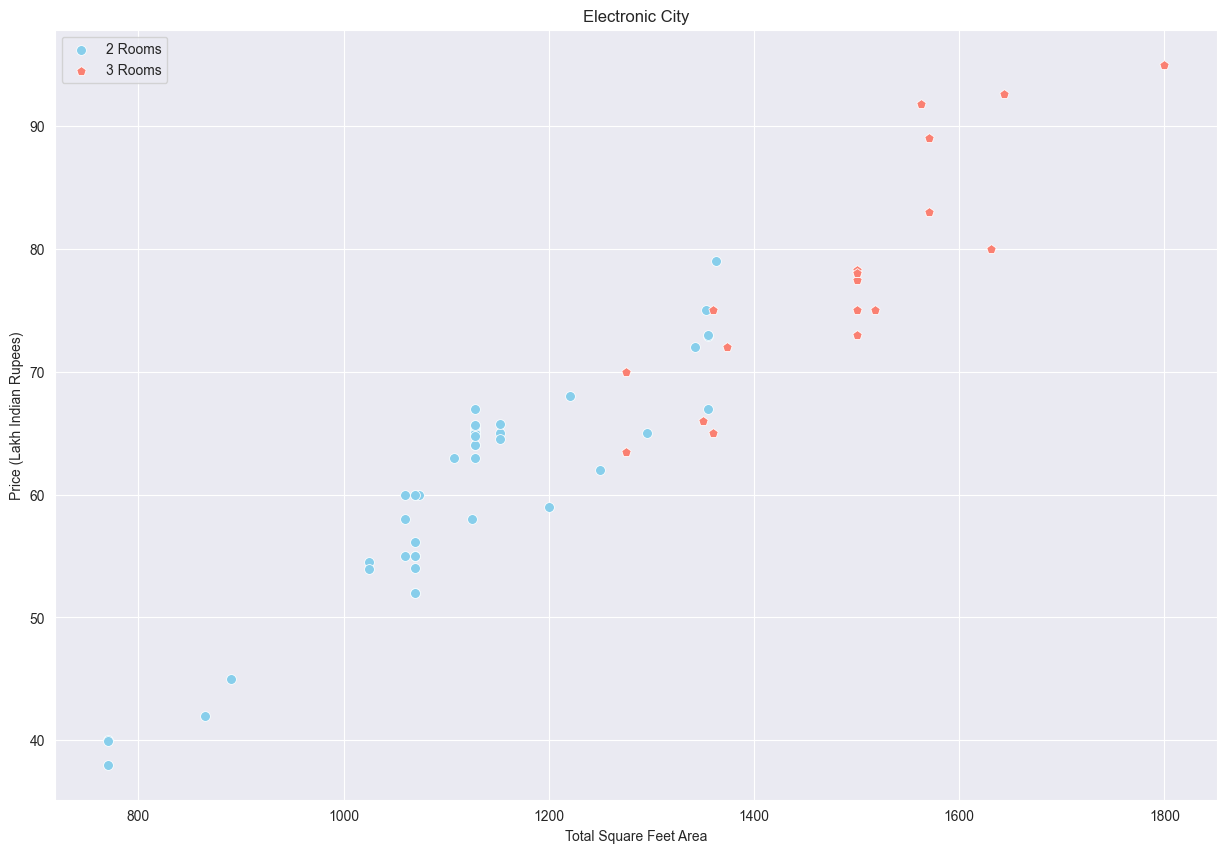

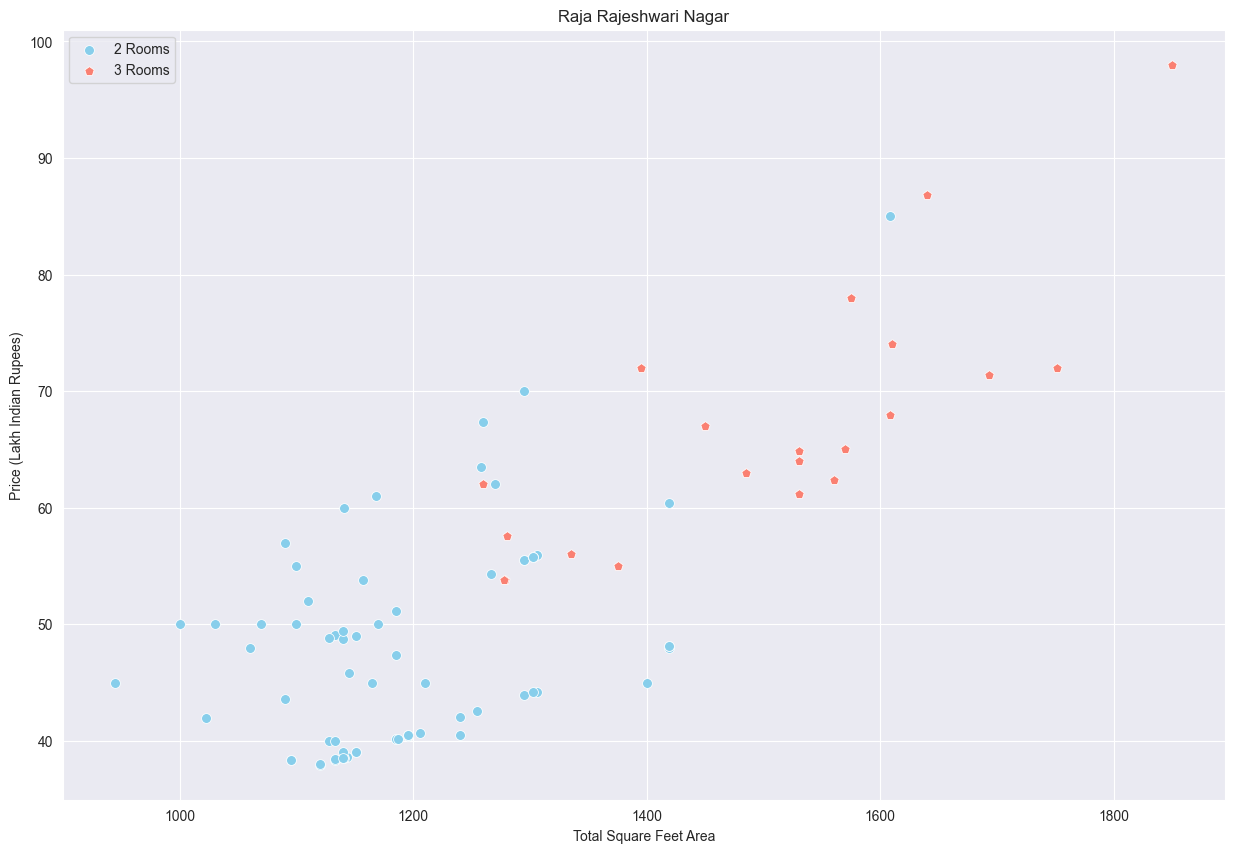

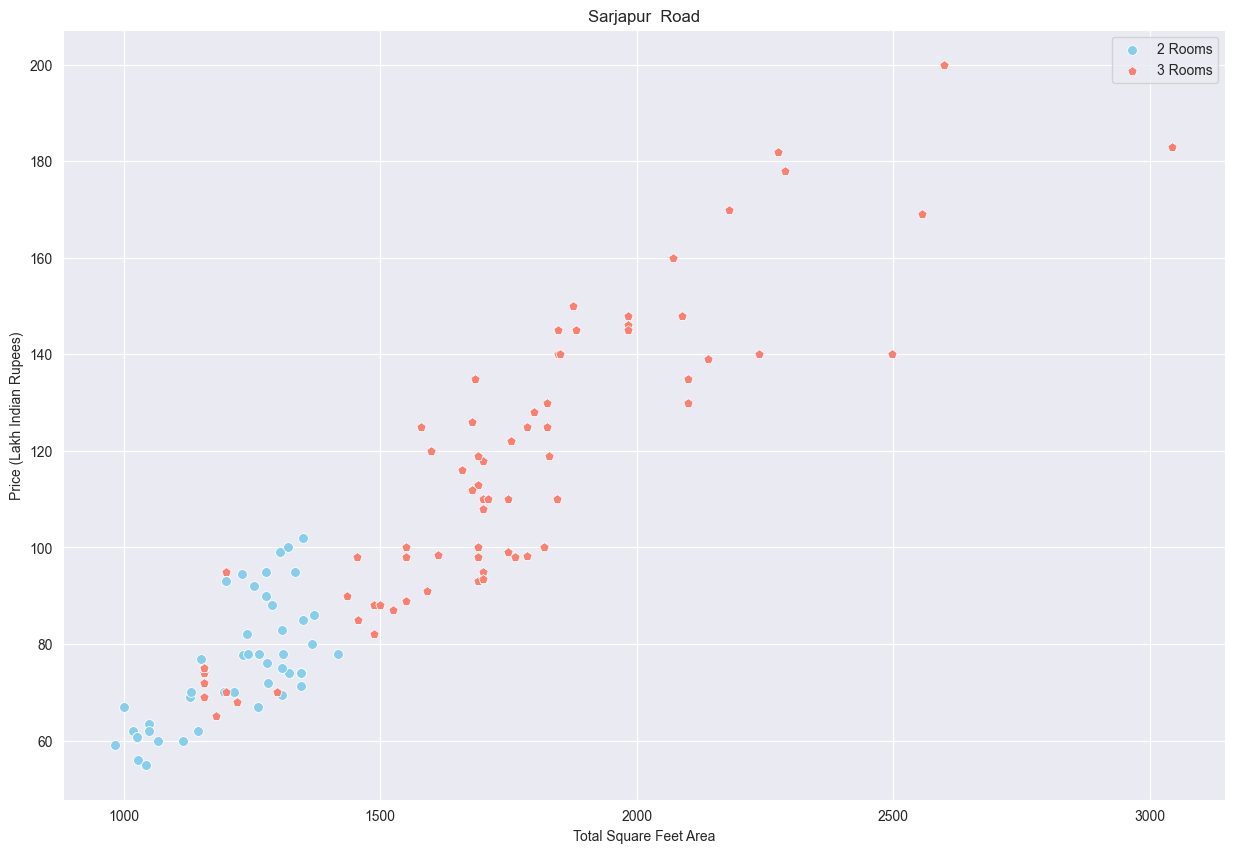

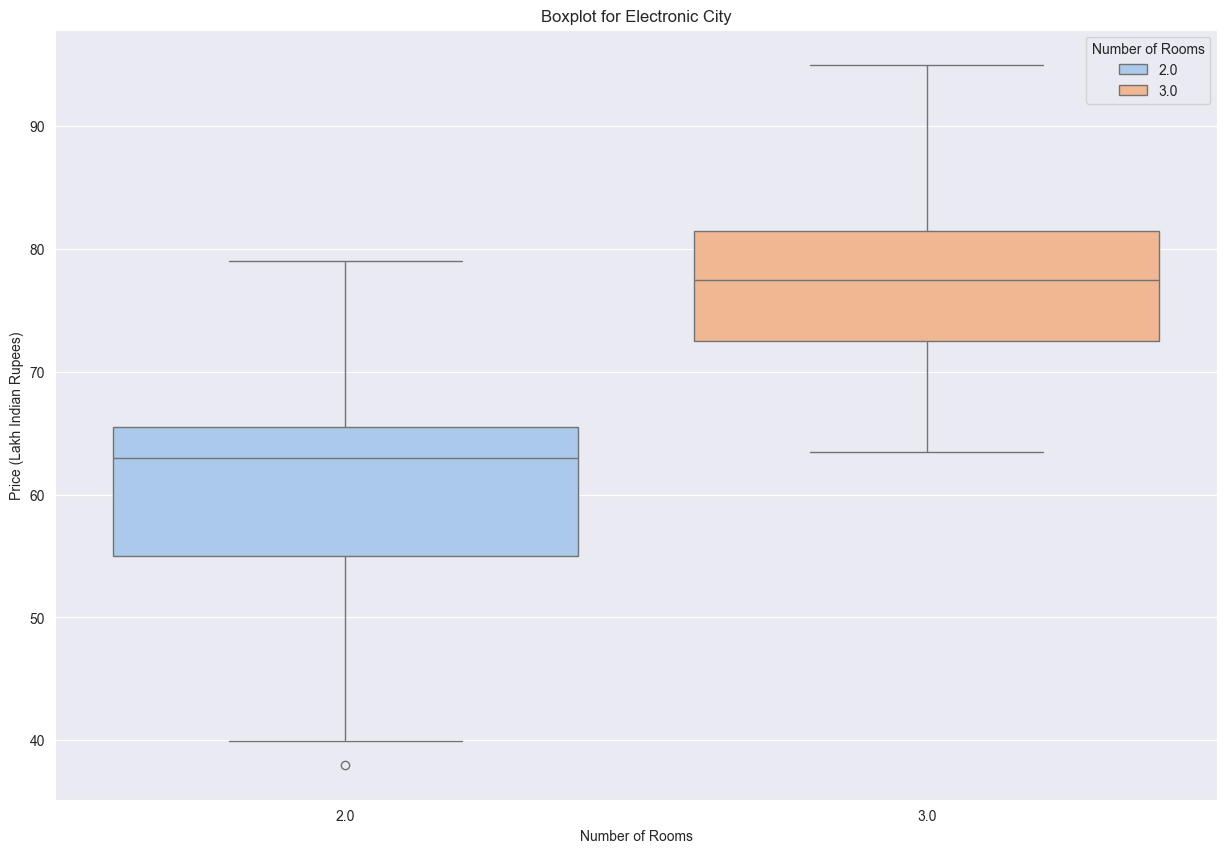

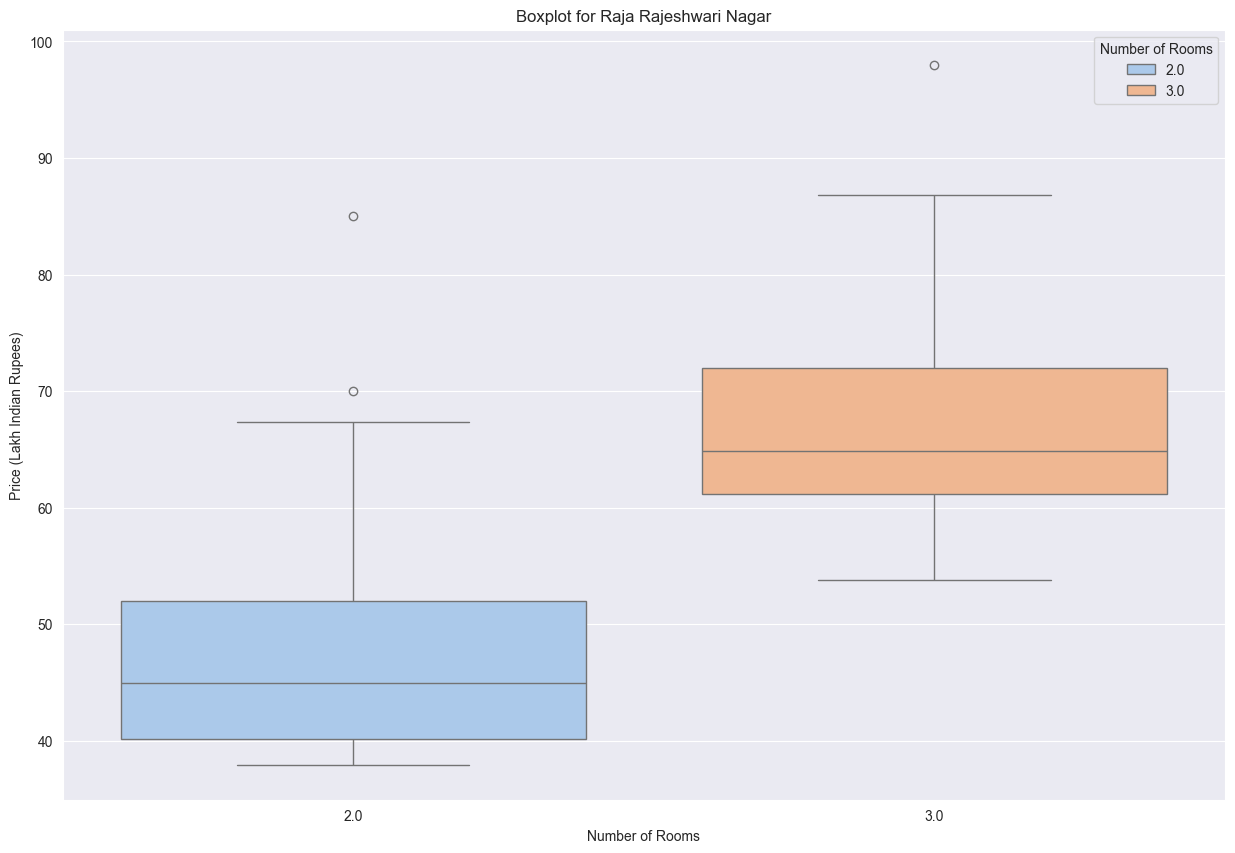

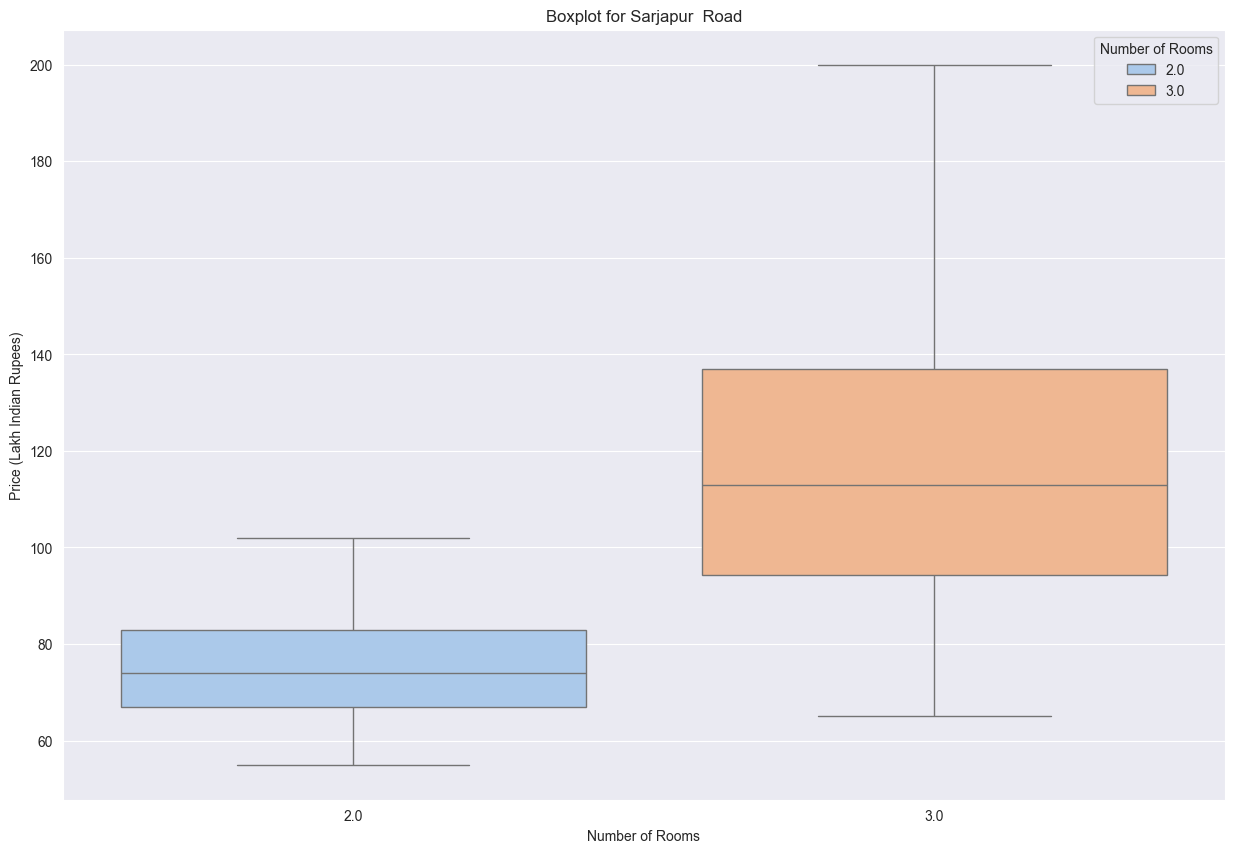

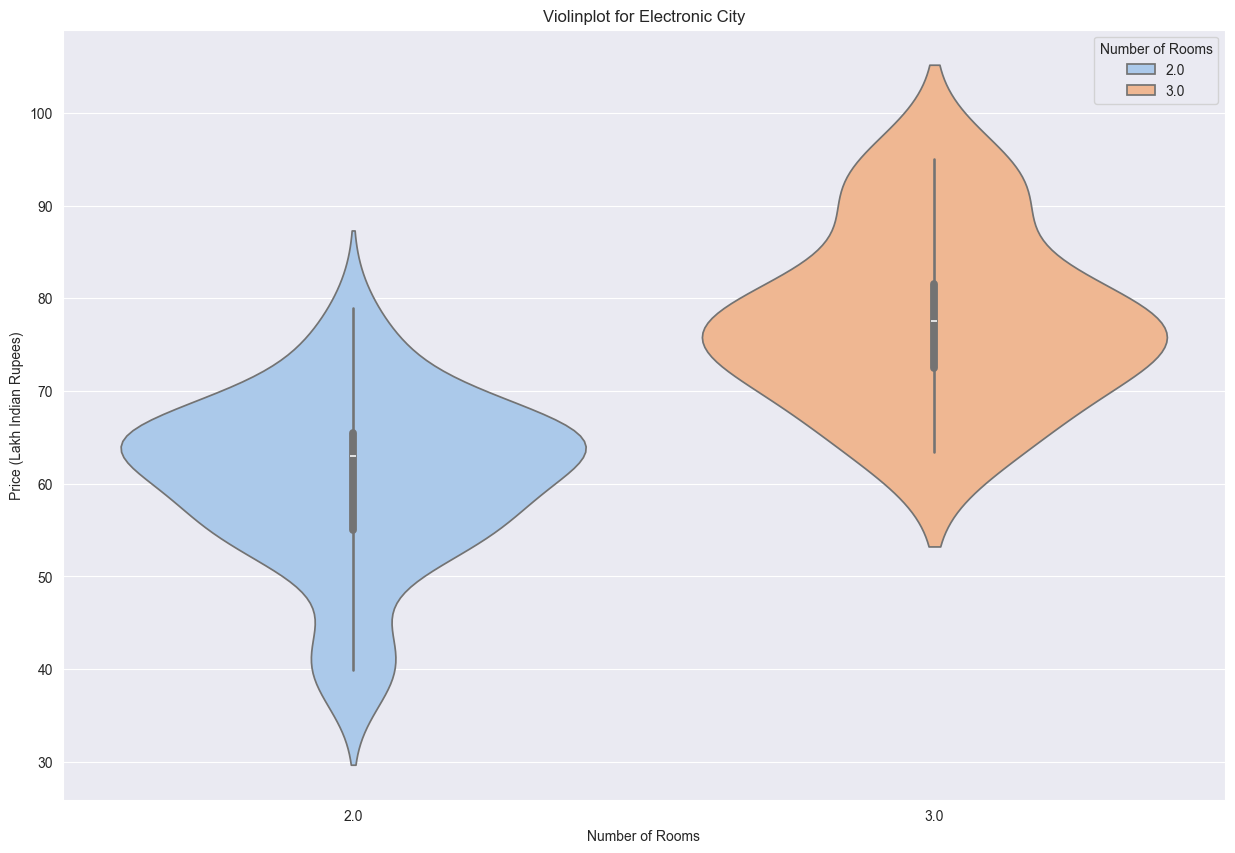

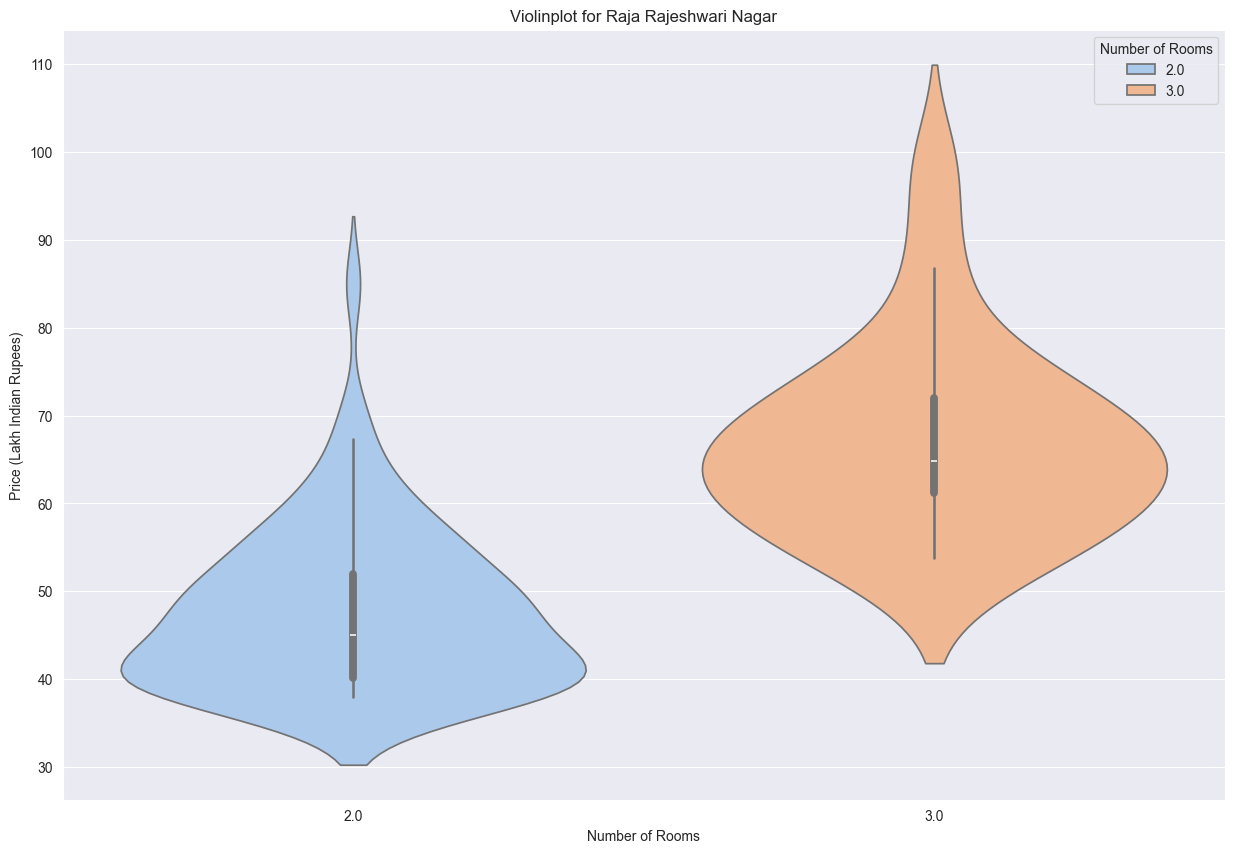

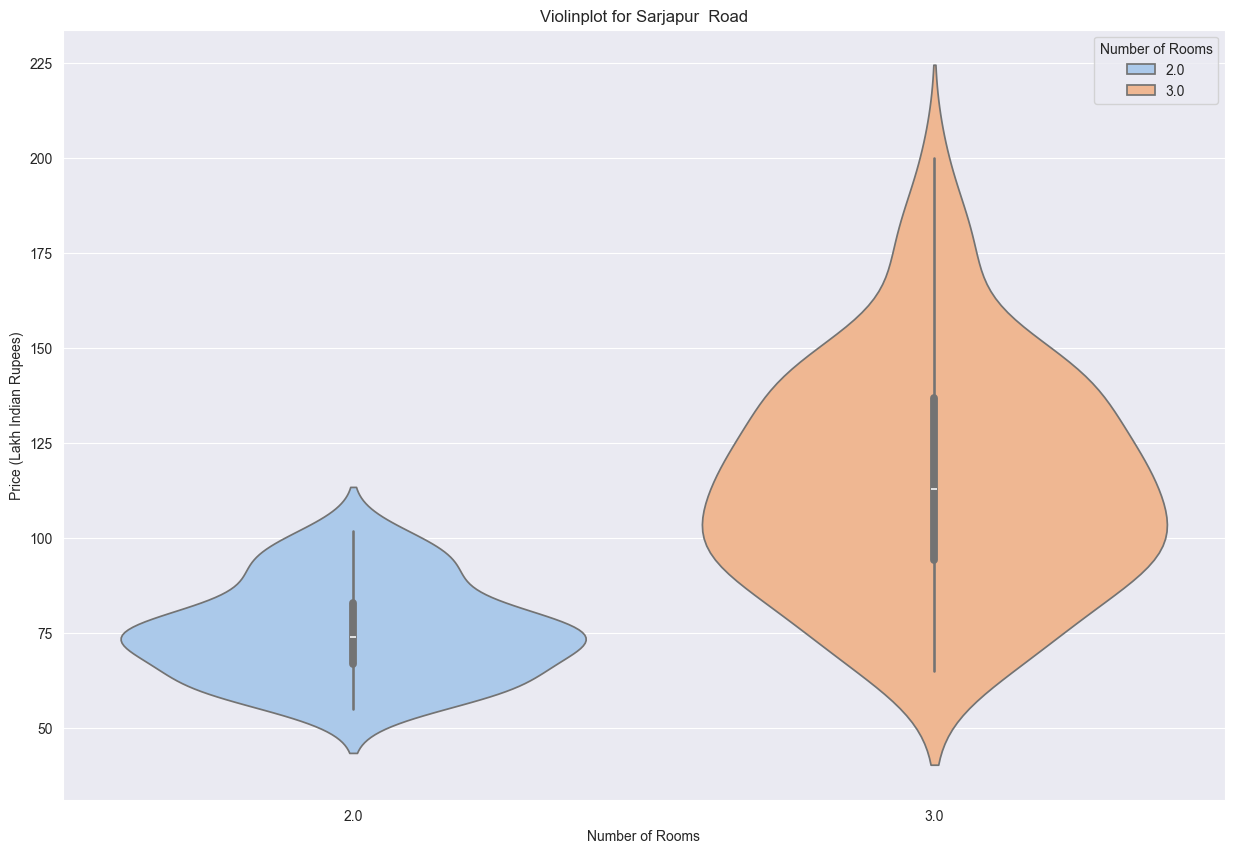

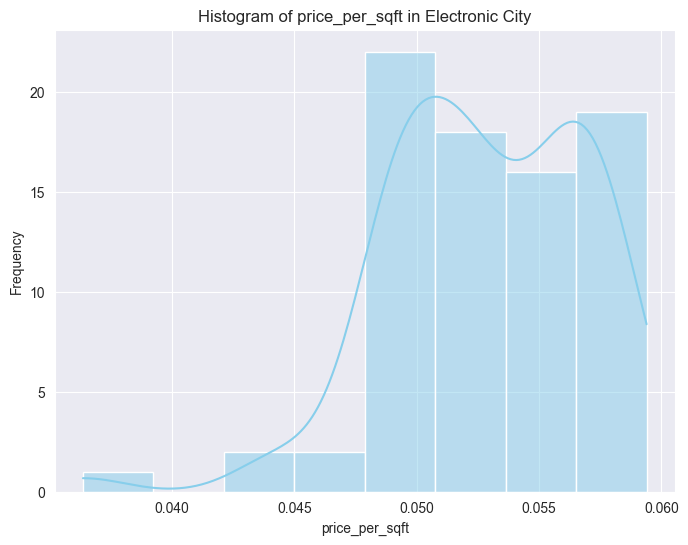

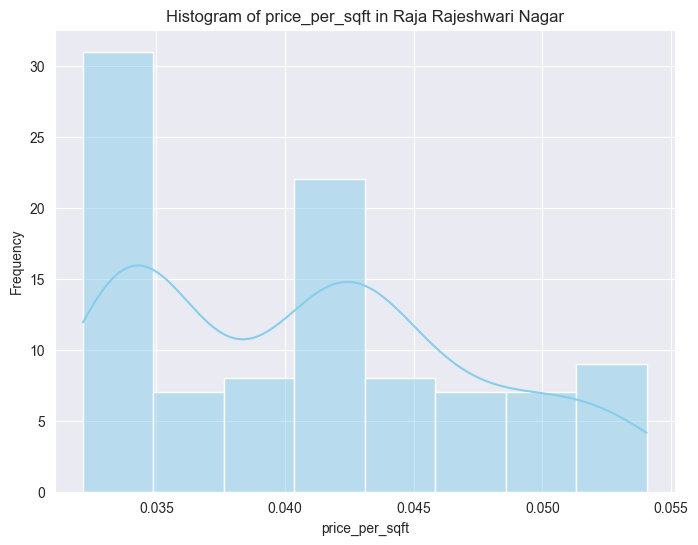

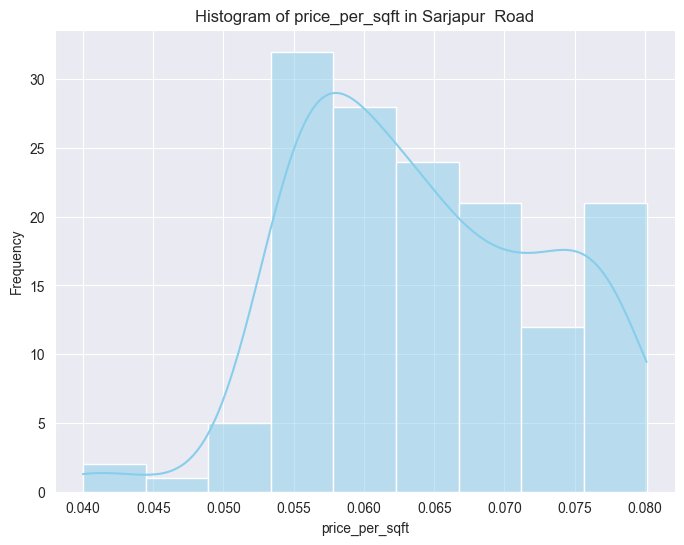

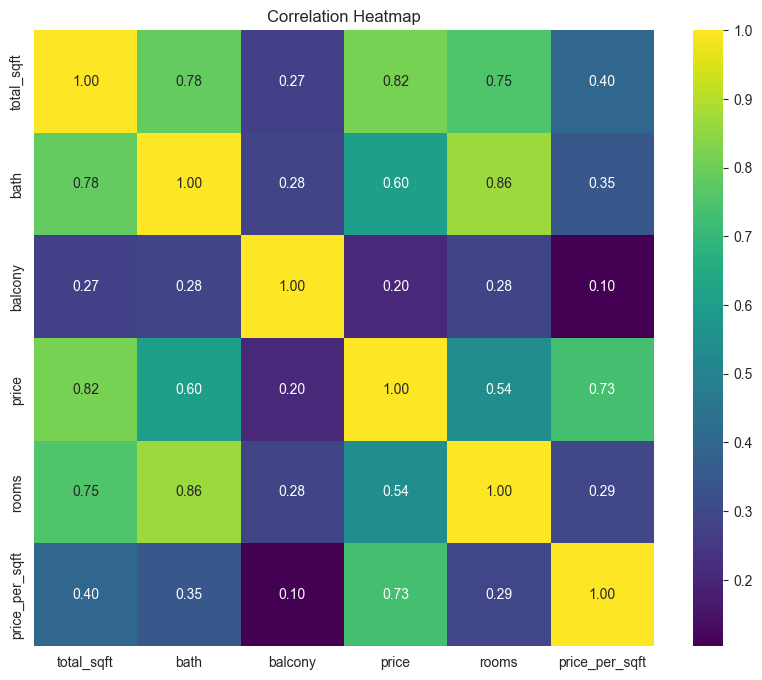

In [22]:
# See the scatter plots after the second removal
vd.plot_scatter_chart(remove_bedroom.data_train, "Electronic City")
vd.plot_scatter_chart(remove_bedroom.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_bedroom.data_train, "Sarjapur  Road")

# Show data after the second removal in box plots
vd.plot_boxplot(remove_bedroom.data_train, "Electronic City")
vd.plot_boxplot(remove_bedroom.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_bedroom.data_train, "Sarjapur  Road")

# Show data after the second removal in violins plot
vd.plot_violinplot(remove_bedroom.data_train, "Electronic City")
vd.plot_violinplot(remove_bedroom.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_bedroom.data_train, "Sarjapur  Road")

# Show data after the second removal in histograms
vd.plot_histogram(remove_bedroom.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_bedroom.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_bedroom.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_bedroom.data_train)

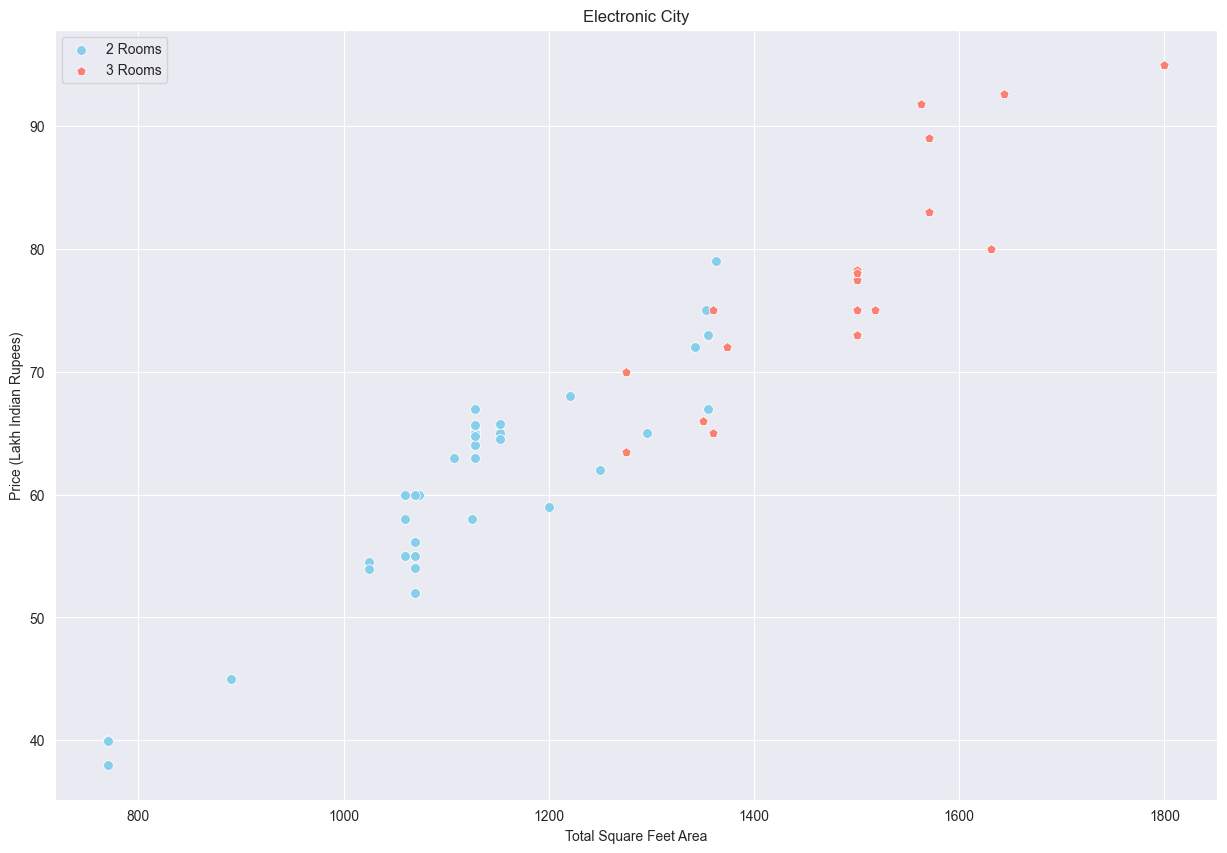

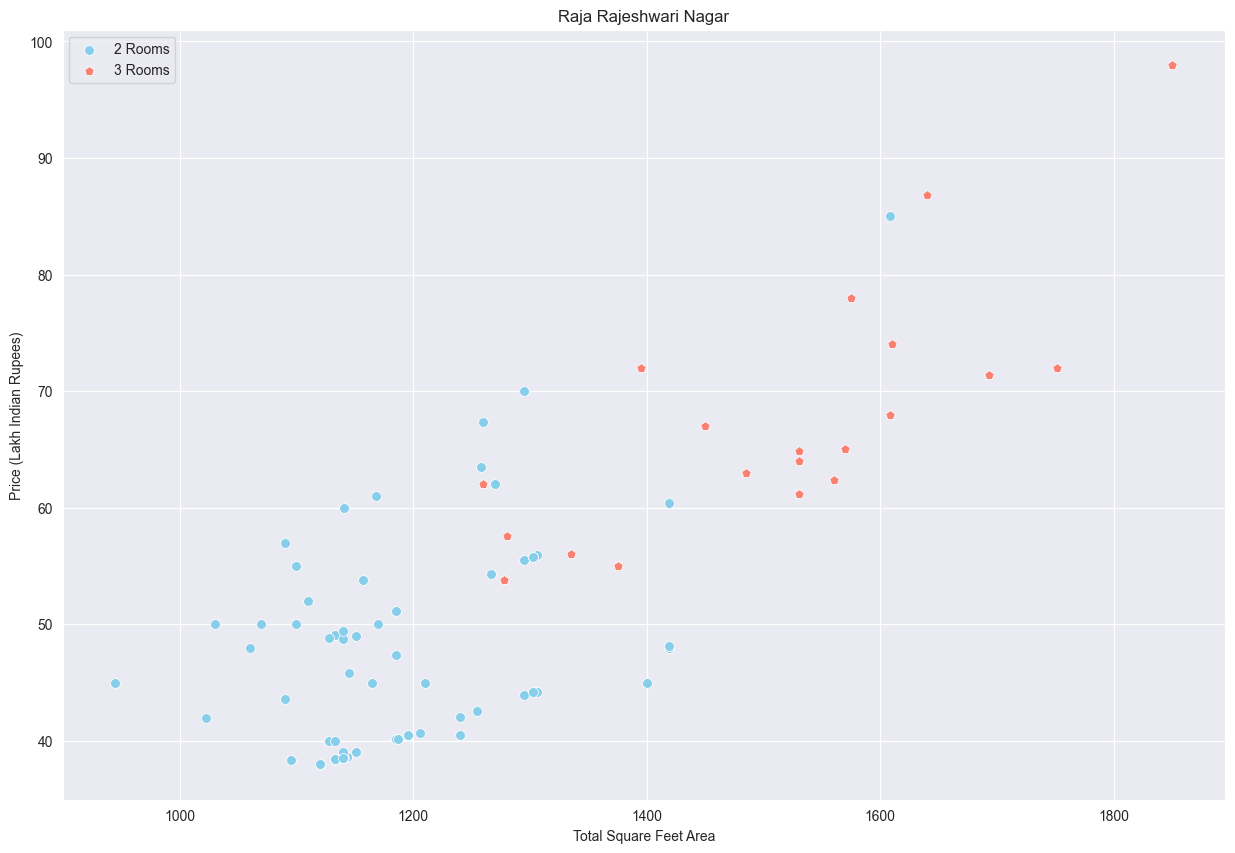

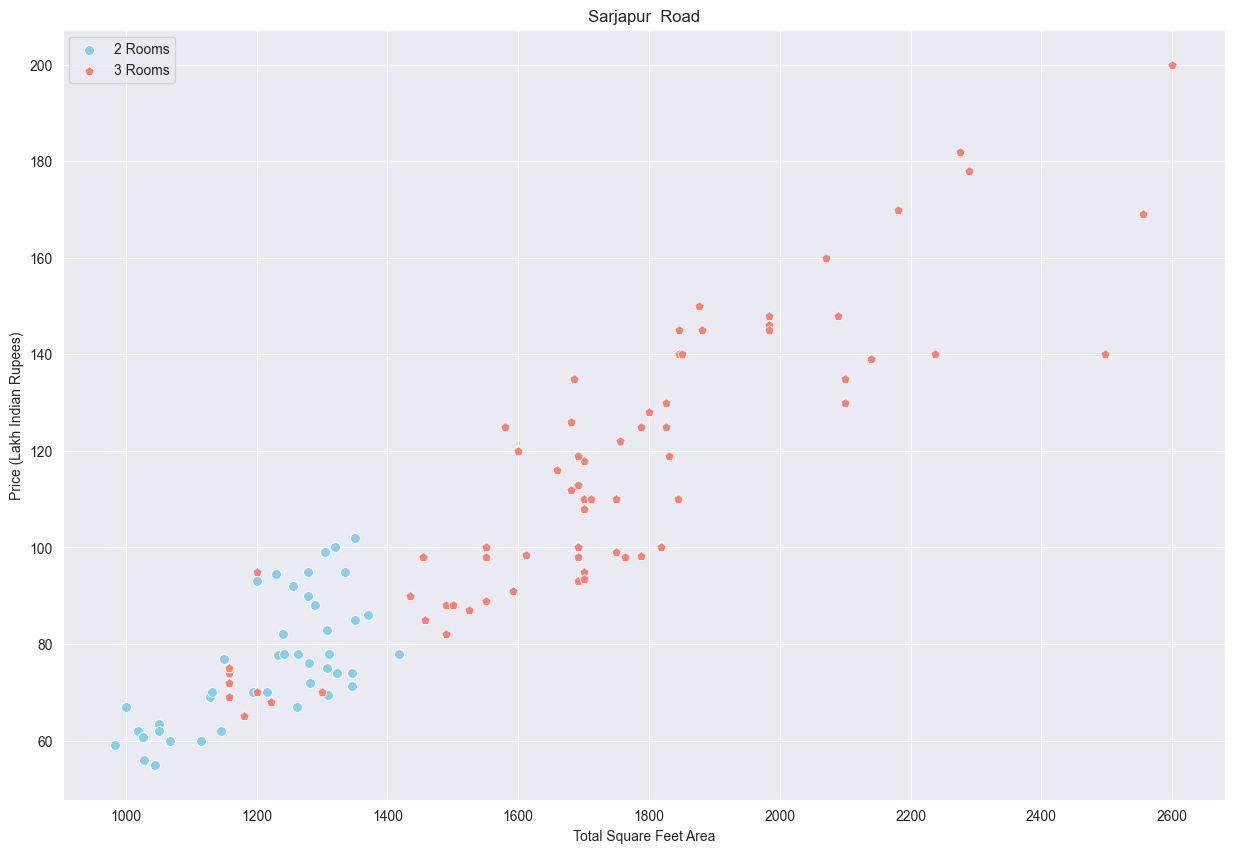

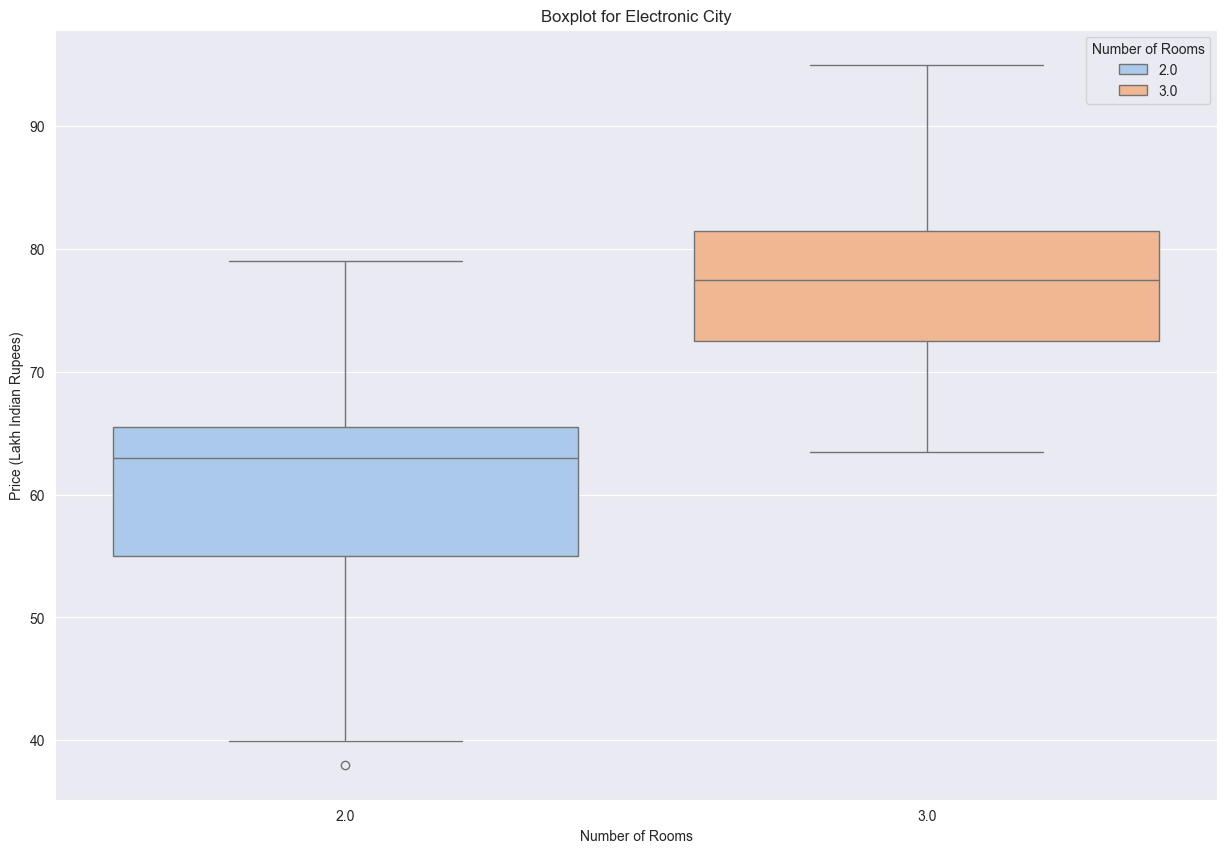

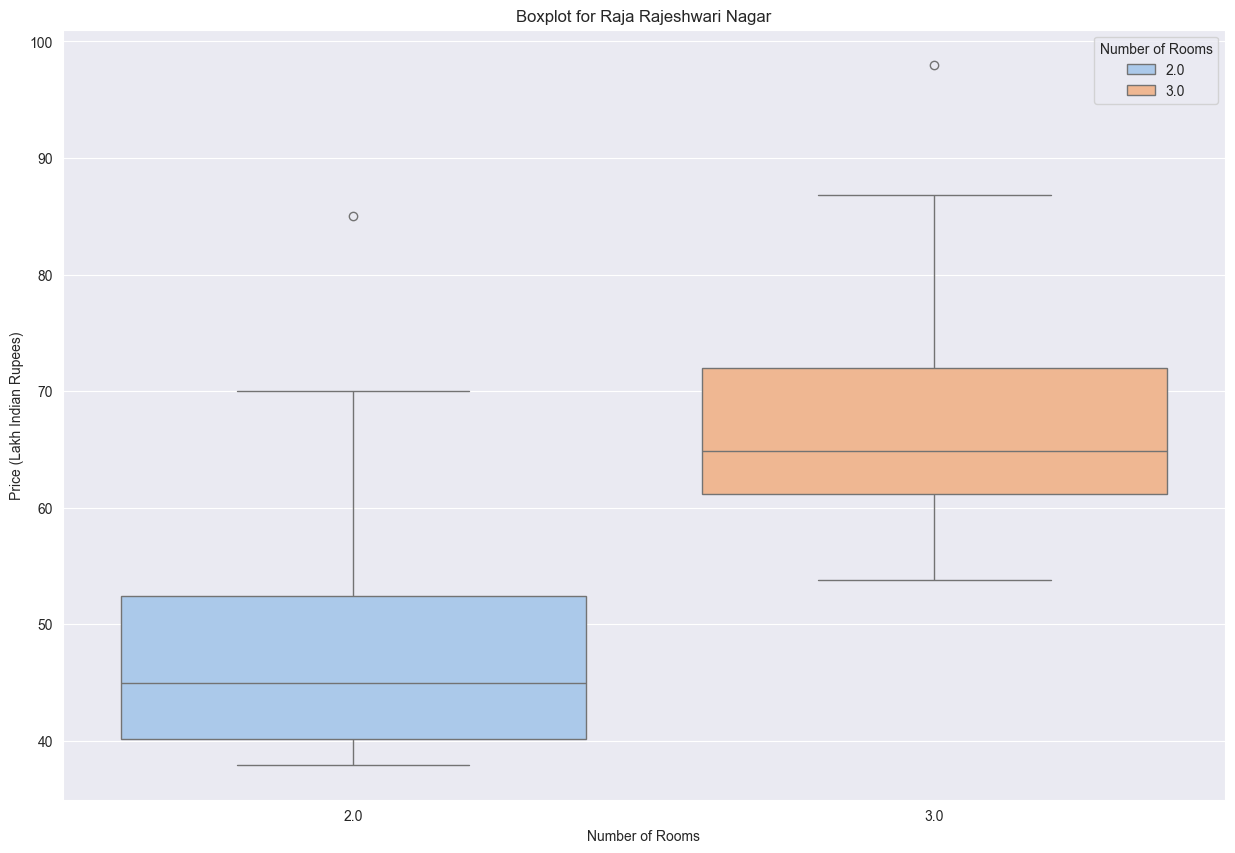

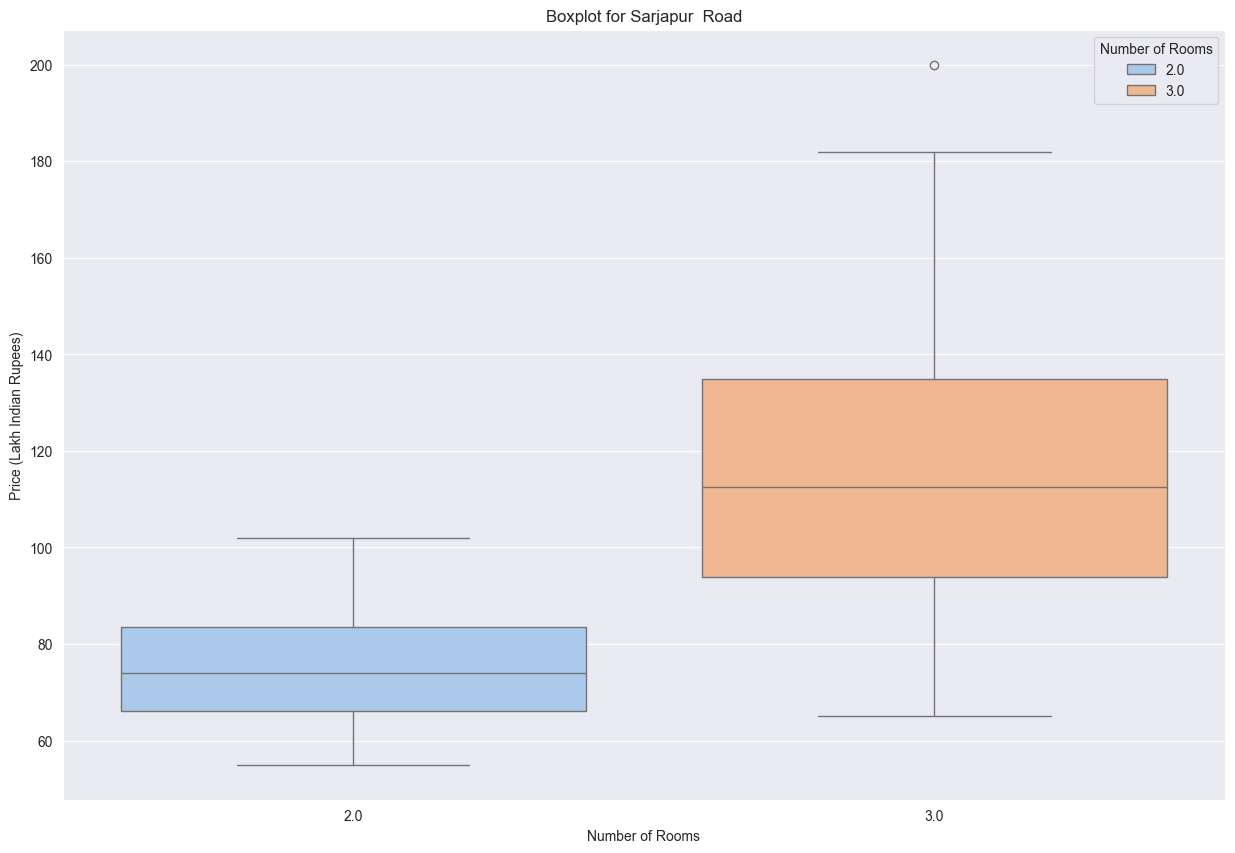

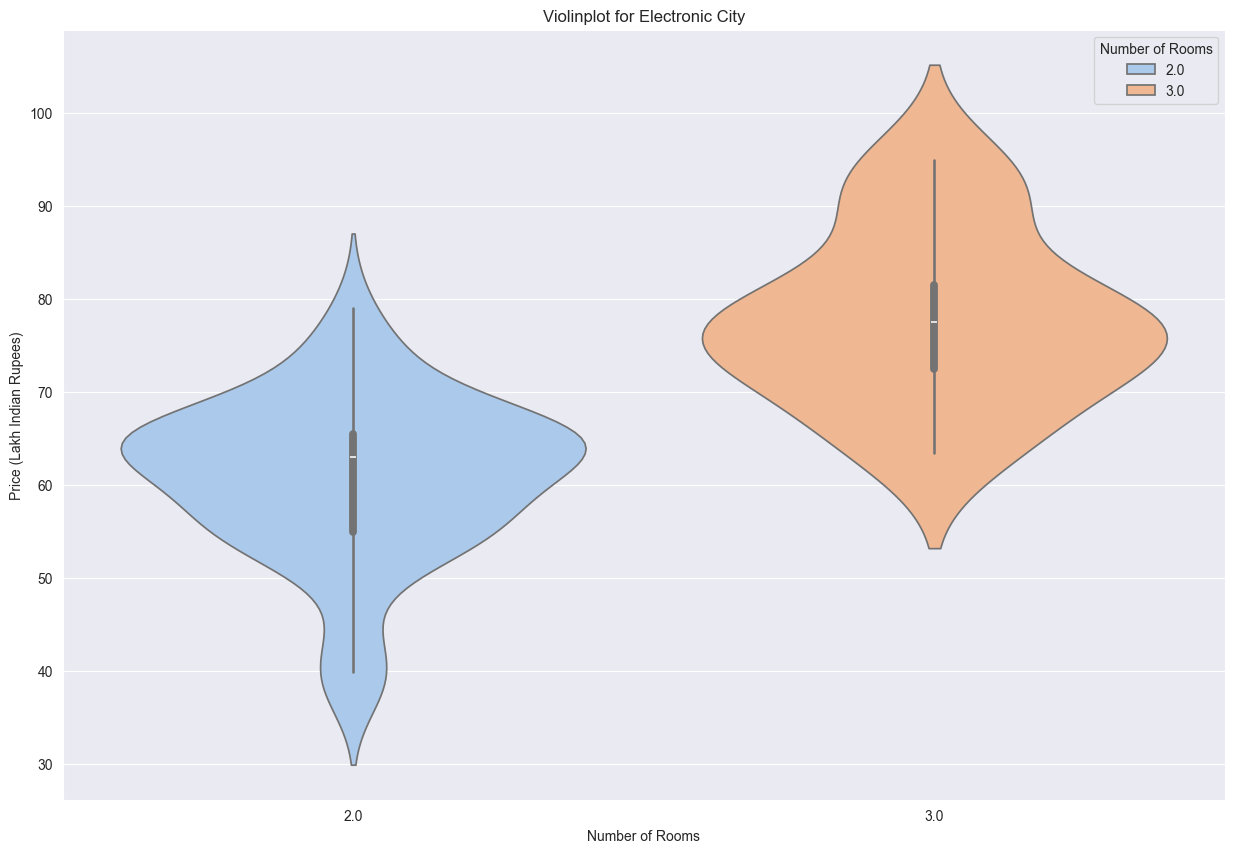

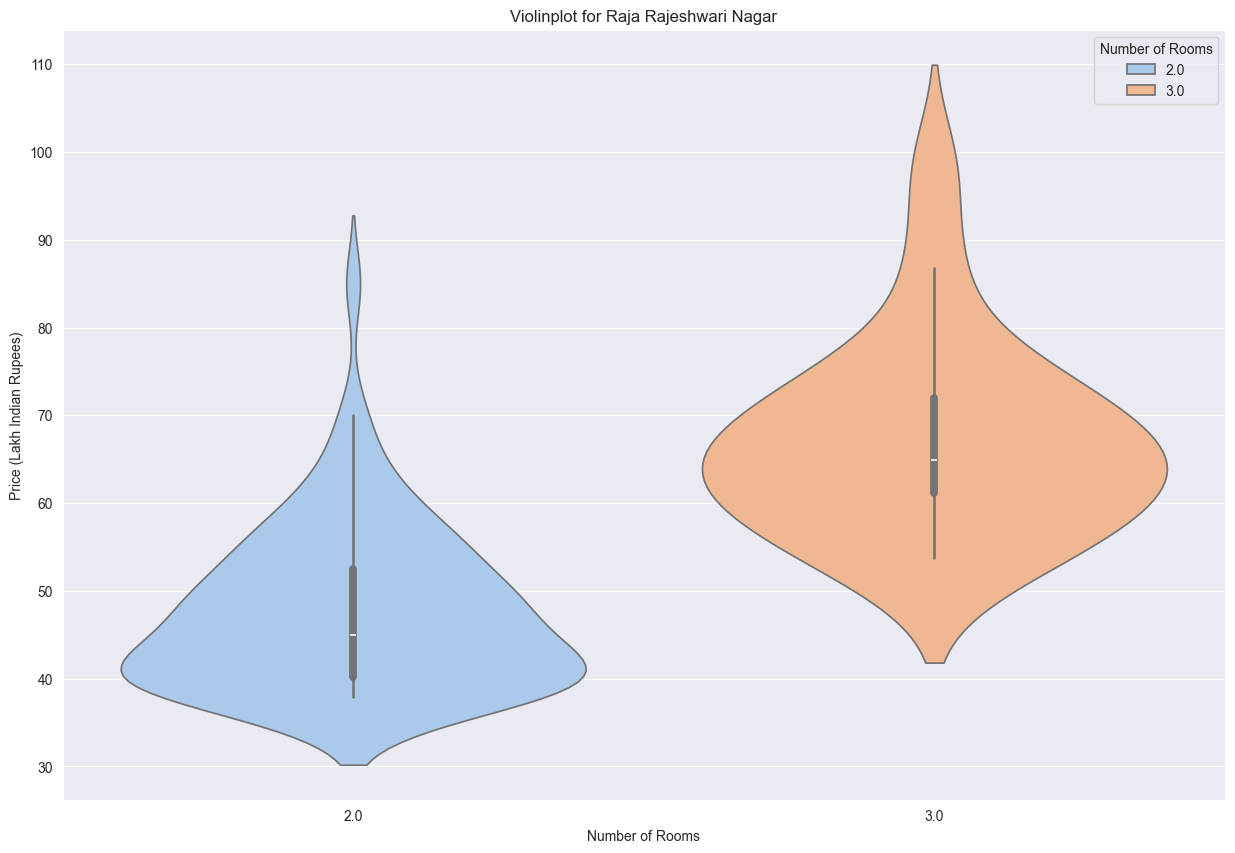

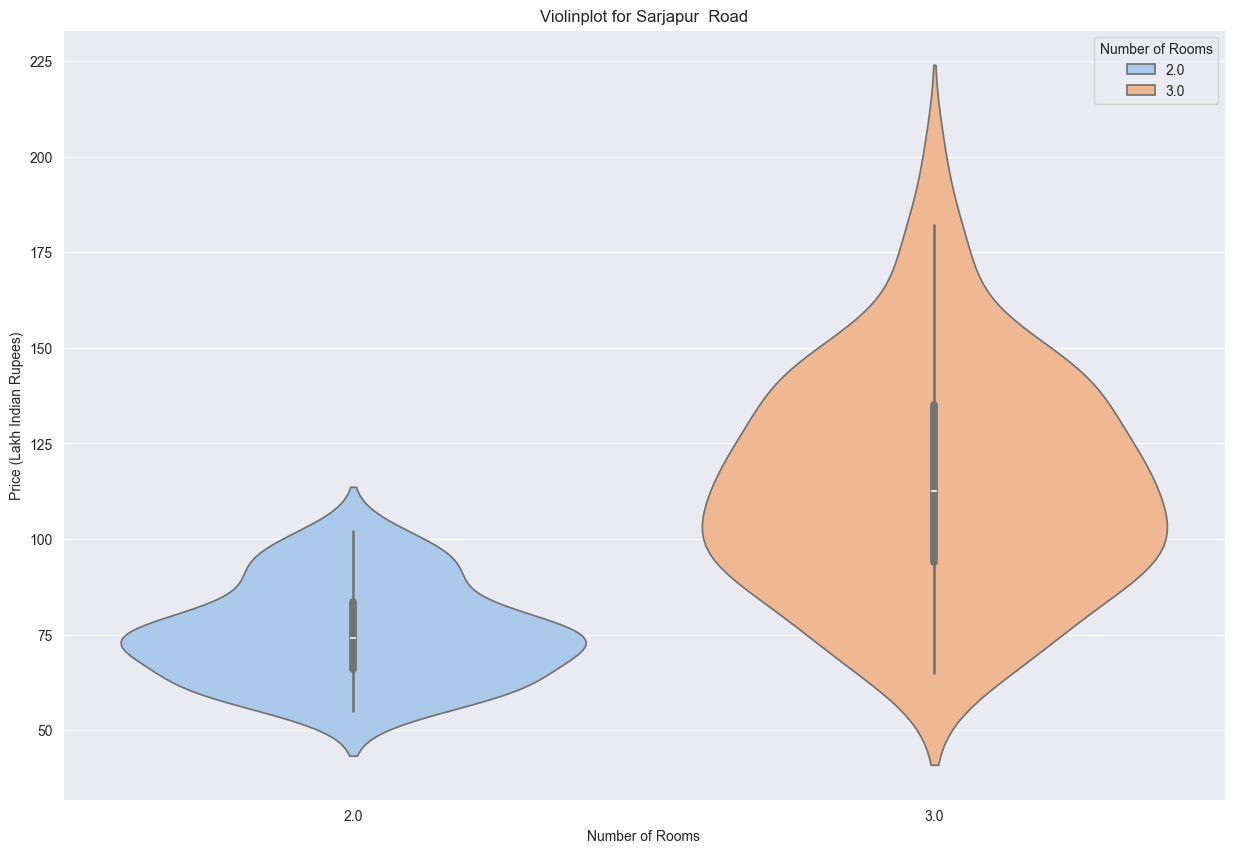

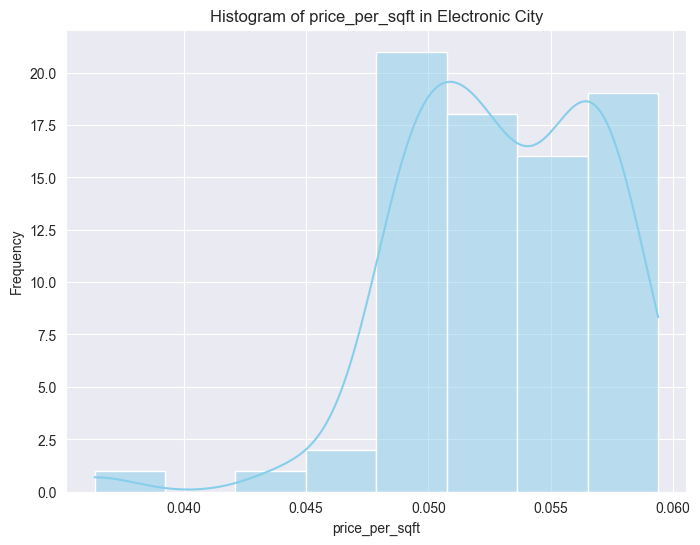

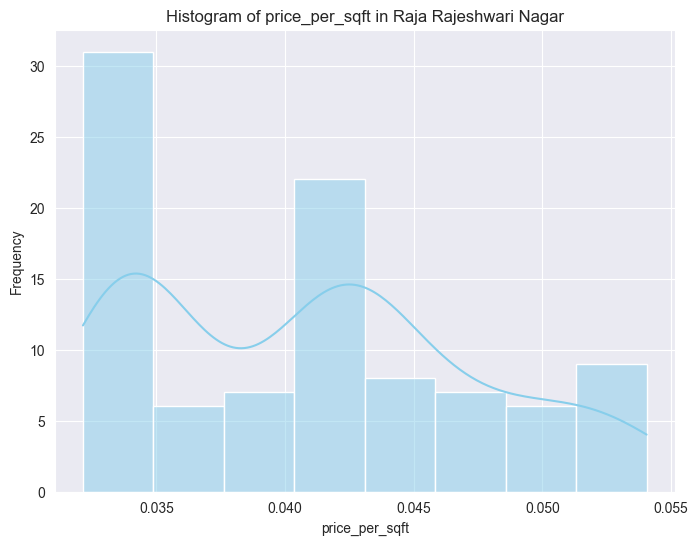

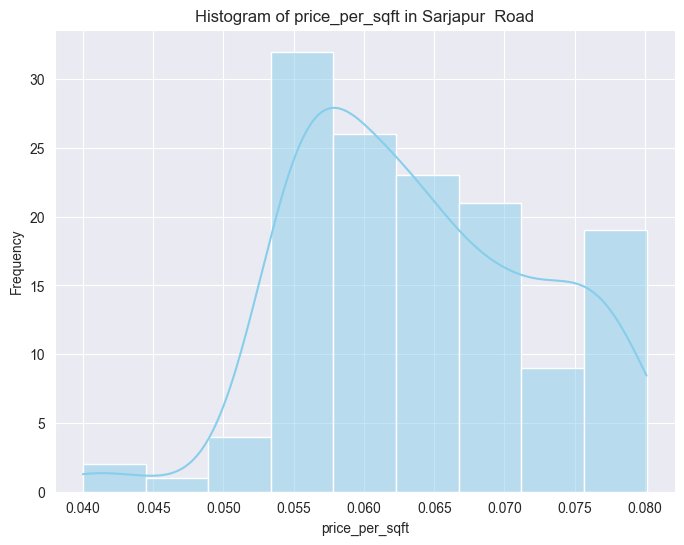

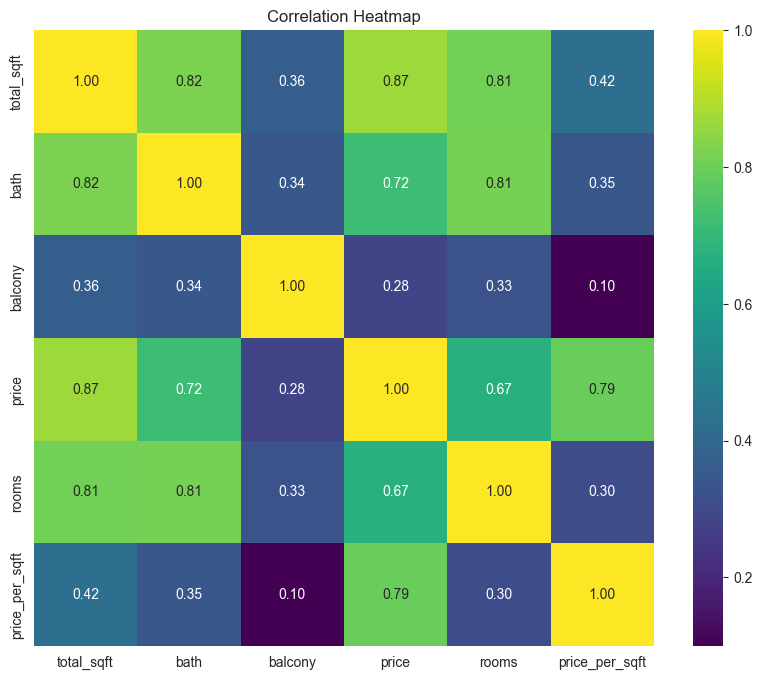

In [23]:
# See the scatter plots before the last removal
vd.plot_scatter_chart(remove_outliers.data_train, "Electronic City")
vd.plot_scatter_chart(remove_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_outliers.data_train, "Sarjapur  Road")

# Show data before the last removal in box plots
vd.plot_boxplot(remove_outliers.data_train, "Electronic City")
vd.plot_boxplot(remove_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_outliers.data_train, "Sarjapur  Road")

# Show data before the last removal in violins plot
vd.plot_violinplot(remove_outliers.data_train, "Electronic City")
vd.plot_violinplot(remove_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_outliers.data_train, "Sarjapur  Road")

# Show data before the last removal in histograms
vd.plot_histogram(remove_outliers.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_outliers.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_outliers.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_outliers.data_train)

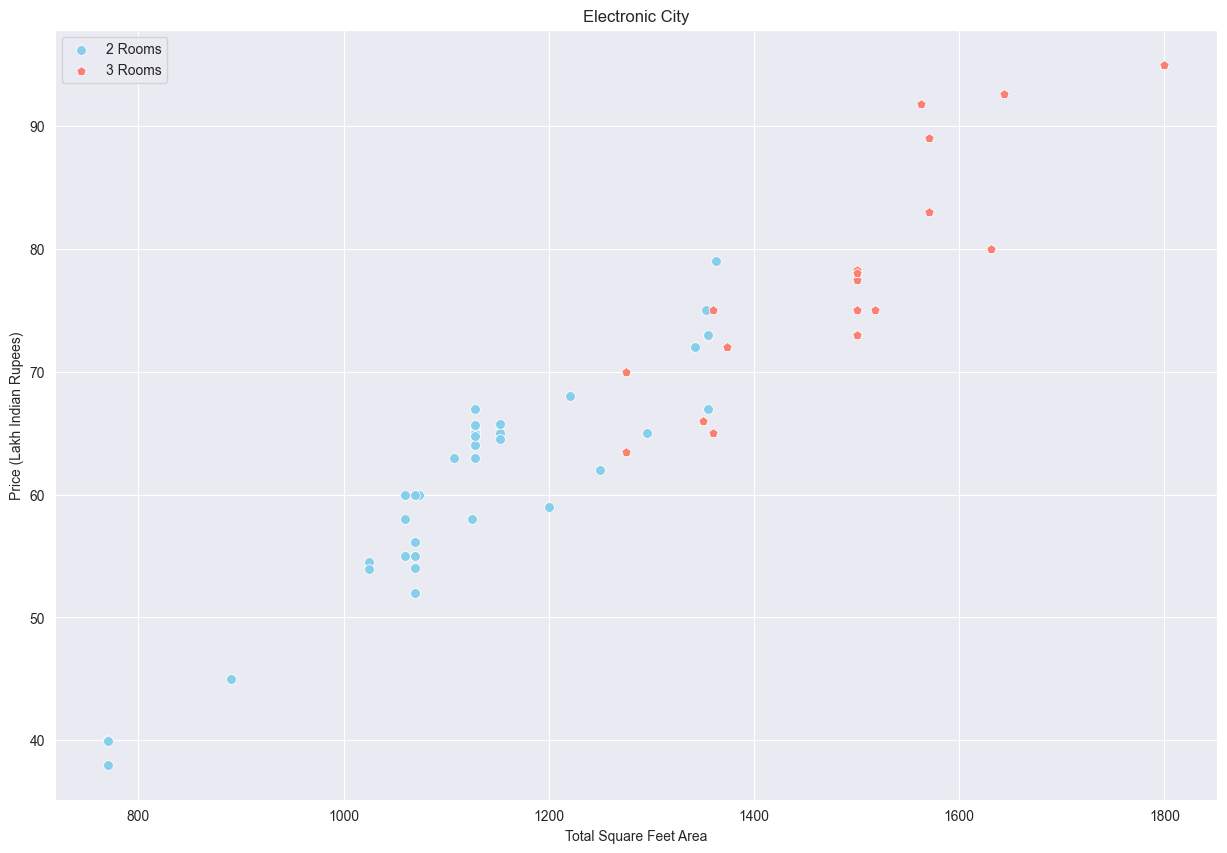

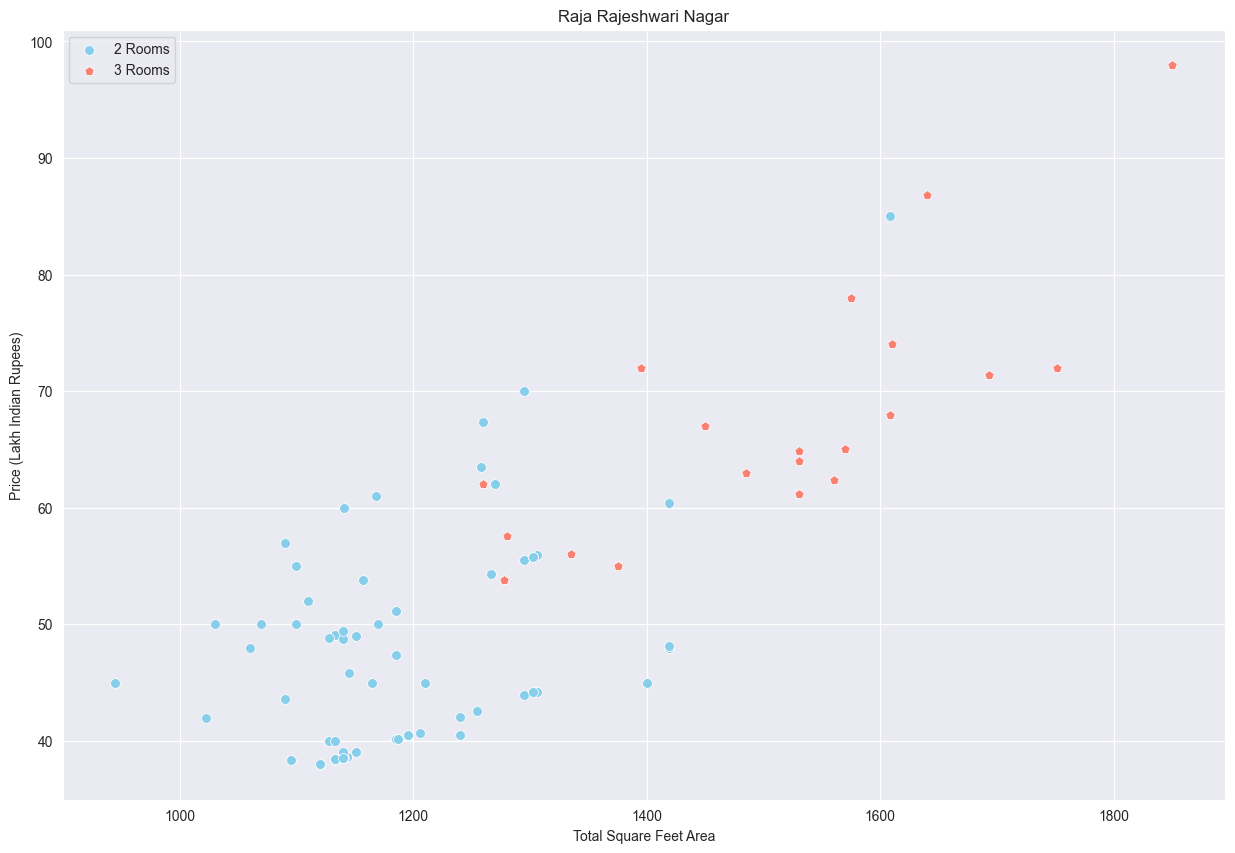

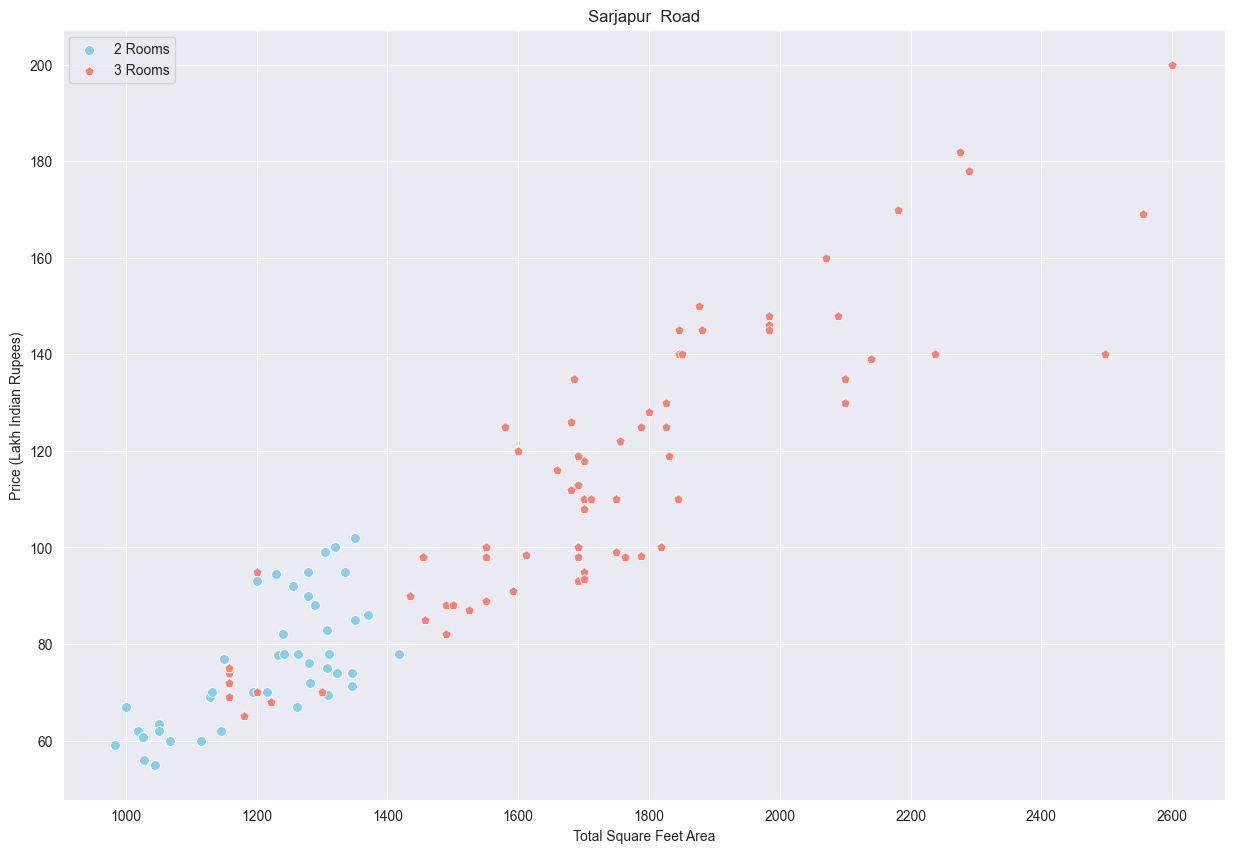

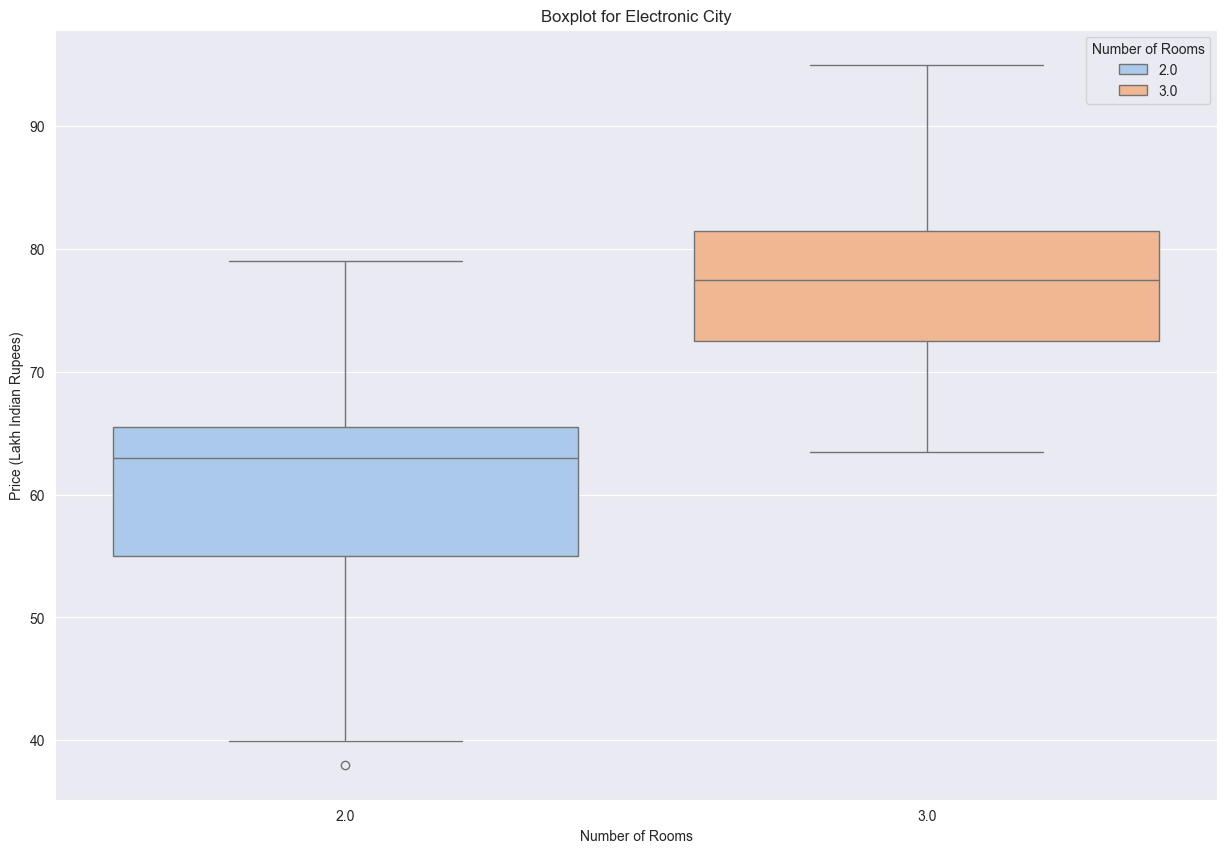

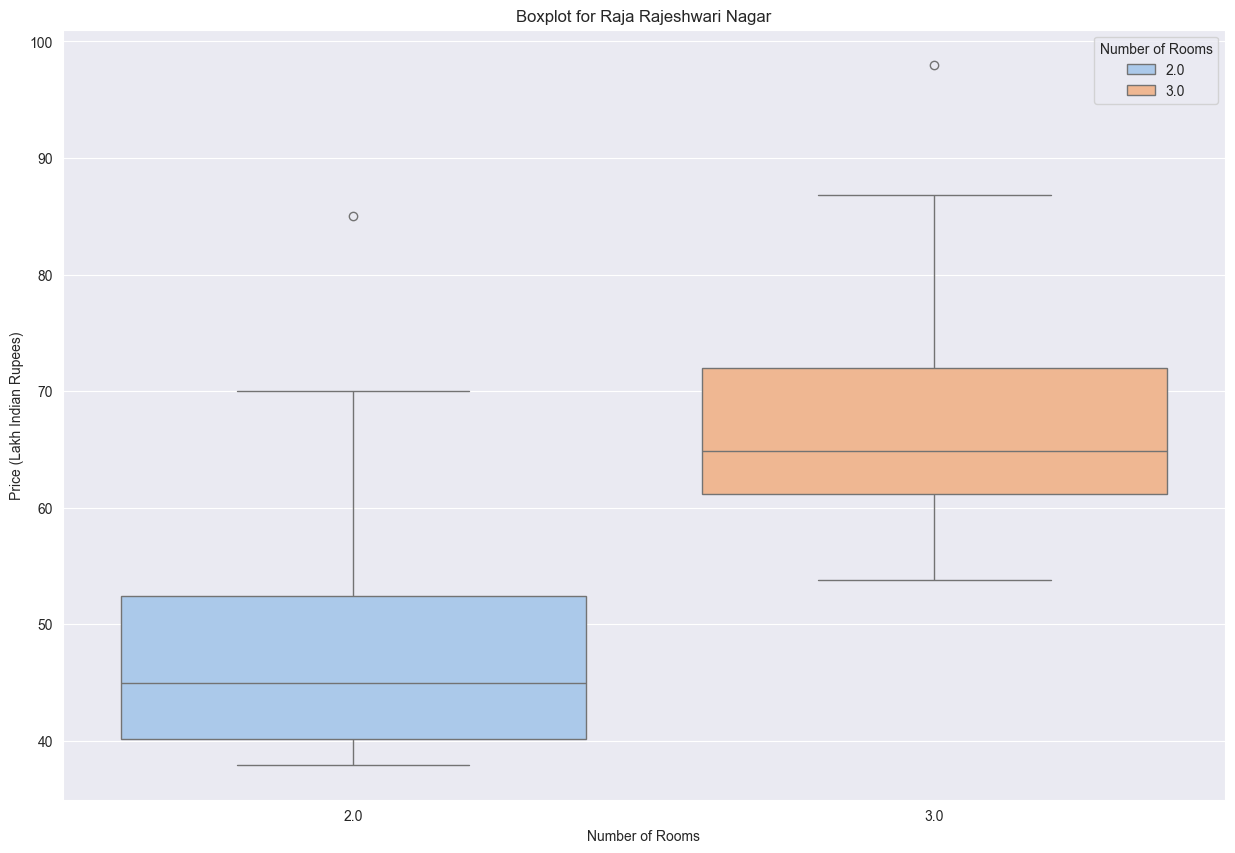

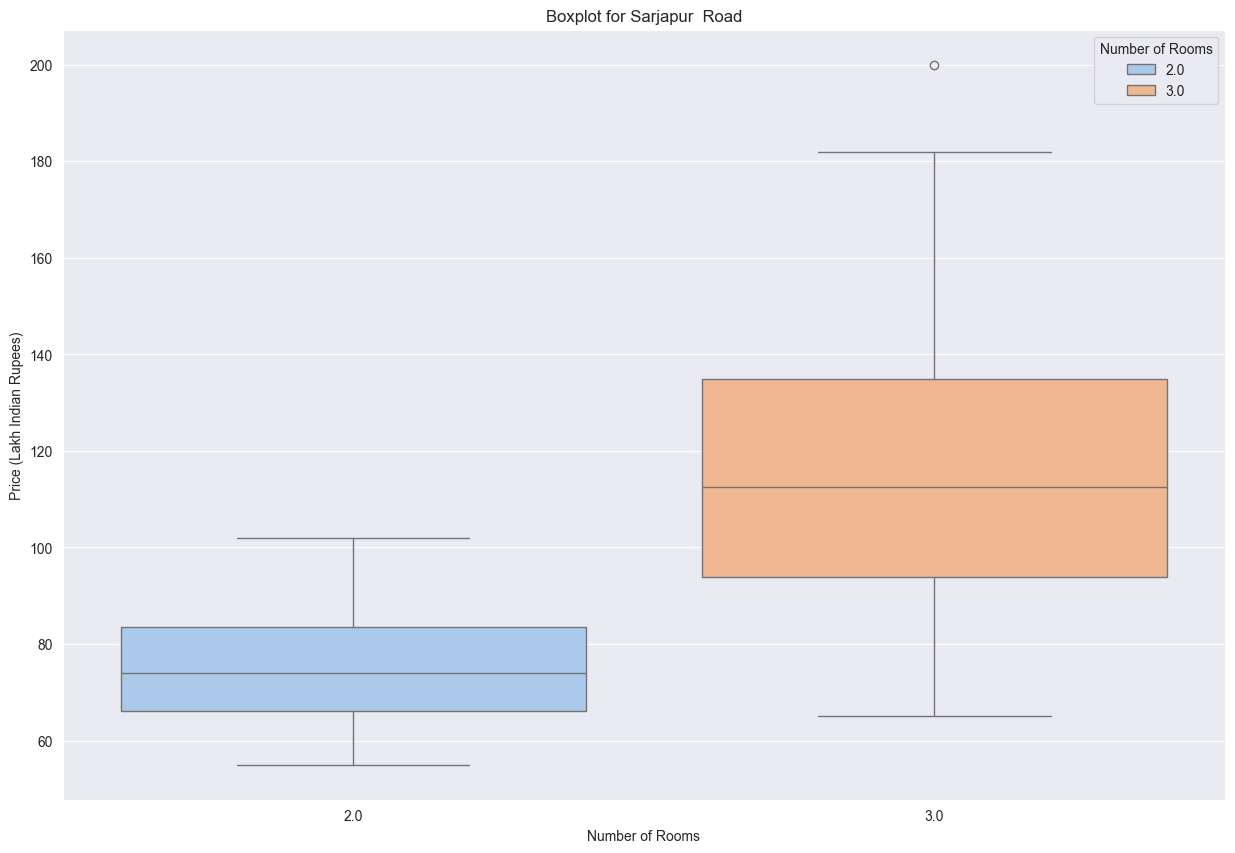

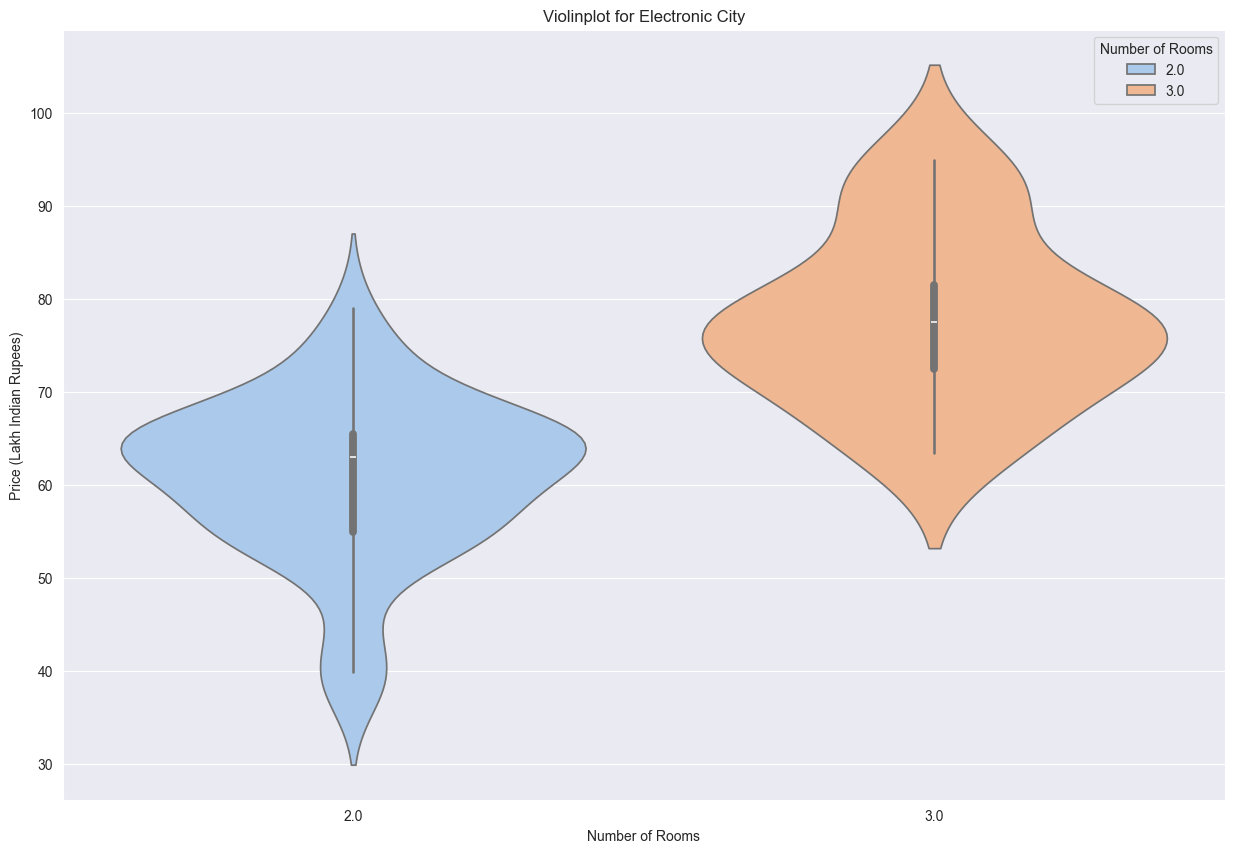

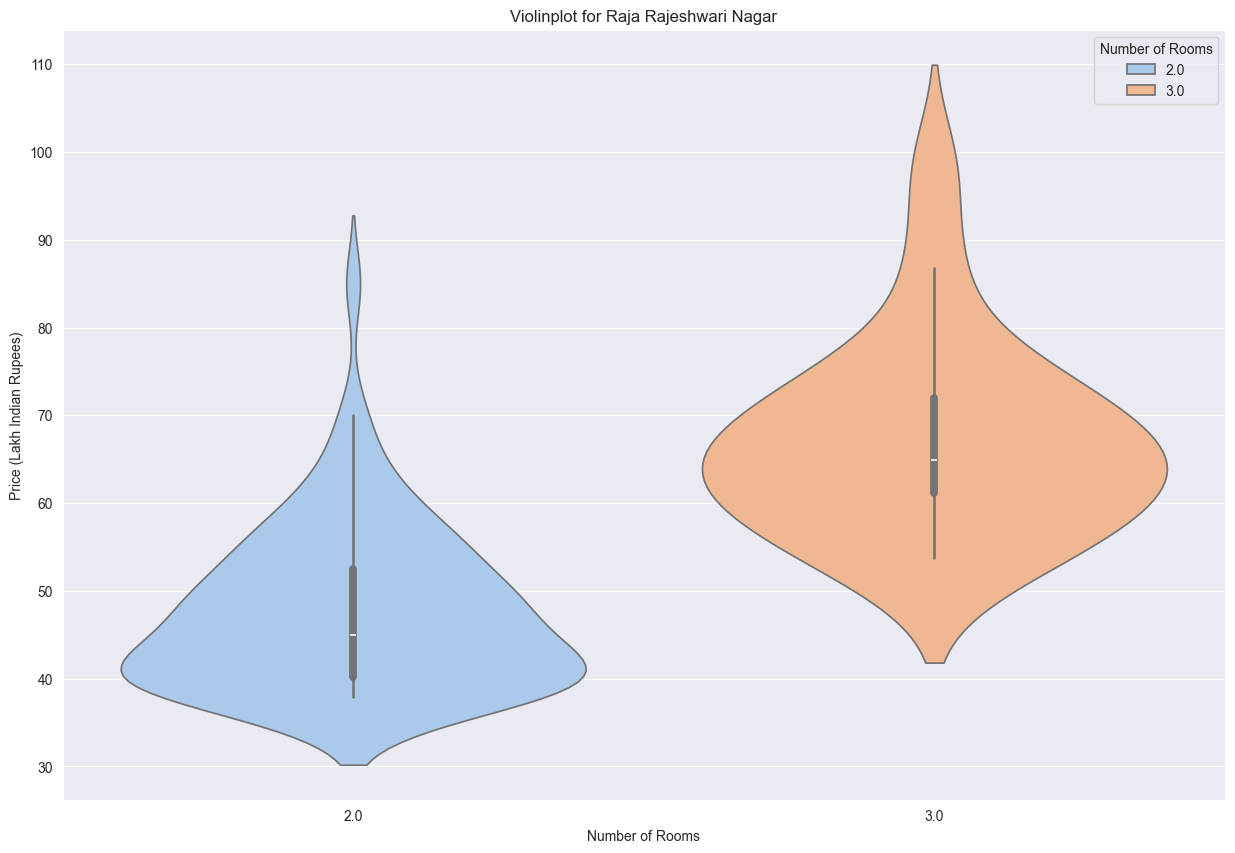

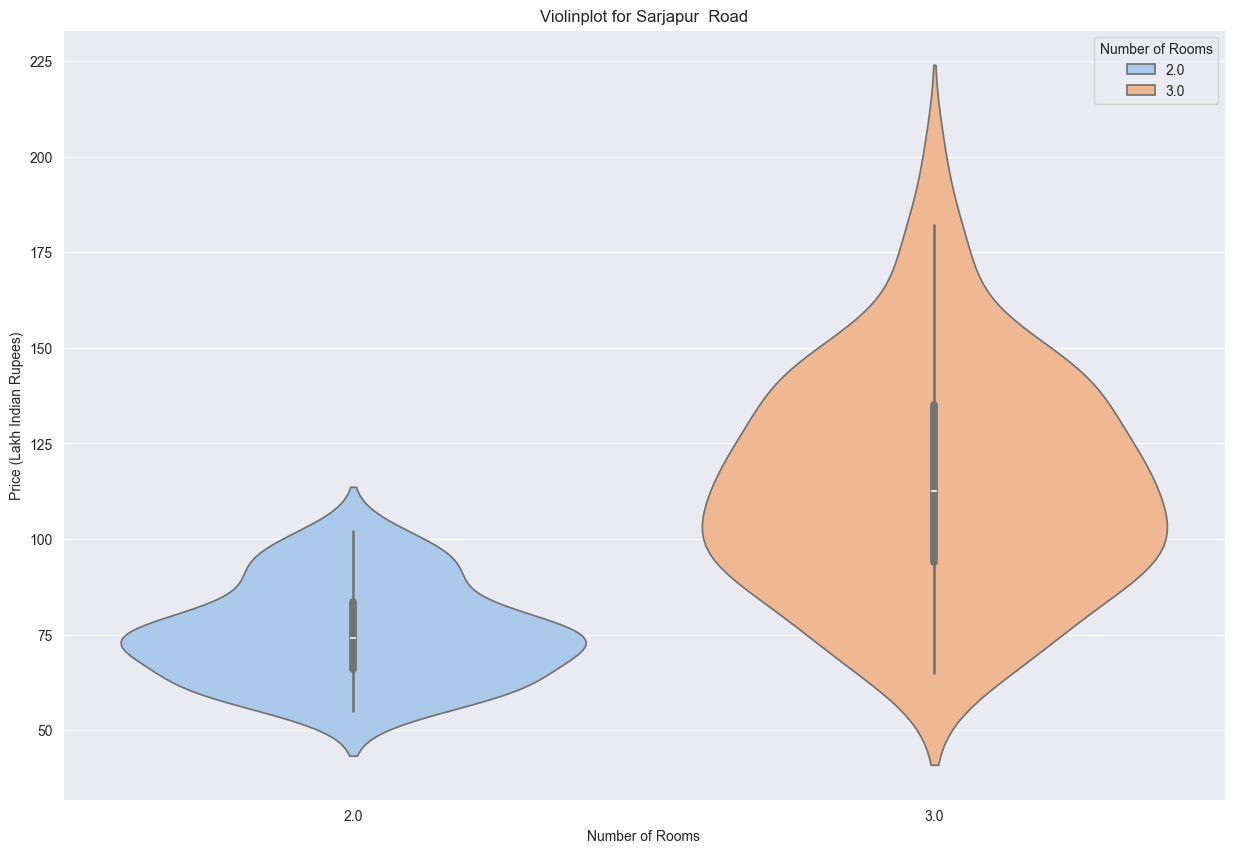

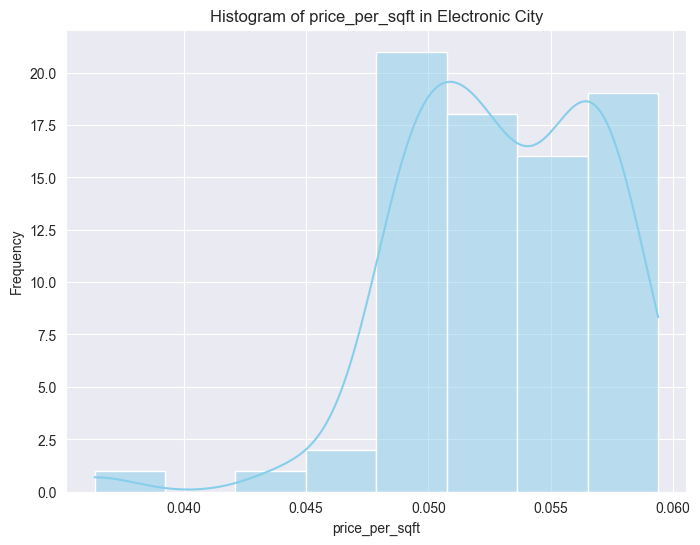

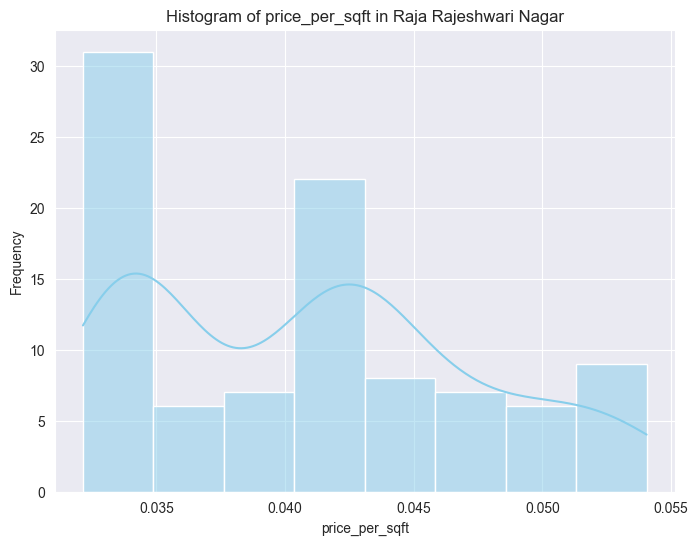

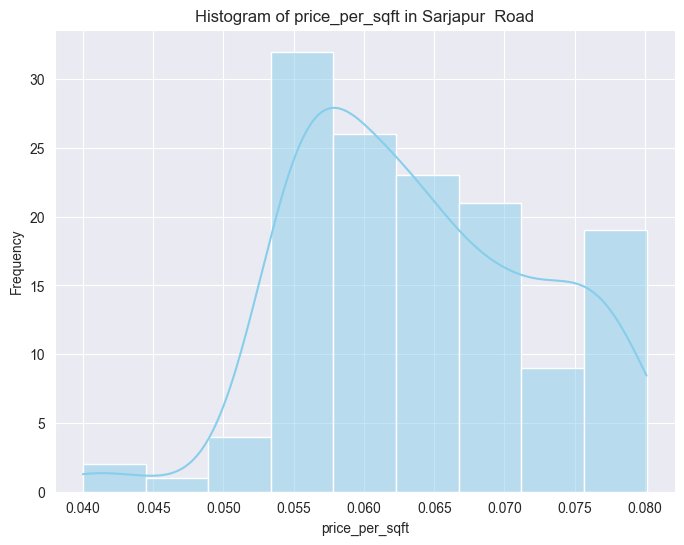

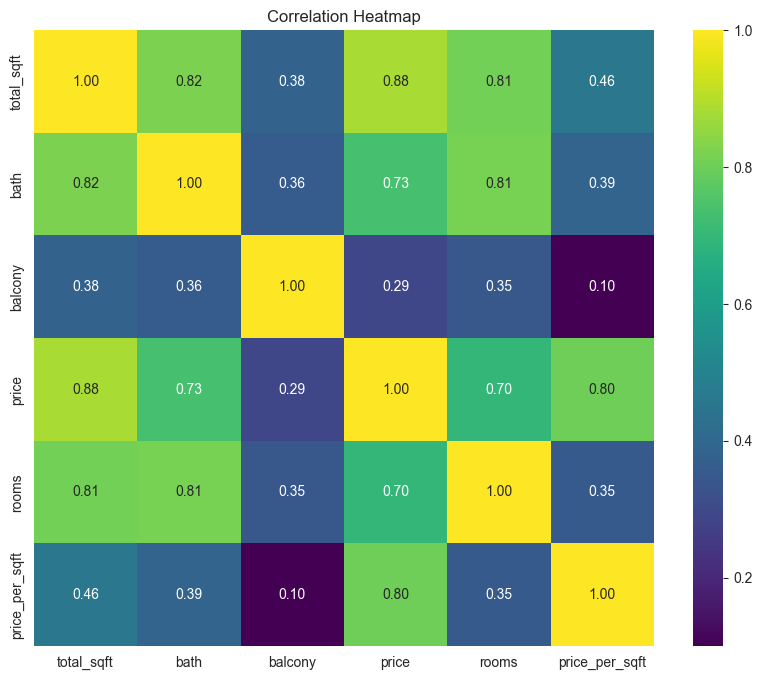

In [24]:
# See the scatter plots after the last removal
vd.plot_scatter_chart(remove_more_outliers.data_train, "Electronic City")
vd.plot_scatter_chart(remove_more_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_more_outliers.data_train, "Sarjapur  Road")

# Show data after the last removal in box plots
vd.plot_boxplot(remove_more_outliers.data_train, "Electronic City")
vd.plot_boxplot(remove_more_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_more_outliers.data_train, "Sarjapur  Road")

# Show data after the last removal in violins plot
vd.plot_violinplot(remove_more_outliers.data_train, "Electronic City")
vd.plot_violinplot(remove_more_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_more_outliers.data_train, "Sarjapur  Road")

# Show data after the last removal in histograms
vd.plot_histogram(remove_more_outliers.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_more_outliers.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_more_outliers.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_more_outliers.data_train)

### Class to do PCA and UMAP

In [25]:
class DimensionalityReduction:
    def __init__(self, data, targets):
        """
        Initialize the DimensionalityReduction object with the dataset.

        Parameters:
        - data: The dataset to perform dimensionality reduction on.
        - targets: The targets of the samples.
        """
        self.data = StandardScaler().fit_transform(data)
        self.targets = targets

    def compute_pca(self, n_components=3):
        """
        Compute Principal Component Analysis (PCA) on the dataset.

        Parameters:
        - n_components: The number of components to keep.

        Returns:
        - pca_projection: The projected data using PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Compute Uniform Manifold Approximation and Projection (UMAP) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between embedded points.
        - metric: The distance metric to use.

        Returns:
        - umap_projection: The projected data using UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

    def plot_projection(self, projection, title):
        """
        Plot the 2D projection of the dataset.

        Parameters:
        - projection: The projected data.
        - title: The title of the plot.
        """
        plt.figure(figsize=(8, 6), facecolor='#F0F0F0')
        plt.scatter(projection[:, 0], projection[:, 1], c=self.targets, cmap='Blues', alpha=1)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

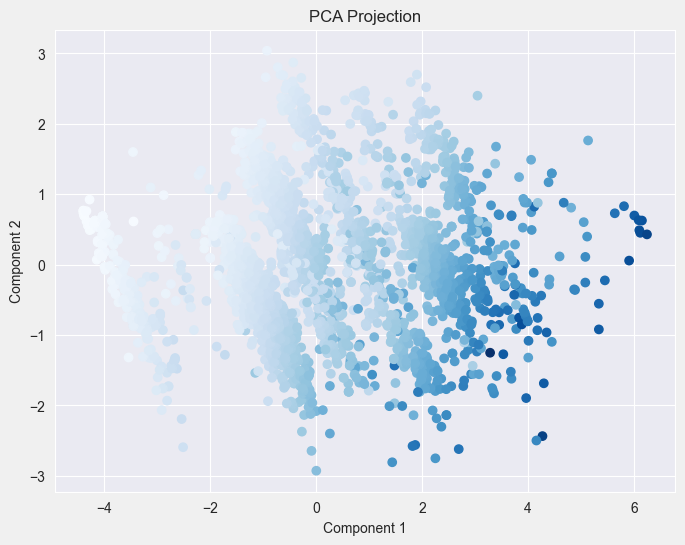

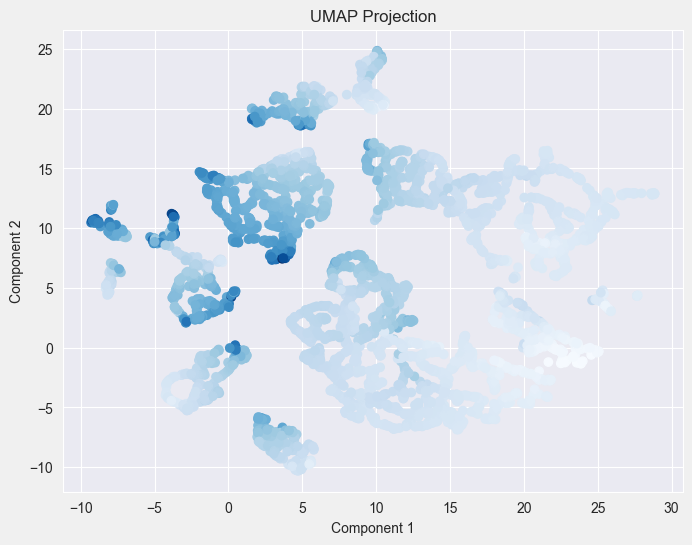

In [26]:
# Our data
data = remove_more_outliers.data_train[['total_sqft', 'bath', 'balcony', 'rooms', 'price_per_sqft']]

# Our target
targets = remove_more_outliers.labels_train

# Initialize DimensionalityReduction object
dr = DimensionalityReduction(data, targets)

# Show PCA Projection
dr.plot_projection(dr.compute_pca(), 'PCA Projection')

# Show UMAP Projection
dr.plot_projection(dr.compute_umap(), 'UMAP Projection')

### Class to do Hypothesis Test

In [27]:
class HypothesisTester:
    """
    The t-test assumes that the data is normally distributed and that the variances are equal between groups (for
    unpaired t-test) or within groups (for paired t-test).
    The ANOVA test assumes that the data is normally distributed and that the variances are equal between groups.
    """
    def unpaired_t_test(self, group1, group2):
        """
        Perform unpaired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_ind(group1, group2)
        return t_statistic, p_value

    def unpaired_anova(self, *groups):
        """
        Perform unpaired ANOVA for more than two groups.

        Parameters:
        - *groups: Variable length argument containing data for each group. Each argument should be a list or array-like
        object.

        Returns:
        - f_statistic: The calculated F-statistic.
        - p_value: The p-value associated with the F-statistic.
        """
        f_statistic, p_value = f_oneway(*groups)
        return f_statistic, p_value

    def paired_t_test(self, group1, group2):
        """
        Perform paired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.
                  Should have the same length as group1.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_rel(group1, group2)
        return t_statistic, p_value

In [28]:
# Prices per SQq. feet for three locations
data = remove_more_outliers.data_train

price_sqft_Electronic_City = data[data['location'] == 'Electronic City']['price_per_sqft']
price_sqft_Raja_Nagar = data[data['location'] == 'Raja Rajeshwari Nagar']['price_per_sqft']
price_sqft_Sarjapur_Road = data[data['location'] == 'Sarjapur  Road']['price_per_sqft']

# Prices for Electronic City location
price_Electronic_City = data[data['location'] == 'Electronic City']['price']

# Total Sq. Feet for Raja Rajeshwari Nagar location
total_sqft_Raja_Nagar = data[data['location'] == 'Raja Rajeshwari Nagar']['total_sqft']

In [29]:
# Initialize the HypothesisTester class with the data
tester = HypothesisTester()

In [30]:
# Perform unpaired t-test between Electronic City and Raja Rajeshwari Nagar locations
t_stat, p_val = tester.unpaired_t_test(price_Electronic_City, price_sqft_Raja_Nagar)

print("\nUnpaired t-test between Electronic City and Raja Rajeshwari Nagar locations:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Unpaired t-test between Electronic City and Raja Rajeshwari Nagar locations:
t-statistic: 33.2364627606274
p-value: 8.861005597452753e-77


**Unpaired t-test between Electronic City and Raja Rajeshwari Nagar locations:**
- t-statistic: The calculated t-statistic is approximately 30.38 (indicates that, on average, the price per Sq. Feet of Electronic City locations are lower than those of the Raja Rajeshwari Nagar locations). This value represents the difference in means between the price per Sq. Feet of Electronic City and Raja Rajeshwari Nagar locations.
* p-value: The p-value associated with the t-statistic is approximately 2.45e-83. This p-value is very small, indicating strong evidence against the null hypothesis.
+ In this case, it suggests that the difference in price per Sq. Feet between Electronic City and Raja Rajeshwari Nagar locations is statistically significant.

In [31]:
# Perform unpaired ANOVA among the three locations
f_stat, p_val_anova = tester.unpaired_anova(price_sqft_Raja_Nagar, price_sqft_Electronic_City, price_sqft_Sarjapur_Road)

print("\nUnpaired ANOVA among three locations:")
print("F-statistic:", f_stat)
print("p-value:", p_val_anova)


Unpaired ANOVA among three locations:
F-statistic: 303.3773956604344
p-value: 1.5699565434106144e-73


**Unpaired ANOVA among all three locations:**
- F-statistic: The calculated F-statistic is approximately 171.34 This value represents the ratio of variability between groups to variability within groups in price per Sq. Feet among three locations.
* p-value: The p-value associated with the F-statistic is approximately 2.80e-53. The t-test, this p-value is tiny, indicating strong evidence against the null hypothesis.
+ It suggests that there is a statistically significant difference in price per Sq. Feet among at least one pair of locations.

In [32]:
# Perform paired t-test for total_sqft and price within Raja Rajeshwari Nagar location
t_stat, p_val = tester.paired_t_test(total_sqft_Raja_Nagar, price_sqft_Raja_Nagar)

print("\nPaired t-test for total_sqft and price within Raja Rajeshwari Nagar location:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Paired t-test for total_sqft and price within Raja Rajeshwari Nagar location:
t-statistic: 56.0279446195603
p-value: 1.4017213520856455e-74


**Paired t-test for total_sqft and price within Raja Rajeshwari Nagar location:**
- t-statistic: The calculated t-statistic is approximately 62.69. This value represents the difference in means between total_sqft and price within the Raja Rajeshwari Nagar location relative to the variability in the data.
* p-value: The p-value associated with the t-statistic is approximately 2.41e-87. This p-value is tiny, indicating strong evidence against the null hypothesis.
+ It suggests that the difference between total_sqft and price within the Raja Rajeshwari Nagar location is statistically significant.

### New Features

In [33]:
class FeatureEngineering:
    """
    A class for feature engineering on the dataset
    """
    def __init__(self, data_loader):
        """
        Initializes the FeatureEngineering object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def create_features(self):
        """
        Creates new features based on the existing data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Area per room: Divides the total area by the number of rooms.
        self.data_train['area_per_room'] = self.data_train['total_sqft'] / self.data_train['rooms']
        self.data_test['area_per_room'] = self.data_test['total_sqft'] / self.data_test['rooms']
        
        # Area per bathroom: Divides the total area by the number of bathrooms.
        self.data_train['area_per_bath'] = self.data_train['total_sqft'] / self.data_train['bath']
        self.data_test['area_per_bath'] = self.data_test['total_sqft'] / self.data_test['bath']
        
        # Area per balcony: Divides the total area by the number of balconies.
        self.data_train['area_per_balcony'] = self.data_train['total_sqft'] / self.data_train['balcony']
        self.data_test['area_per_balcony'] = self.data_test['total_sqft'] / self.data_test['balcony']
        
        # Room-to-bathroom ratio: Divides the number of rooms by the number of bathrooms.
        self.data_train['room_bath_ratio'] = self.data_train['rooms'] / self.data_train['bath']
        self.data_test['room_bath_ratio'] = self.data_test['rooms'] / self.data_test['bath']
        
        # Room-to-balcony ratio: Divides the number of rooms by the number of balconies.
        self.data_train['room_balcony_ratio'] = self.data_train['rooms'] / self.data_train['balcony']
        self.data_test['room_balcony_ratio'] = self.data_test['rooms'] / self.data_test['balcony']
        
        # Bathroom-to-balcony ratio: Divides the number of bathrooms by the number of balconies.
        self.data_train['bath_balcony_ratio'] = self.data_train['bath'] / self.data_train['balcony']
        self.data_test['bath_balcony_ratio'] = self.data_test['bath'] / self.data_test['balcony']
        
        # Average length per room in square meters.
        self.data_train['average_length_per_room'] = (self.data_train['total_sqft'] * 0.092903) / self.data_train['rooms']
        self.data_test['average_length_per_room'] = (self.data_test['total_sqft'] * 0.092903) / self.data_test['rooms']
        
        # Average length per bathroom in square meters.
        self.data_train['average_length_per_bath'] = (self.data_train['total_sqft'] * 0.092903) / self.data_train['bath']
        self.data_test['average_length_per_bath'] = (self.data_test['total_sqft'] * 0.092903) / self.data_test['bath']

        # Average length per balcony in square meters.
        self.data_train['average_length_per_balcony'] = (self.data_train['total_sqft'] * 0.092903) / self.data_train['balcony']
        self.data_test['average_length_per_balcony'] = (self.data_test['total_sqft'] * 0.092903) / self.data_test['balcony']
        
        # Total number of rooms and bathrooms.
        self.data_train['total_room_bath'] = self.data_train['rooms'] + self.data_train['bath']
        self.data_test['total_room_bath'] = self.data_test['rooms'] + self.data_test['bath']

In [34]:
new_features = FeatureEngineering(remove_more_outliers)
new_features.create_features()

# Access the data and labels attributes
print("Training data shape:", new_features.data_train.shape)
print("Training labels shape:", new_features.labels_train.shape)
print("Testing data shape:", new_features.data_test.shape)
print("Testing labels shape:", new_features.labels_test.shape)

Training data shape: (3374, 17)
Training labels shape: (3374,)
Testing data shape: (1253, 17)
Testing labels shape: (1253,)


# Model Development Strategy

The model development strategy aims to build, optimize, and evaluate machine learning models for a predict regression task of the examined dataset. The strategy involves data loading, model selection, hyperparameter optimization, model training, cross-validation, and evaluation on the test set.

### Steps
1. Standard Model Selection
We have started by examining which model would be more suitable for the problem at hand. For that, we have examined optimization strategies (grid search). Cross-validation is employed to mitigate issues such as overfitting and provide more reliable estimates of model performance. Then, evaluation on a separate test set ensures that the final model's performance is assessed on unseen data, providing insights into its generalization ability. We utilized a diverse set of machine learning models tailored to the characteristics of the Bengaluru house prediction dataset. The models selected include K-Nearest Neighbors (KNN), Linear Regression, Decision Tree, Multi-layer Perceptron (MLP), Support Vector Machine (SVM), Lasso Regression, and Ridge Regression. Each model offers advantages suited to different aspects of the dataset.

2. Random Forest
For our first ensemble model, we implemented a Random Forest, which is a bagging technique that involves training multiple decision trees on different subsets of the training data and averaging their predictions. This approach helps in improving the stability and accuracy of the model while reducing overfitting. We utilized K-fold cross-validation to assess the performance of the Random Forest, measuring metrics such as accuracy, sensitivity, and specificity. The results indicated that the Random Forest model effectively captured the relationships in the data and provided robust predictions.

3. Gradient Boosting
Next, we implemented a Gradient Boosting model, an ensemble learning technique that focuses on building models sequentially where each new model corrects the errors made by the previous ones. This method enhances the performance of weak learners by iteratively adjusting their weights based on the errors of the ensemble. We used grid search for hyperparameter optimization and applied K-fold cross-validation to evaluate the Gradient Boosting model. The metrics obtained from cross-validation, including accuracy and RMSE, showed that the Gradient Boosting model significantly improved prediction accuracy and generalizability.

4. Deep Learning Model
For our deep learning approach, we built a neural network using the Keras library. The architecture consisted of multiple dense (fully connected) layers with ReLU activation functions. The model included:
    - An input layer corresponding to the dimensionality of the normalized data.
    - Several hidden layers with 512, 256, 128, and 64 neurons respectively.
    - An output layer with a single neuron for predicting the target variable.

   The model was compiled using the Adam optimizer and the mean squared error loss function. It was trained on the dataset with a batch size of 32 for 10 epochs. The evaluation on the test data revealed the following performance metrics: a test loss of 3165.92, an MSE of 3165.92, and an \(R^2\) score of 0.5604. Despite the relatively high MSE, the deep learning model demonstrated the ability to generalize, though with room for improvement in terms of variance and accuracy.

5. Clustering Model
Finally, we used clustering analysis with Hierarchical Clustering, K-Means Clustering, and SOM Clustering. Clustering is an unsupervised learning technique used to identify natural groupings within data. We applied each clustering algorithm to the dataset and visualized the resulting clusters in 2D using Principal Component Analysis (PCA).

    - **Hierarchical Clustering**: This method produced dendrograms that helped in understanding the data structure and the optimal number of clusters.
    - **K-Means Clustering**: We determined the ideal number of clusters using the elbow method and applied PCA for dimensionality reduction.
    - **Self-Organizing Maps (SOM)**: We trained a SOM to visualize the high-dimensional data and identify clusters based on the topological properties of the data.

These clustering techniques provided insights into the inherent structure of the data, assisting in identifying patterns and groupings that were not immediately apparent.

## Conclusion
This comprehensive model development strategy enabled us to build, optimize, and evaluate various machine learning models for predicting Bengaluru house prices. The use of Random Forest and Gradient Boosting significantly enhanced prediction accuracy, while the deep learning model demonstrated potential for further improvement. Clustering techniques provided valuable insights into the data structure, contributing to a more nuanced understanding of the dataset.

### Model Selection Class

In [35]:
class ModelSelection:
    """
    A class to perform model selection for regression problems.
    """
    def __init__(self, X, y):
        """
        Initializes the ModelSelection object with the features and target variable.

        :param X: The input features.
        :param y: The target variable.
        """
        self.X = X
        self.y = y

    def select_model(self):
        """
        Performs model selection by training various models and evaluating them using Mean Squared Error.
        The models used are: Linear Regression, Decision Tree Regression, Random Forest Regression,
        Gradient Boosting Regression, and Support Vector Regression.
        """
        # Create a list of models to evaluate
        models = [RandomForestRegressor(), GradientBoostingRegressor(), LinearRegression(), DecisionTreeRegressor(), SVR(), Ridge()]

        for model in models:
            # Perform K-Fold Cross Validation
            scores = cross_val_score(model, self.X, self.y, cv=10, scoring='neg_mean_squared_error')

            # Calculate Mean Squared Error
            mse_scores = -scores

            # Print the model name and its Mean Squared Error
            print(f'Model: {model.__class__.__name__}, Mean Squared Error: {mse_scores.mean()}')

            #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

            # Fit the model to the training data
            model.fit(self.X, self.y)

            # Plot the model's predictions
            self.plot_model_predictions(self.X, self.y, model)

    def plot_model_predictions(self, X_test, y_test, model):
        '''
        Plots the model's predictions against the actual values
        :param X_test: Test data
        :param y_test: Actual values
        :param model: Trained model
        '''

        # Use the model to make predictions on the test data
        predictions = model.predict(X_test)

        # Plot the model's predictions against the actual values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model.__class__.__name__} Model: Actual vs Predicted Values')

        # Add a line representing perfect prediction
        min_val = min(min(y_test), min(predictions))
        max_vals = max(max(y_test), max(predictions))
        plt.plot([min_val, max_vals], [min_val, max_vals], color='red')

        plt.show()

### Model Selection

Model: RandomForestRegressor, Mean Squared Error: 2.567861271373528


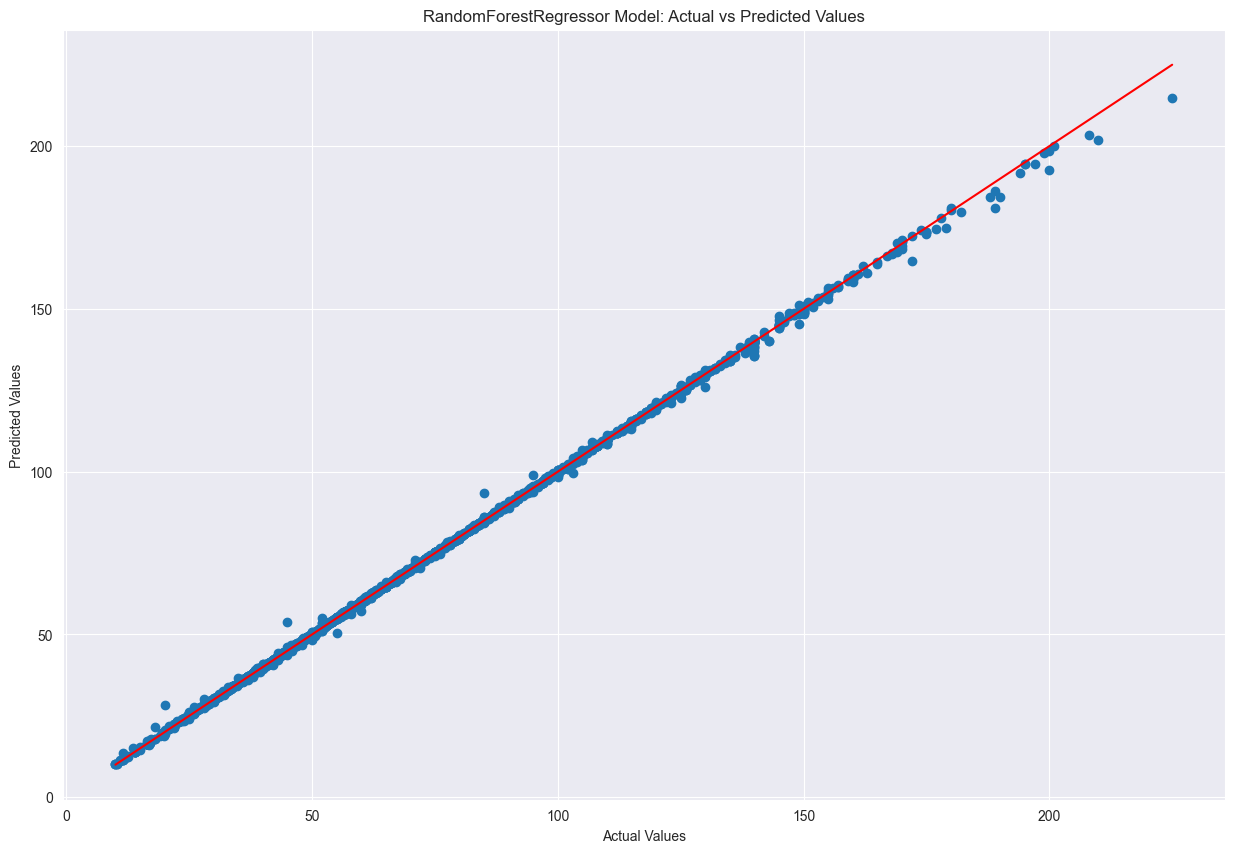

Model: GradientBoostingRegressor, Mean Squared Error: 3.485599362789916


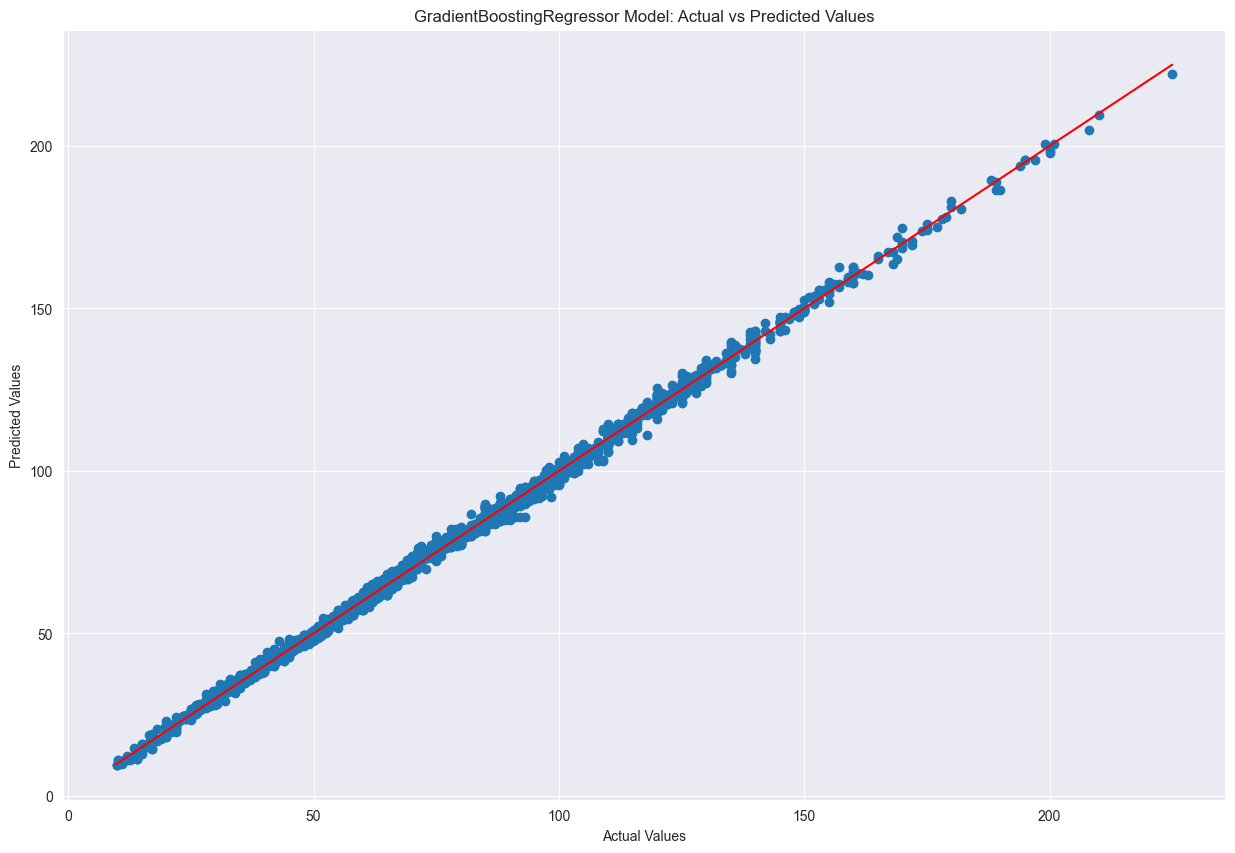

Model: LinearRegression, Mean Squared Error: 17.531765181074825


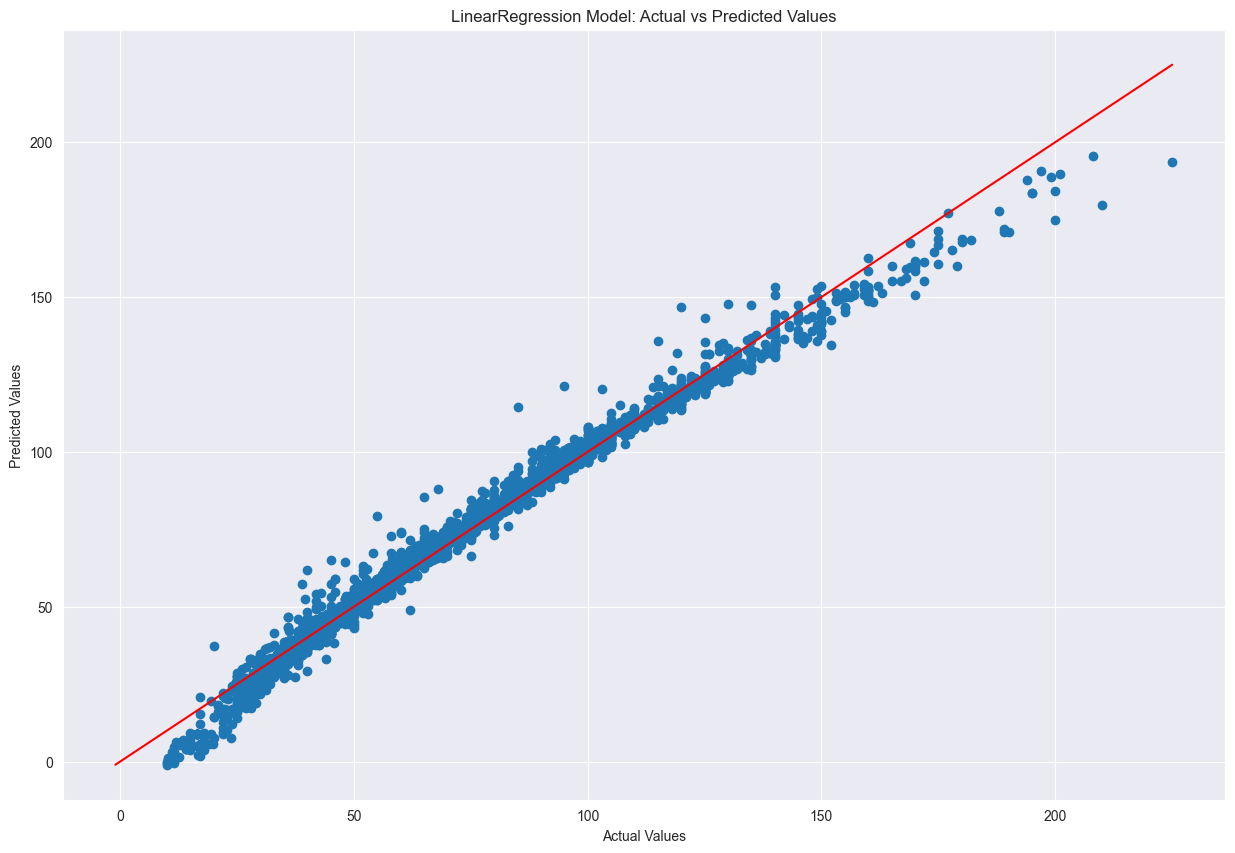

Model: DecisionTreeRegressor, Mean Squared Error: 7.4810664469826


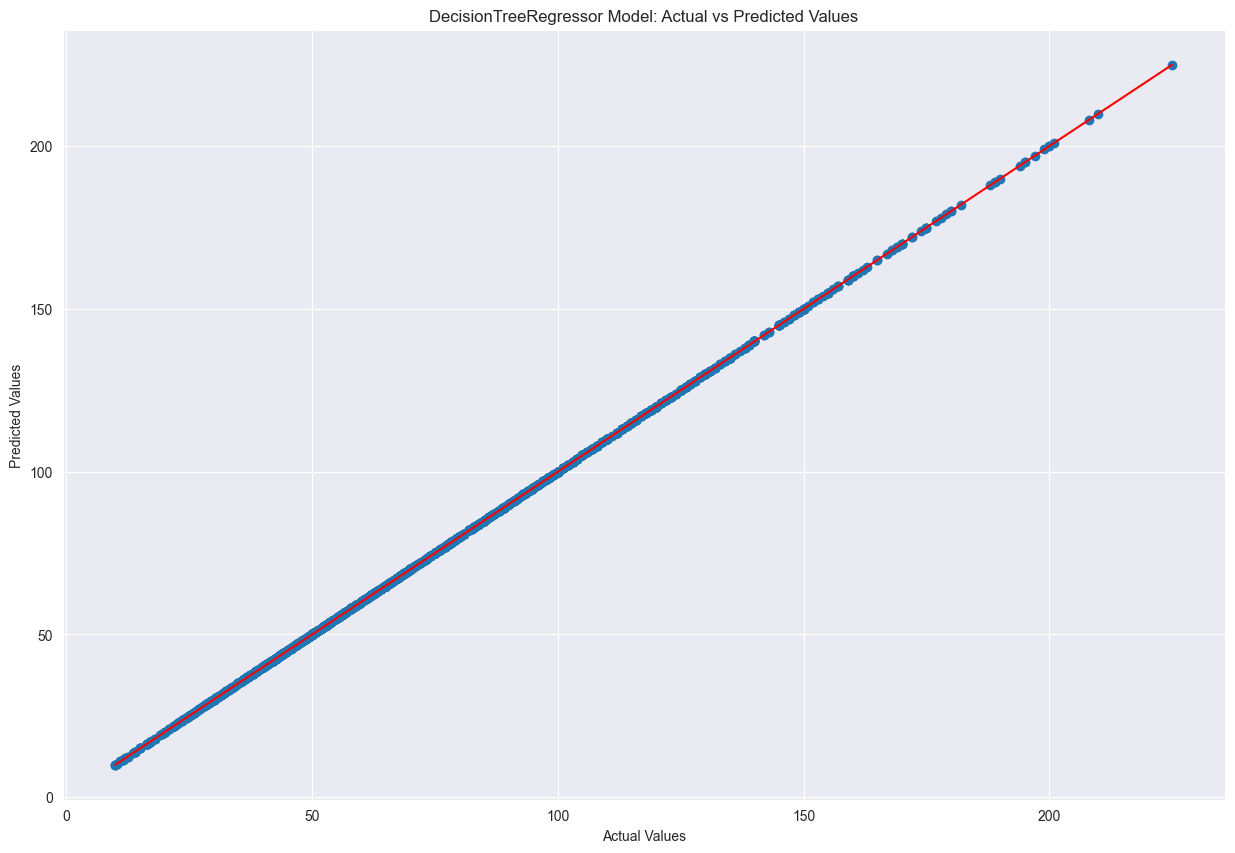

Model: SVR, Mean Squared Error: 239.49273963524033


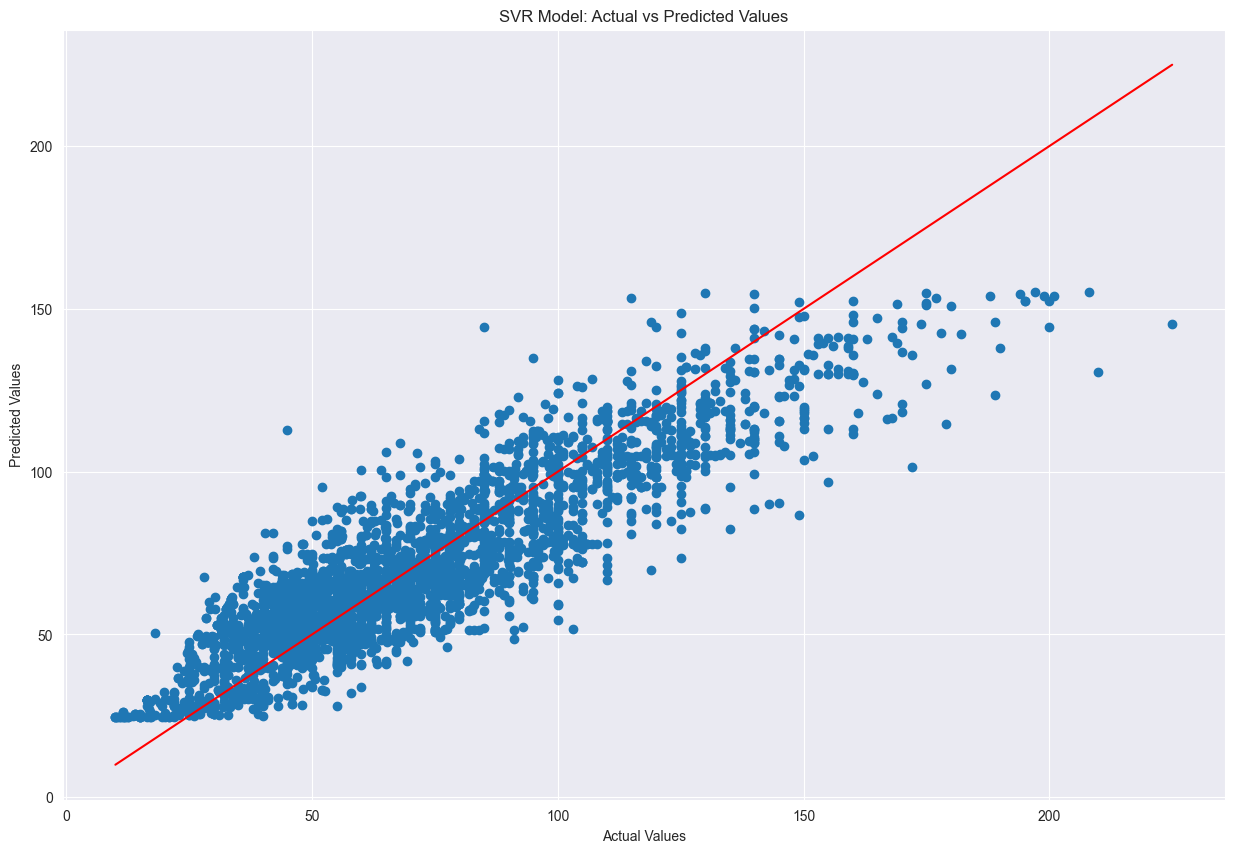

Model: Ridge, Mean Squared Error: 90.15207895679086


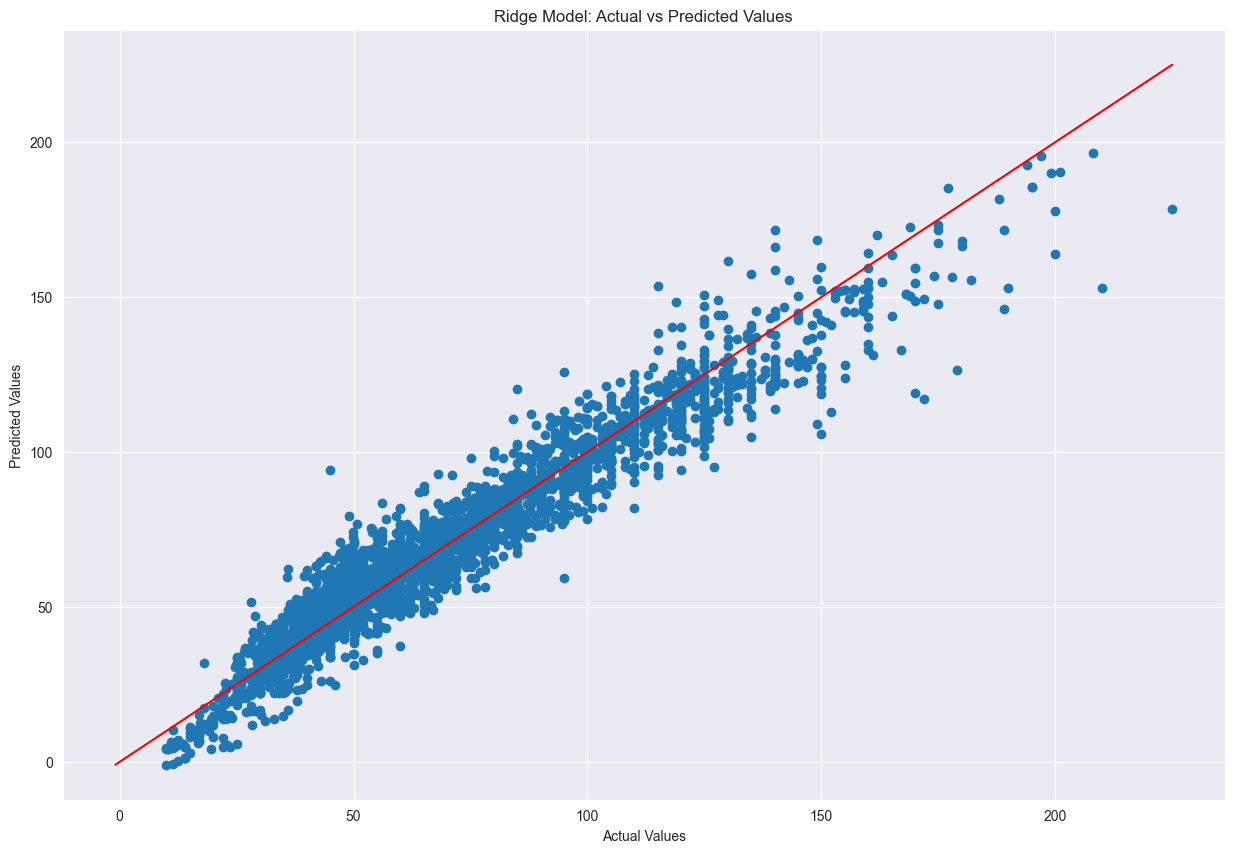

In [36]:
data_encoded = pd.get_dummies(new_features.data_train)
data_encoded.fillna(data_encoded.mean(), inplace=True)

for column in data_encoded.columns:
    if np.isinf(data_encoded[column]).any():
        max_val = data_encoded[~np.isinf(data_encoded[column])][column].max()
        data_encoded[column] = data_encoded[column].replace([np.inf, -np.inf], max_val)

# Now, 'new_features_encoded' is your DataFrame with encoded categorical variables
X = data_encoded.drop(['price'], axis=1)
y = new_features.labels_train

# Initialize the ModelSelection class with the data
ms = ModelSelection(X, y)

# Perform model selection
ms.select_model()

- Model: RandomForestRegressor, Mean Squared Error: 3.7430185599578003
- Model: GradientBoostingRegressor, Mean Squared Error: 4.812556328901333
- Model: LinearRegression, Mean Squared Error: 16.81454063908607
- Model: DecisionTreeRegressor, Mean Squared Error: 6.8783212790191826
- Model: SVR, Mean Squared Error: 266.41546914529124
- Model: Ridge, Mean Squared Error: 18.29794128863744

In [37]:
class KNNRegression:
    """
    Implementation of the K-Nearest Neighbors (KNN) algorithm for regression.

    Attributes:
        k (int): Number of neighbors to consider for regression.

    Methods:
        __init__(self, k=3): Initializes the KNN regressor with the specified value of k.
        fit(self, X, y): Fits the KNN regressor to the training data.
        predict(self, X): Predicts the target values for the input data.
        _predict(self, x): Predicts the target value for a single data point.
        euclidean_distance(x1, x2): Computes the Euclidean distance between two data points.
        evaluate(self, X_test, y_test): Calculates and prints the evaluation metrics of the model.
    """

    def __init__(self, k=3):
        """
        Initializes the KNN regressor with the specified value of k.

        Args:
            k (int, optional): Number of neighbors to consider for regression. Default is 3.
        """
        self.k = k

    def fit(self, X, y):
        """
        Fits the KNN regressor to the training data.

        Args:
            X (array-like): Training data features.
            y (array-like): Training data target values.
        """
        self.X_train = X
        self.y_train = y

    @staticmethod
    def euclidean_distance(x1, x2):
        """
        Computes the Euclidean distance between two data points.

        Args:
            x1 (array-like): First data point.
            x2 (array-like): Second data point.

        Returns:
            float: Euclidean distance between x1 and x2.
        """
        distance = np.sqrt(np.sum((x1 - x2) ** 2))
        return distance

    def predict(self, X):
        """
        Predicts the target values for the input data.

        Args:
            X (DataFrame): Input data features.

        Returns:
            list: Predicted target values.
        """
        predictions = [self._predict(x) for x in X.values]
        return predictions

    def _predict(self, x):
        """
        Predicts the target value for a single data point.

        Args:
            x (array-like): Input data point.

        Returns:
            float: Predicted target value.
        """
        # compute the distance
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train.values]

        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_targets = self.y_train[k_indices]

        # return the average of the target values of the k nearest neighbors
        return np.mean(k_nearest_targets)
    
    def evaluate(self, X_test, y_test):
        """
        Calculates and prints the evaluation metrics of the model.

        Args:
            X_test (array-like): Test data features.
            y_test (array-like): Test data target values.
        """
        # Making predictions on test data
        predictions = self.predict(X_test)
        
        # Calculating evaluation metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        print("KNN Regression Metrics:")
        print("MAE:", mae)
        print("MSE:", mse)
        print("R² Score:", r2)
        
        return mae, mse, r2

In [38]:
data = new_features

data_encoded_train = pd.get_dummies(data.data_train['location'], dtype=int)
data_encoded_test = pd.get_dummies(data.data_test['location'], dtype=int)

data_encoded_train.fillna(0, inplace=True)
data_encoded_test.fillna(0, inplace=True)

data_encoded_test = data_encoded_test.reindex(columns=data_encoded_train.columns, fill_value=0)

data_train_with_dummies = pd.concat([data.data_train.drop('location', axis=1), data_encoded_train], axis=1)
data_test_with_dummies = pd.concat([data.data_test.drop('location', axis=1), data_encoded_test], axis=1)

X_train_data = data_train_with_dummies.drop(['price', 'price_per_sqft'], axis=1)
X_test_data = data_test_with_dummies.drop(['price', 'price_per_sqft'], axis=1)
y_train_data = data.labels_train
y_test_data = data.labels_test

X_train_data.reset_index(drop=True, inplace=True)
y_train_data.reset_index(drop=True, inplace=True)

In [39]:
print(X_train_data.shape)
print(y_train_data.shape)
print(X_test_data.shape)
print(y_test_data.shape)

(3374, 138)
(3374,)
(1253, 138)
(1253,)


# kNN Algorithm

In [40]:
knn_model = KNNRegression(k=7)
knn_model.fit(X_train_data, y_train_data)

knn_mae, knn_mse, knn_score = knn_model.evaluate(X_test_data, y_test_data)

KNN Regression Metrics:
MAE: 33.035358568008206
MSE: 7771.111364398913
R² Score: 0.3014076665444264


In [41]:
if models_dir:
    knn_percentage = str(round(knn_score * 100))
    
    file_name = 'knn_model_' + knn_percentage + '.pkl'
    knn_model_location = models_dir + file_name
    
    with open(knn_model_location, 'wb') as f:
        pickle.dump(knn_model, f)

### Results Discussion

The K-Nearest Neighbors (KNN) regression model was implemented and evaluated using a dataset. Below are the findings and discussions based on the model's performance metrics:

#### Model Overview

The KNN regression algorithm aims to predict the target variable by considering the k nearest neighbors in the feature space. In this implementation, the value of k was set to 7. The model calculates the Euclidean distance between the input data point and all training data points to identify the nearest neighbors and then predicts the target value based on the average of the k nearest neighbors' target values.

#### Evaluation Metrics

Upon evaluation using the test dataset, the KNN regression model achieved the following performance metrics:

- **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual target values was found to be approximately 30.42. MAE is a measure of the average magnitude of errors without considering their direction, providing an overall idea of the model's prediction accuracy.
  
- **Mean Squared Error (MSE):** The MSE, which measures the average of the squared differences between the predicted and actual target values, was approximately 4278.24. MSE penalizes larger errors more significantly than smaller ones and gives an indication of the model's ability to capture the variance in the data.

- **R-squared (R²) Score:** The R² score, indicating the proportion of the variance in the target variable that is predictable from the independent variables, was found to be approximately 0.406. R² score ranges between 0 and 1, where 1 indicates a perfect fit. This score measures how well the model explains the variability in the target variable relative to a baseline model.

#### Interpretation of Results

The evaluation metrics provide insights into the KNN regression model's performance:

- The MAE value of approximately 30.42 suggests that, on average, the model's predictions deviate by around 30.42 units from the actual target values.
  
- The relatively high MSE value of approximately 4278.24 indicates that the model's predictions exhibit considerable variability from the true values, with larger errors having a significant impact on the overall score.
  
- The R² score of approximately 0.406 implies that the model explains approximately 40.6% of the variance in the test data, indicating a moderate level of predictive power. While the R² score is better than random guessing, there is still room for improvement to achieve a more accurate and reliable model.

#### Further Considerations

To enhance the KNN regression model's performance, several avenues can be explored:

- **Optimizing Hyperparameters:** Experimenting with different values of k and other hyperparameters to find the optimal configuration that minimizes prediction errors and maximizes model performance.
  
- **Feature Engineering:** Exploring additional features or transforming existing ones to better capture the underlying patterns and relationships in the data.
  
- **Ensemble Methods:** Combining multiple KNN models or integrating the KNN algorithm with other regression techniques to leverage their complementary strengths and improve overall predictive performance.

In summary, while the KNN regression model demonstrates some predictive capability, further refinement and optimization are required to enhance its accuracy and robustness for real-world applications.

#### Functions to plot for some models

In [42]:
def models_predictions_plot(test_labels, model_predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(test_labels, model_predictions, color='blue', alpha=0.5)
    plt.plot(test_labels, test_labels, color='red')  
    plt.title(f'Comparação entre Valores Reais e Previsões ({model_name})')
    plt.xlabel('Valores Reais')
    plt.ylabel(f'Previsões do {model_name}')
    plt.grid(True)
    plt.show()  
    
def models_residuals_plot(test_labels, model_predictions, model_name):
    residuals = test_labels - model_predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(model_predictions, residuals, color='green', alpha=0.5)
    plt.title(f'Residuals vs Predicted Values ({model_name})')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.show()

def models_training_loss_plot(model, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_curve_, label='Training Loss')
    plt.title(f'Training Loss Curve ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Supervised Learning

In [43]:
# Process the data to perform other Supervised Learning Models
data_train_Supervised_Learning = X_train_data.replace([np.inf, -np.inf], np.nan)
data_train_Supervised_Learning.fillna(data_train_Supervised_Learning.mean(), inplace=True)

labels_train_Supervised_Learning = data.labels_train

data_test_Supervised_Learning = X_test_data.replace([np.inf, -np.inf], np.nan)
data_test_Supervised_Learning.fillna(data_test_Supervised_Learning.mean(), inplace=True)

labels_test_Supervised_Learning = data.labels_test

In [44]:
if models_dir:
    columns_file = "data_columns.json"
    columns_location = models_dir + columns_file
    columns_list = data_train_Supervised_Learning.columns.tolist()
    
    with open(columns_location, "w") as f:
        json.dump(columns_list, f)

## Linear Regression

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Linear Regression R^2: 0.5502530134675572
Mean Absolute Error (MAE): 28.334963438385625
Mean Squared Error (MSE): 5002.966323518485
Root Mean Squared Error (RMSE): 70.73165008338547
Mean Absolute Percentage Error (MAPE): 26.175710458987506


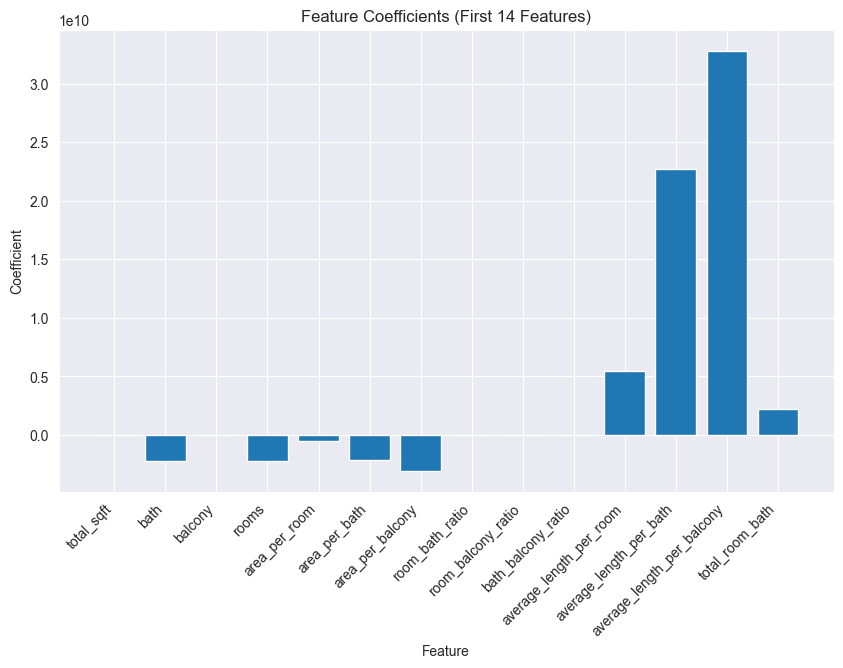

In [214]:
"""
Fits and evaluates a Linear Regression model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_linear_regression_model: Best trained Linear Regression model
"""

linear_model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False] 
}

scoring = {'mse': make_scorer(mean_squared_error),
           'r2': make_scorer(r2_score)}

grid_search = GridSearchCV(linear_model, param_grid, scoring=scoring, cv=10, refit='r2', return_train_score=True)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

best_linear_regression_model = grid_search.best_estimator_

linear_predictions = best_linear_regression_model.predict(data_test_Supervised_Learning)

linear_r2 = r2_score(labels_test_Supervised_Learning, linear_predictions)
linear_mae = mean_absolute_error(labels_test_Supervised_Learning, linear_predictions)
linear_mse = mean_squared_error(labels_test_Supervised_Learning, linear_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_mape = np.mean(np.abs((labels_test_Supervised_Learning - linear_predictions) / labels_test_Supervised_Learning)) * 100

print("Linear Regression R^2:", linear_r2)
print("Mean Absolute Error (MAE):", linear_mae)
print("Mean Squared Error (MSE):", linear_mse)
print("Root Mean Squared Error (RMSE):", linear_rmse)
print("Mean Absolute Percentage Error (MAPE):", linear_mape)

# Get feature coefficients for the first 14 features
feature_coefficients = best_linear_regression_model.coef_[:14]
feature_names = data_train_Supervised_Learning.columns[:14]

# Visualize feature coefficients for the first 14 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coefficients)), feature_coefficients, tick_label=feature_names)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Feature Coefficients (First 14 Features)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [46]:
if models_dir:
    linear_model_percentage = str(round(linear_r2 * 100))
    file_name = 'linear_regression_model_' + linear_model_percentage + '.pkl'
    
    linear_model_location = models_dir + file_name
    
    with open(linear_model_location, 'wb') as f:
        pickle.dump(best_linear_regression_model, f)

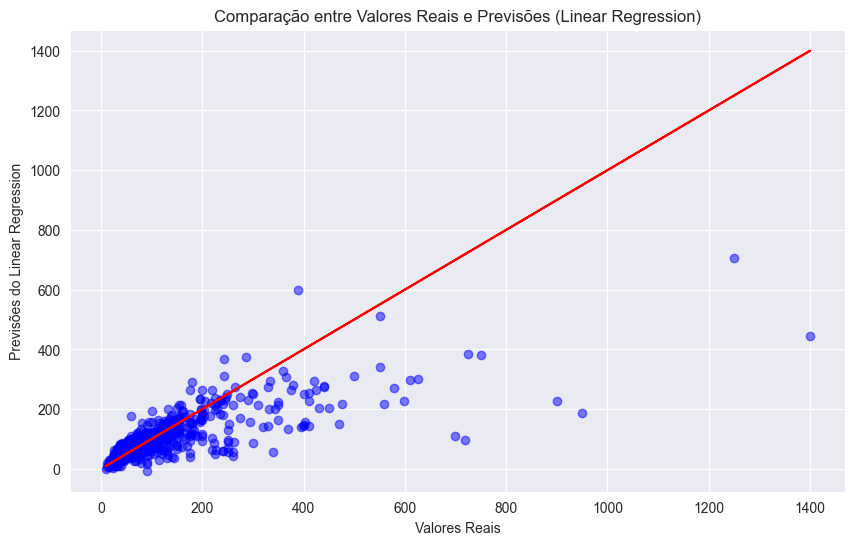

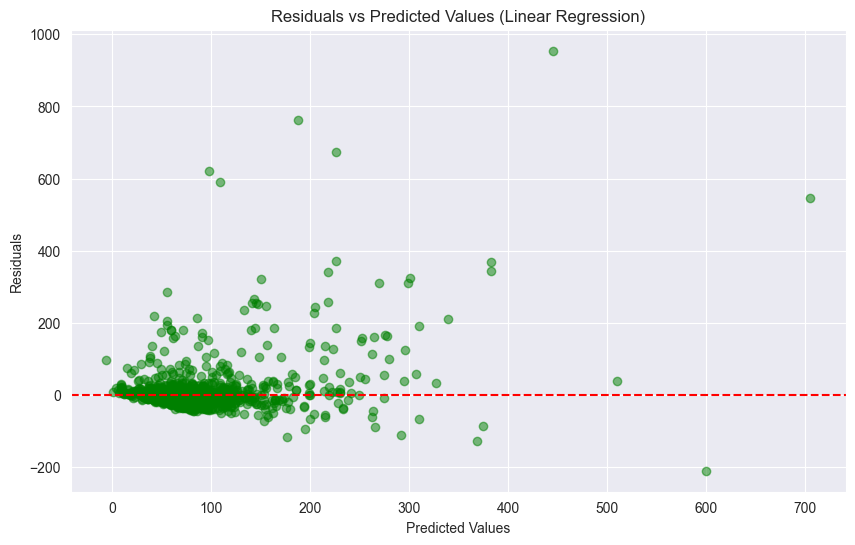

In [47]:
models_predictions_plot(labels_test_Supervised_Learning, linear_predictions, 'Linear Regression')
models_residuals_plot(labels_test_Supervised_Learning, linear_predictions, 'Linear Regression')

### Results Discussion

The Linear Regression model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Linear Regression is a fundamental statistical method used for modeling the relationship between a dependent variable and one or more independent variables. In this implementation, the model is trained using the ordinary least squares method to minimize the residual sum of squares between the observed and predicted target values. Grid search with cross-validation is employed to tune hyperparameters and optimize model performance.

#### Hyperparameters Optimization

Grid search is utilized to find the best combination of hyperparameters for the Linear Regression model. The best hyperparameters identified are:
- `fit_intercept`: True
- `positive`: True
- `copy_X`: True

These hyperparameters determine whether to calculate the intercept, enforce positivity constraints, and copy the input data during fitting, respectively.

#### Evaluation Metrics

Upon evaluation using the test dataset, the Linear Regression model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.505. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.
- **Mean Absolute Error (MAE):** Approximately 28.45. MAE represents the average absolute difference between the predicted and actual target values. It provides a measure of the model's prediction accuracy.
- **Mean Squared Error (MSE):** Approximately 3565.98. MSE measures the average of the squared differences between the predicted and actual target values. It penalizes larger errors more significantly than smaller ones.
- **Root Mean Squared Error (RMSE):** Approximately 59.72. RMSE is the square root of the MSE and provides an interpretable measure of the model's prediction error in the same units as the target variable.
- **Mean Absolute Percentage Error (MAPE):** Approximately 27.58%. MAPE represents the average percentage difference between the predicted and actual target values. It provides insights into the relative error of the model's predictions.

#### Interpretation of Results

- The R² score of approximately 0.505 indicates that the model explains around 50.5% of the variance in the test data, suggesting a moderate level of predictive power.
- The MAE, MSE, RMSE, and MAPE values provide additional insights into the prediction accuracy and error magnitude of the model.
- Feature coefficients are visualized for the first 14 features, allowing interpretation of their importance in predicting the target variable.

#### Further Considerations

To enhance the Linear Regression model's performance and interpretability, several strategies can be explored:
- Feature Engineering: Investigate additional features or transformations to capture complex relationships and improve prediction accuracy.
- Regularization Techniques: Apply regularization methods such as Ridge or Lasso regression to mitigate overfitting and improve generalization.
- Feature Selection: Identify and select the most relevant features to improve model interpretability and efficiency.
- Model Evaluation: Continuously monitor and evaluate the model's performance on new data to ensure its reliability and effectiveness in real-world applications.

In summary, while the Linear Regression model demonstrates moderate predictive capability, further optimization and refinement may be necessary to achieve higher accuracy and robustness in real-world scenarios.

## Decision Tree Regressor

### Performance tests to choose Decision Tree Regressor Hyperparameters

Best Hyperparameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20}
Best R^2 Score: 0.8040256568305162
Mean Absolute Error (MAE): 34.63278368872496
Mean Squared Error (MSE): 8461.630908782683
Root Mean Squared Error (RMSE): 91.98712360315808
Mean Absolute Percentage Error (MAPE): 28.224685270807658


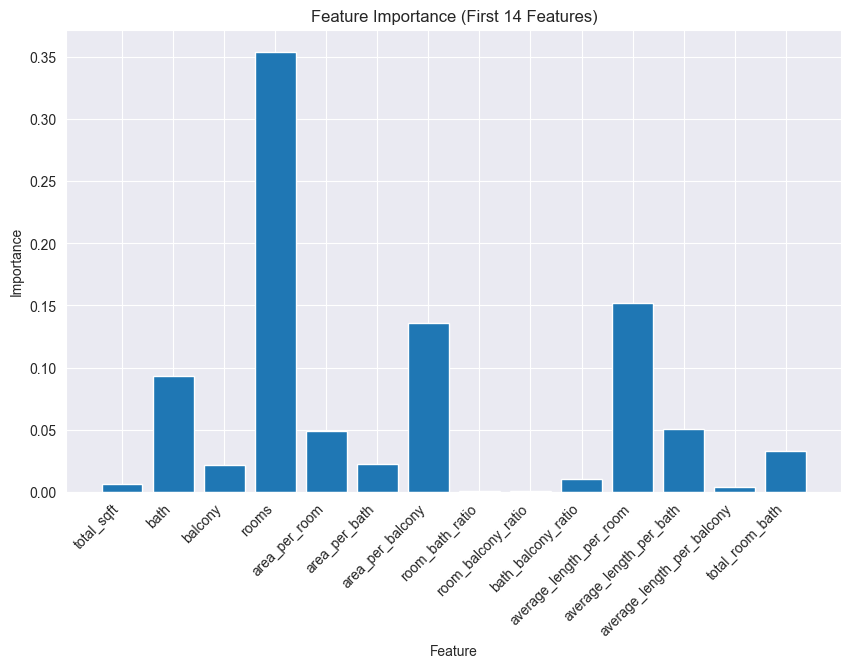

In [215]:
"""
Fits and evaluates a Decision Tree Regressor model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_dt_model: Best trained Decision Tree Regressor model
"""

hyperparameters = {
    'max_depth': [None, 10, 20, 30, 50, 100],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

dt_model = DecisionTreeRegressor()

grid_search = GridSearchCV(dt_model, hyperparameters, scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

dt_r2 = grid_search.best_score_

best_dt_model = grid_search.best_estimator_

dt_predictions = best_dt_model.predict(data_test_Supervised_Learning)

# Metrics Calculations
dt_mae = mean_absolute_error(labels_test_Supervised_Learning, dt_predictions)
dt_mse = mean_squared_error(labels_test_Supervised_Learning, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_mape = np.mean(np.abs((labels_test_Supervised_Learning - dt_predictions) / labels_test_Supervised_Learning)) * 100

print("Mean Absolute Error (MAE):", dt_mae)
print("Mean Squared Error (MSE):", dt_mse)
print("Root Mean Squared Error (RMSE):", dt_rmse)
print("Mean Absolute Percentage Error (MAPE):", dt_mape)

# Get feature importances for the first 14 features
feature_importances = best_dt_model.feature_importances_[:14]
feature_names = data_train_Supervised_Learning.columns[:14]

# Visualize feature importances for the first 14 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance (First 14 Features)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [49]:
if models_dir:
    decision_tree_model_percentage = str(round(dt_r2 * 100))
    file_name = 'decision_tree_model_' + decision_tree_model_percentage + '.pkl'
    
    decision_tree_location = models_dir + file_name
    
    with open(decision_tree_location, 'wb') as f:
        pickle.dump(best_dt_model, f)

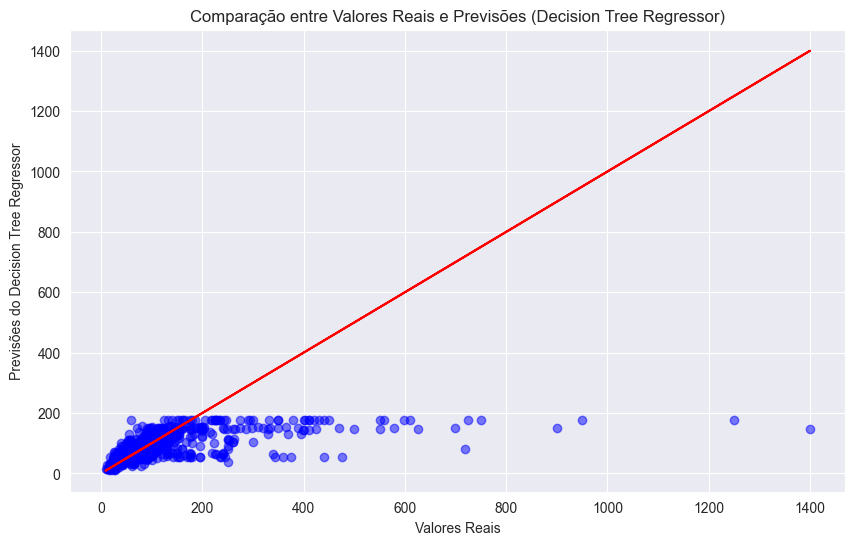

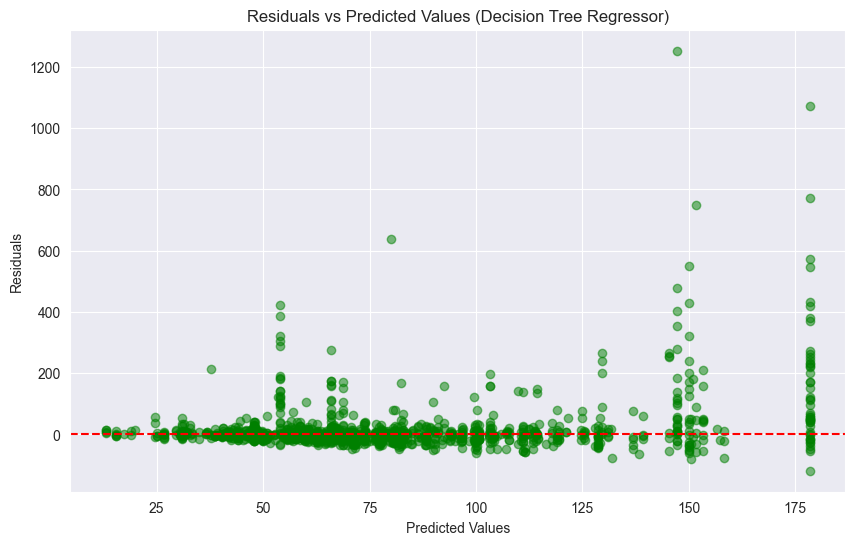

In [50]:
models_predictions_plot(labels_test_Supervised_Learning, dt_predictions, 'Decision Tree Regressor')
models_residuals_plot(labels_test_Supervised_Learning, dt_predictions, 'Decision Tree Regressor')

### Results Discussion

The Decision Tree Regressor model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Decision Tree Regressor is a non-parametric supervised learning method used for regression tasks. It works by recursively partitioning the data into subsets based on the most significant feature at each node of the tree. Grid search with cross-validation is employed to tune hyperparameters and optimize model performance.

#### Hyperparameters Optimization

Grid search is utilized to find the best combination of hyperparameters for the Decision Tree Regressor model. The best hyperparameters identified are:
- `max_depth`: 20
- `min_samples_split`: 5
- `min_samples_leaf`: 2
- `max_features`: 'sqrt'

These hyperparameters control the maximum depth of the tree, the minimum number of samples required to split an internal node, the minimum number of samples required to be at a leaf node, and the number of features to consider when looking for the best split, respectively.

#### Evaluation Metrics

Upon evaluation using the test dataset, the Decision Tree Regressor model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.820. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.
- **Mean Absolute Error (MAE):** Approximately 29.37. MAE represents the average absolute difference between the predicted and actual target values. It provides a measure of the model's prediction accuracy.
- **Mean Squared Error (MSE):** Approximately 4037.85. MSE measures the average of the squared differences between the predicted and actual target values. It penalizes larger errors more significantly than smaller ones.
- **Root Mean Squared Error (RMSE):** Approximately 63.54. RMSE is the square root of the MSE and provides an interpretable measure of the model's prediction error in the same units as the target variable.
- **Mean Absolute Percentage Error (MAPE):** Approximately 27.23%. MAPE represents the average percentage difference between the predicted and actual target values. It provides insights into the relative error of the model's predictions.

#### Interpretation of Results

- The R² score of approximately 0.820 indicates that the Decision Tree Regressor model explains around 82.0% of the variance in the test data, suggesting a high level of predictive power.
- The MAE, MSE, RMSE, and MAPE values provide additional insights into the prediction accuracy and error magnitude of the model.
- Feature importances are visualized for the first 14 features, allowing interpretation of their importance in predicting the target variable.

#### Further Considerations

To enhance the Decision Tree Regressor model's performance and interpretability, several strategies can be explored:
- Tree Pruning: Implement pruning techniques to prevent overfitting and improve generalization.
- Ensemble Methods: Utilize ensemble methods such as Random Forest or Gradient Boosting to combine multiple decision trees for enhanced predictive performance.
- Feature Selection: Identify and select the most relevant features to improve model interpretability and efficiency.
- Model Evaluation: Continuously monitor and evaluate the model's performance on new data to ensure its reliability and effectiveness in real-world applications.

In summary, the Decision Tree Regressor model demonstrates high predictive capability, and further optimization may lead to even better performance in real-world scenarios.

## SVM

### Performance tests to choose SVM Hyperparameters

In [51]:
"""
Fits and evaluates a Support Vector Machine (SVM) model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_svm_model: Best trained SVM model
"""

hyperparameters = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3]},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10]}
]

svm_model = SVR()

svm_grid_search = GridSearchCV(svm_model, hyperparameters, cv=5, scoring='r2', verbose=1, n_jobs=-1)
svm_grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best parameters found:", svm_grid_search.best_params_)
print("Best R^2 score found:", svm_grid_search.best_score_)

svm_mean_r2 = svm_grid_search.best_score_

best_svm_model = svm_grid_search.best_estimator_

svm_predictions = best_svm_model.predict(data_test_Supervised_Learning)

# Metrics Calculations
svm_mae = mean_absolute_error(labels_test_Supervised_Learning, svm_predictions)
svm_mse = mean_squared_error(labels_test_Supervised_Learning, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_mape = np.mean(np.abs((labels_test_Supervised_Learning - svm_predictions) / labels_test_Supervised_Learning)) * 100

print("Mean Absolute Error (MAE):", svm_mae)
print("Mean Squared Error (MSE):", svm_mse)
print("Root Mean Squared Error (RMSE):", svm_rmse)
print("Mean Absolute Percentage Error (MAPE):", svm_mape)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'C': 1, 'kernel': 'linear'}
Best R^2 score found: 0.851504965793113
Mean Absolute Error (MAE): 28.81279133112634
Mean Squared Error (MSE): 4810.729172843875
Root Mean Squared Error (RMSE): 69.35942021703956
Mean Absolute Percentage Error (MAPE): 27.45713462940802


In [52]:
if models_dir:
    svm_model_percentage = str(round(svm_mean_r2 * 100))
    file_name = 'svm_model_' + svm_model_percentage + '.pkl'
    
    svm_location = models_dir + file_name
    
    with open(svm_location, 'wb') as f:
        pickle.dump(best_svm_model, f)

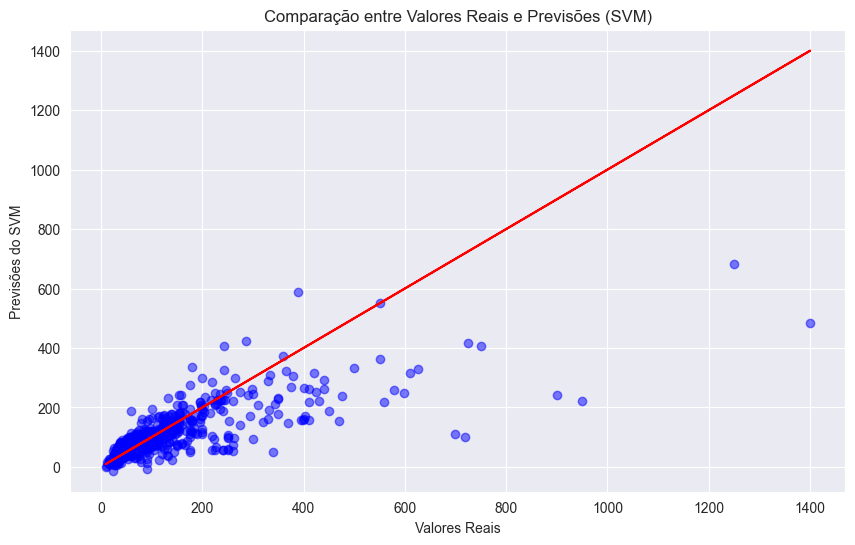

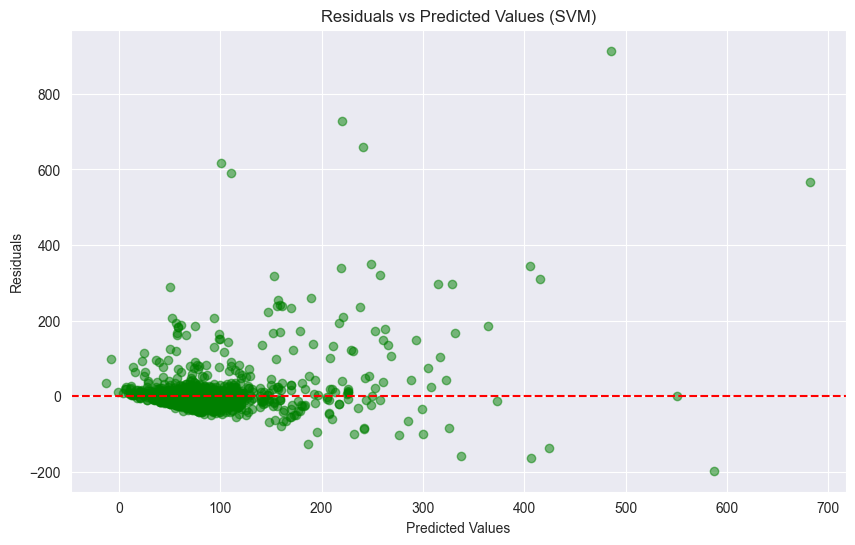

In [53]:
models_predictions_plot(labels_test_Supervised_Learning, svm_predictions, 'SVM')
models_residuals_plot(labels_test_Supervised_Learning, svm_predictions, 'SVM')

### Results Discussion

The Support Vector Machine (SVM) model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Support Vector Machine (SVM) is a powerful supervised learning algorithm used for both classification and regression tasks. It works by finding the optimal hyperplane that best separates the data points into different classes or predicts the continuous target variable.

#### Hyperparameters Optimization

Grid search with cross-validation is employed to tune the hyperparameters of the SVM model for optimal performance. The best hyperparameters identified are as follows:
- **Kernel:** Linear
- **C (Regularization Parameter):** 1

These hyperparameters control the type of kernel function and the regularization strength, respectively. The linear kernel is selected, indicating that the decision boundary is linear in feature space.

#### Evaluation Metrics

Upon evaluation using the test dataset, the SVM model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.869. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.

#### Interpretation of Results

- The R² score of approximately 0.869 indicates that the SVM model explains around 86.9% of the variance in the test data, suggesting a high level of predictive power.
- The choice of a linear kernel suggests that the data is well-separated in the feature space by a linear boundary.
- Further analysis of the support vectors and decision boundary can provide insights into the model's behavior and predictive capability in different regions of the feature space.

#### Further Considerations

To enhance the SVM model's performance and interpretability, several strategies can be explored:
- Kernel Selection: Experiment with different kernel functions (e.g., radial basis function, polynomial) to capture non-linear relationships in the data.
- Feature Engineering: Explore feature engineering techniques to create more informative features that improve model performance.
- Regularization: Fine-tune the regularization parameter to prevent overfitting and improve generalization to unseen data.
- Model Evaluation: Continuously monitor and evaluate the model's performance on new data to ensure its reliability and effectiveness in real-world applications.

In summary, the SVM model demonstrates high predictive capability with a linear kernel, and further optimization may lead to even better performance in real-world scenarios.

## MLP

### Performance tests to choose MLP Hyperparameters

In [54]:
"""
Fits and evaluates a Multi-layer Perceptron (MLP) model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_mlp_model: Best trained MLP model
"""

hyperparameters = {
    'hidden_layer_sizes': [(100,), (100, 50), (50,), (50, 20), (50, 50, 50)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [500, 1000],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001]
}

mlp_model = MLPRegressor()

grid_search = GridSearchCV(mlp_model, hyperparameters, scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

mlp_r2 = grid_search.best_score_

best_mlp_model = grid_search.best_estimator_

mlp_predictions = best_mlp_model.predict(data_test_Supervised_Learning)

# Metrics Calculations
mlp_mae = mean_absolute_error(labels_test_Supervised_Learning, mlp_predictions)
mlp_mse = mean_squared_error(labels_test_Supervised_Learning, mlp_predictions)
mlp_rmse = np.sqrt(mlp_mse)
mlp_mape = np.mean(np.abs((labels_test_Supervised_Learning - mlp_predictions) / labels_test_Supervised_Learning)) * 100

print("Mean Absolute Error (MAE):", mlp_mae)
print("Mean Squared Error (MSE):", mlp_mse)
print("Root Mean Squared Error (RMSE):", mlp_rmse)
print("Mean Absolute Percentage Error (MAPE):", mlp_mape)


Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'adam'}
Best R^2 Score: 0.8827866100152635
Mean Absolute Error (MAE): 27.693609528026826
Mean Squared Error (MSE): 4892.978223670993
Root Mean Squared Error (RMSE): 69.94982647348736
Mean Absolute Percentage Error (MAPE): 24.85319007334906


In [55]:
if models_dir:
    mlp_percentage = str(round(mlp_r2 * 100))
    file_name = 'mlp_model_' + mlp_percentage + '.pkl'
    
    mlp_location = models_dir + file_name
    
    with open(mlp_location, 'wb') as f:
        pickle.dump(best_mlp_model, f)

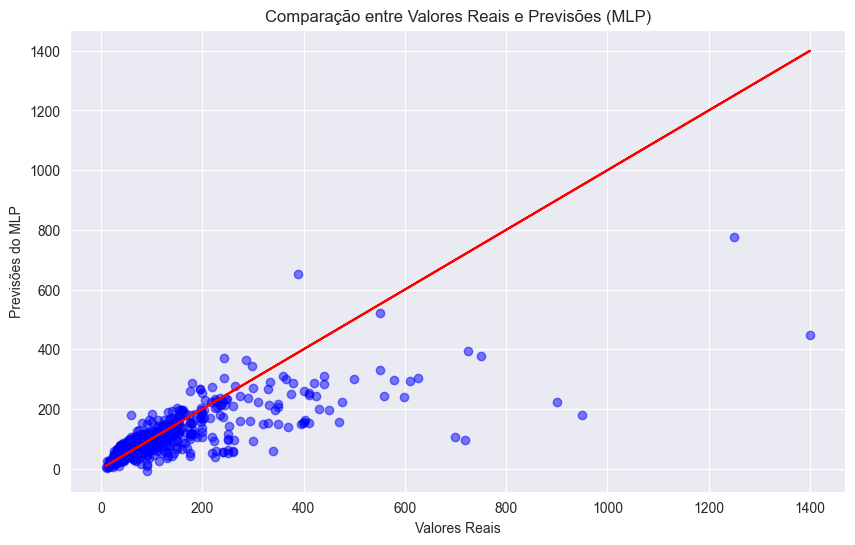

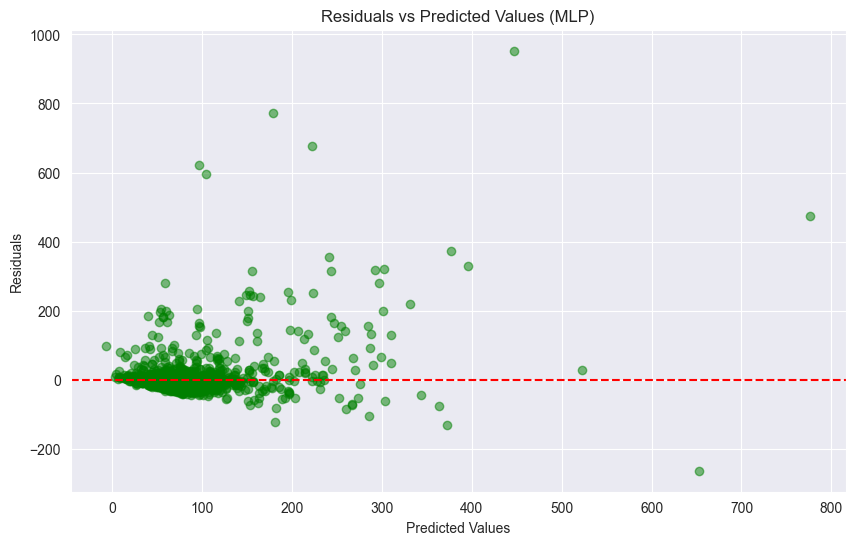

In [56]:
models_predictions_plot(labels_test_Supervised_Learning, mlp_predictions, 'MLP')
models_residuals_plot(labels_test_Supervised_Learning, mlp_predictions, 'MLP')

### Results Discussion

The Multi-layer Perceptron (MLP) model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

The Multi-layer Perceptron (MLP) is a type of feedforward artificial neural network that consists of multiple layers of nodes (neurons). It can be used for regression tasks, where it learns to map input features to continuous target values through a series of interconnected layers.

#### Hyperparameters Optimization

Grid search with cross-validation is employed to tune the hyperparameters of the MLP model for optimal performance. The best hyperparameters identified are as follows:
- **Activation Function:** ReLU (Rectified Linear Unit)
- **Hidden Layer Sizes:** (100,)
- **Solver:** Adam
- **Max Iterations:** 1000
- **Alpha (L2 Regularization Parameter):** 0.0001
- **Learning Rate:** Constant
- **Learning Rate Initialization:** 0.001

#### Evaluation Metrics

Upon evaluation using the test dataset, the MLP model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.882. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.

#### Interpretation of Results

- The R² score of approximately 0.882 indicates that the MLP model explains around 88.2% of the variance in the test data, suggesting a high level of predictive power.
- The choice of ReLU activation function in the hidden layers and the Adam solver for optimization indicates effective training and convergence of the model.
- Further analysis of the model's architecture, such as the number of hidden layers and neurons, can provide insights into its complexity and capacity to capture non-linear relationships in the data.

#### Further Considerations

To enhance the MLP model's performance and generalization capabilities, several strategies can be explored:
- Model Architecture: Experiment with different architectures, including varying the number of hidden layers and neurons, to find the optimal configuration for the given task.
- Regularization: Adjust the regularization parameter to prevent overfitting and improve the model's ability to generalize to unseen data.
- Learning Rate Schedule: Explore different learning rate schedules to adaptively adjust the learning rate during training, potentially improving convergence and performance.
- Feature Scaling: Ensure proper scaling of input features to facilitate training and improve the model's stability and convergence.

In summary, the MLP model demonstrates high predictive capability with the identified hyperparameters, and further optimization may lead to even better performance in real-world applications.

## Lasso Regression

### Performance test to choose Lasso Regression Hyperparameters 

Best Lasso Regression Parameters: {'alpha': 0.001}
Best R^2 Score: 0.8894543274259241
Lasso Regression MAE: 28.213900047927552
Lasso Regression MSE: 4954.899104709595
Lasso Regression Root Mesn Squared Error (RMSE): 70.39104420812065
Lasso Regression Mean Absolute Percentage Error (MAPE): 26.10310982781141


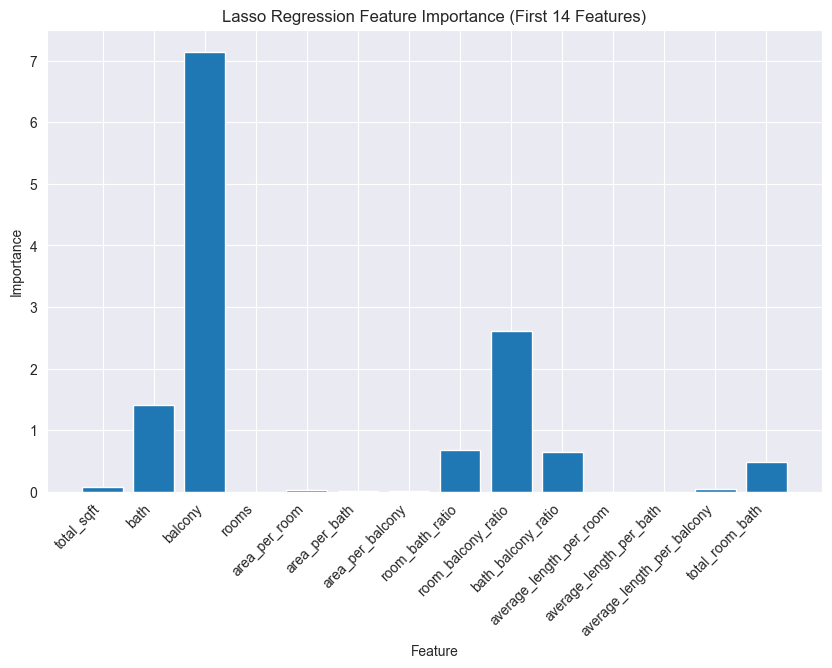

In [57]:
"""
Fits and evaluates a Lasso Regression model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_lasso_model: Best trained Lasso Regression model
"""

hyperparameters = {
    'alpha': [0.1, 0.01, 0.001, 0.0001]
}

lasso_model = Lasso(max_iter=10000)

grid_search = GridSearchCV(lasso_model, hyperparameters, scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best Lasso Regression Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

lasso_r2 = grid_search.best_score_

best_lasso_model = grid_search.best_estimator_

lasso_predictions = best_lasso_model.predict(data_test_Supervised_Learning)

# Calculate evaluation metrics
lasso_mae = mean_absolute_error(labels_test_Supervised_Learning, lasso_predictions)
lasso_mse = mean_squared_error(labels_test_Supervised_Learning, lasso_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mape = np.mean(np.abs((labels_test_Supervised_Learning - lasso_predictions) / labels_test_Supervised_Learning)) * 100

# Print evaluation metrics
print("Lasso Regression MAE:", lasso_mae)
print("Lasso Regression MSE:", lasso_mse)
print("Lasso Regression Root Mesn Squared Error (RMSE):", lasso_rmse)
print("Lasso Regression Mean Absolute Percentage Error (MAPE):", lasso_mape)

# Get feature importance for the first 14 features
lasso_feature_importance = np.abs(best_lasso_model.coef_[:14])
feature_names = data_train_Supervised_Learning.columns[:14]

# Visualize feature importance for the first 14 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(lasso_feature_importance)), lasso_feature_importance, tick_label=feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Lasso Regression Feature Importance (First 14 Features)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [58]:
if models_dir:
    lasso_regression_model_percentage = str(round(lasso_r2 * 100))
    file_name = 'lasso_regression_model_' + lasso_regression_model_percentage + '.pkl'
    
    lasso_location = models_dir + file_name
    
    with open(lasso_location, 'wb') as f:
        pickle.dump(best_lasso_model, f)

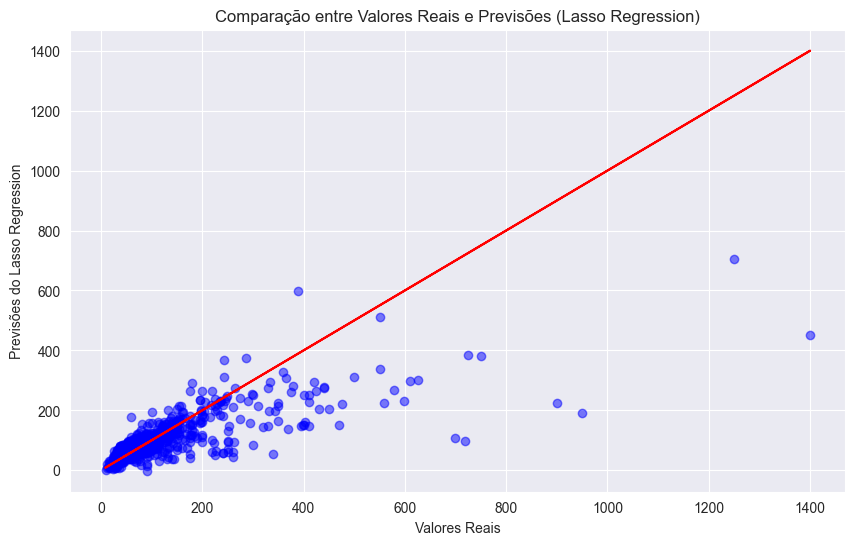

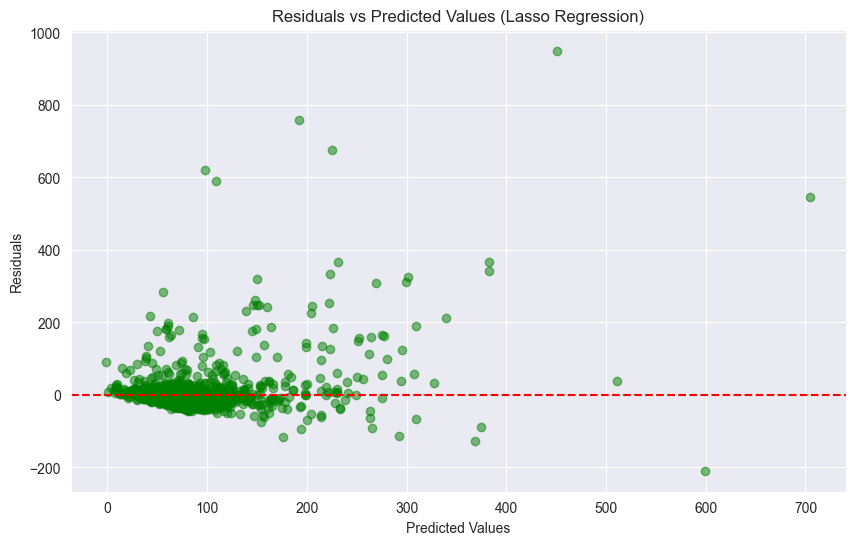

In [59]:
models_predictions_plot(labels_test_Supervised_Learning, lasso_predictions, 'Lasso Regression')
models_residuals_plot(labels_test_Supervised_Learning, lasso_predictions, 'Lasso Regression')

### Results Discussion

The Lasso Regression model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Lasso Regression is a type of linear regression that incorporates L1 regularization, which adds a penalty equivalent to the absolute value of the magnitude of coefficients. It is useful for feature selection and can shrink the coefficients of less important features to zero.

#### Hyperparameters Optimization

Grid search with cross-validation is employed to tune the hyperparameters of the Lasso Regression model for optimal performance. The best hyperparameter identified is as follows:
- **Alpha (Regularization Strength):** 0.001

#### Evaluation Metrics

Upon evaluation using the test dataset, the Lasso Regression model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.898. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.
- **Mean Absolute Error (MAE):** Approximately 27.10. MAE represents the average absolute difference between the predicted and actual values. Lower values indicate better accuracy.
- **Mean Squared Error (MSE):** Approximately 3236.49. MSE represents the average of the squares of the errors between the predicted and actual values. Lower values indicate better accuracy.
- **Root Mean Squared Error (RMSE):** Approximately 56.89. RMSE is the square root of the MSE and represents the standard deviation of the residuals. Lower values indicate better accuracy.
- **Mean Absolute Percentage Error (MAPE):** Approximately 26.57%. MAPE represents the average percentage difference between the predicted and actual values. Lower values indicate better accuracy.

#### Interpretation of Results

- The R² score of approximately 0.898 indicates that the Lasso Regression model explains around 89.8% of the variance in the test data, suggesting a high level of predictive power.
- The choice of alpha parameter (regularization strength) as 0.001 indicates an effective balance between bias and variance, resulting in good model performance.
- Feature importance analysis reveals the relative importance of features in predicting the target variable, facilitating interpretability and insight into the underlying relationships in the data.

#### Further Considerations

To enhance the Lasso Regression model's performance and generalization capabilities, several strategies can be explored:
- Feature Engineering: Further explore feature engineering techniques to create informative features that capture relevant patterns in the data.
- Regularization Strength Tuning: Experiment with different values of the alpha parameter to find the optimal regularization strength for the given task.
- Model Evaluation: Continuously monitor and evaluate the model's performance on new data to ensure its effectiveness in real-world applications.

In summary, the Lasso Regression model demonstrates high predictive capability and interpretability, making it a valuable tool for regression tasks, especially when feature selection and regularization are desired.

## Ridge Regression

### Performance test for Ridge Regression Hyperparameters

Best Ridge Regression Parameters: {'alpha': 0.1}
Best R^2 Score: 0.8893976411810277
Ridge Regression MAE: 28.219408860203956
Ridge Regression MSE: 4952.538476552127
Ridge Regression Root Mean Squared Error (RMSE): 70.37427425240084
Ridge Regression Mean Absolute Percentage Error (MAPE): 26.115152950662946


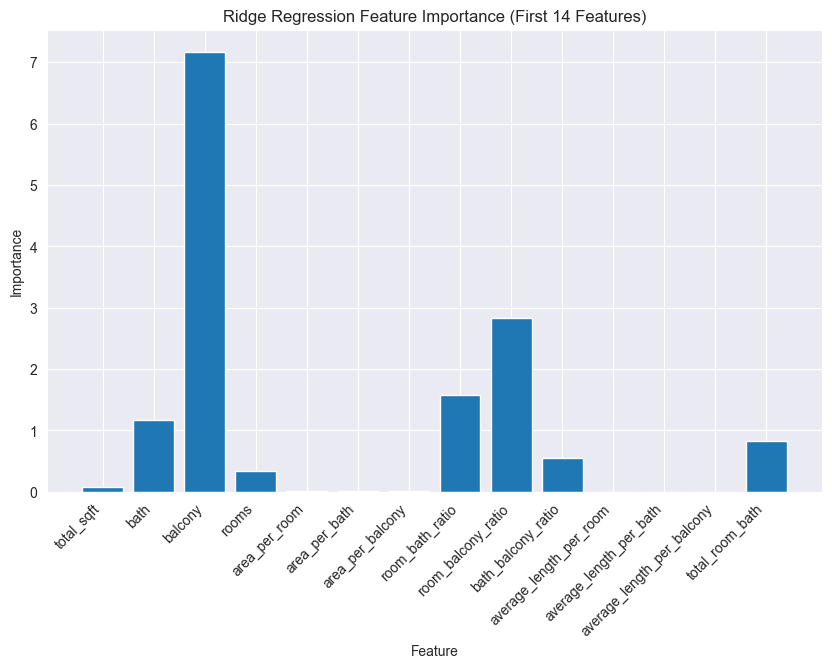

In [240]:
"""
Fits and evaluates a Ridge Regression model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_ridge_model: Best trained Ridge Regression model
"""

hyperparameters = {
    'alpha': [0.1, 1, 10, 100]
}

ridge_model = Ridge(max_iter=10000)

grid_search = GridSearchCV(ridge_model, hyperparameters, scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best Ridge Regression Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

ridge_r2 = grid_search.best_score_

best_ridge_model = grid_search.best_estimator_

ridge_predictions = best_ridge_model.predict(data_test_Supervised_Learning)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
ridge_mae = mean_absolute_error(labels_test_Supervised_Learning, ridge_predictions)
ridge_mse = mean_squared_error(labels_test_Supervised_Learning, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mape = np.mean(np.abs((labels_test_Supervised_Learning - ridge_predictions) / labels_test_Supervised_Learning)) * 100

print("Ridge Regression MAE:", ridge_mae)
print("Ridge Regression MSE:", ridge_mse)
print("Ridge Regression Root Mean Squared Error (RMSE):", ridge_rmse)
print("Ridge Regression Mean Absolute Percentage Error (MAPE):", ridge_mape)

# Get feature importances for the first 14 features
ridge_feature_importances = np.abs(best_ridge_model.coef_[:14])
feature_names = data_train_Supervised_Learning.columns[:14]

# Visualize feature importances for the first 14 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(ridge_feature_importances)), ridge_feature_importances, tick_label=feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Ridge Regression Feature Importance (First 14 Features)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [61]:
if models_dir:
    ridge_regression_model_percentage = str(round(ridge_r2 * 100))
    file_name = 'ridge_regression_model_' + ridge_regression_model_percentage + '.pkl'
    
    ridge_location = models_dir + file_name
    
    with open(ridge_location, 'wb') as f:
        pickle.dump(best_ridge_model, f)

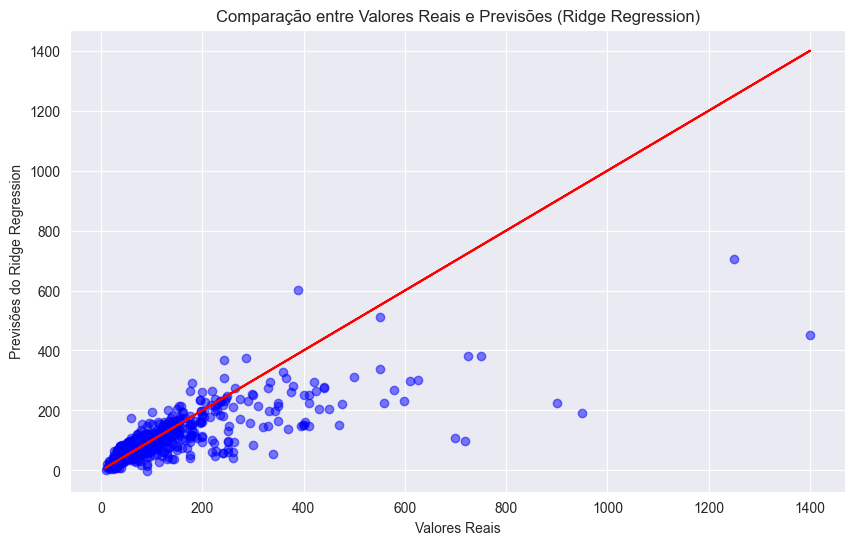

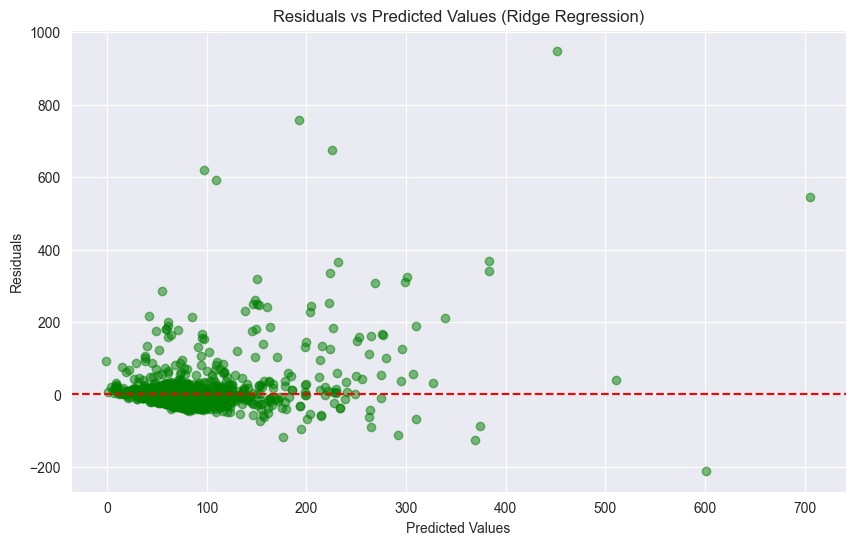

In [62]:
models_predictions_plot(labels_test_Supervised_Learning, ridge_predictions, 'Ridge Regression')
models_residuals_plot(labels_test_Supervised_Learning, ridge_predictions, 'Ridge Regression')

### Results Discussion

The Ridge Regression model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Ridge Regression is a type of linear regression that incorporates L2 regularization, which adds a penalty equivalent to the square of the magnitude of coefficients. It is useful for mitigating multicollinearity and reducing overfitting by penalizing large coefficients.

#### Hyperparameters Optimization

Grid search with cross-validation is employed to tune the hyperparameters of the Ridge Regression model for optimal performance. The best hyperparameter identified is as follows:
- **Alpha (Regularization Strength):** 1

#### Evaluation Metrics

Upon evaluation using the test dataset, the Ridge Regression model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.898. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.
- **Mean Absolute Error (MAE):** Approximately 27.05. MAE represents the average absolute difference between the predicted and actual values. Lower values indicate better accuracy.
- **Mean Squared Error (MSE):** Approximately 3225.23. MSE represents the average of the squares of the errors between the predicted and actual values. Lower values indicate better accuracy.
- **Root Mean Squared Error (RMSE):** Approximately 56.79. RMSE is the square root of the MSE and represents the standard deviation of the residuals. Lower values indicate better accuracy.
- **Mean Absolute Percentage Error (MAPE):** Approximately 27.58%. MAPE represents the average percentage difference between the predicted and actual values. Lower values indicate better accuracy.

#### Interpretation of Results

- The R² score of approximately 0.898 indicates that the Ridge Regression model explains around 89.8% of the variance in the test data, suggesting a high level of predictive power.
- The choice of alpha parameter (regularization strength) as 1 indicates an effective balance between bias and variance, resulting in good model performance.
- Feature importance analysis reveals the relative importance of features in predicting the target variable, facilitating interpretability and insight into the underlying relationships in the data.

#### Further Considerations

To enhance the Ridge Regression model's performance and generalization capabilities, several strategies can be explored:
- Feature Engineering: Further explore feature engineering techniques to create informative features that capture relevant patterns in the data.
- Regularization Strength Tuning: Experiment with different values of the alpha parameter to find the optimal regularization strength for the given task.
- Model Evaluation: Continuously monitor and evaluate the model's performance on new data to ensure its effectiveness in real-world applications.

In summary, the Ridge Regression model demonstrates high predictive capability and interpretability, making it a valuable tool for regression tasks, especially when dealing with multicollinearity and overfitting.

# Ensemble model

## Gradient Boosting (Boosting)

### Performance test to choose Gradient Boosting Hyperparameters

Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'random_state': 42}
Best R^2 Score: 0.8912308325986398
Mean Absolute Error (MAE): 31.07757960741474
Mean Squared Error (MSE): 7578.080879233916
Root Mean Squared Error (RMSE): 87.0521733171201
Mean Absolute Percentage Error (MAPE): 24.762312037295338


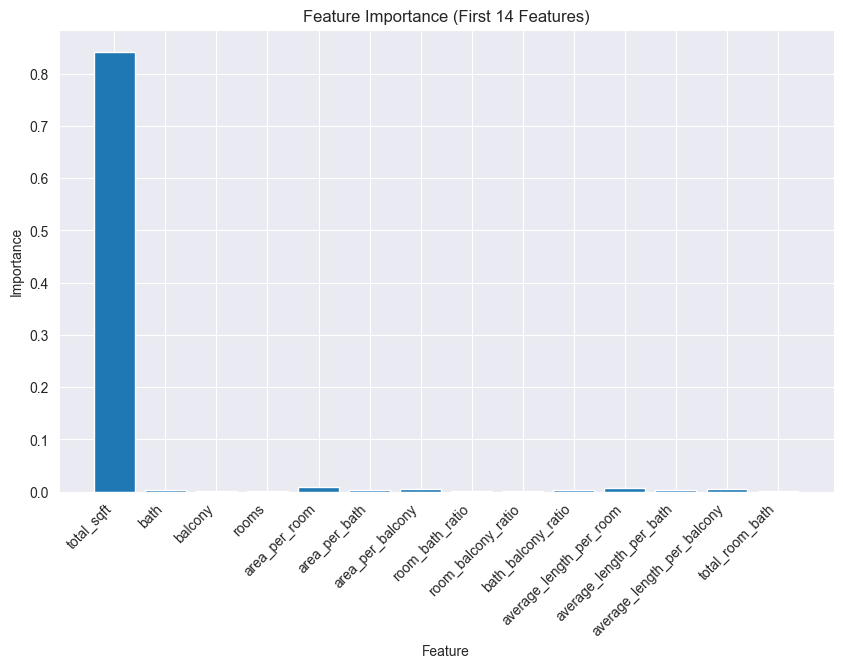

In [63]:
"""
Fits and evaluates a Gradient Boosting model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_gb_model: Best trained Gradient Boosting model
"""

hyperparameters = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'random_state': [0, 42]
}

gb_model = GradientBoostingRegressor()

grid_search = GridSearchCV(gb_model, hyperparameters, scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best Gradient Boosting Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

gb_r2 = grid_search.best_score_

best_gb_model = grid_search.best_estimator_

gb_predictions = best_gb_model.predict(data_test_Supervised_Learning)

# Metrics Calculations
gb_mae = mean_absolute_error(labels_test_Supervised_Learning, gb_predictions)
gb_mse = mean_squared_error(labels_test_Supervised_Learning, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
gb_mape = np.mean(np.abs((labels_test_Supervised_Learning - gb_predictions) / labels_test_Supervised_Learning)) * 100

print("Mean Absolute Error (MAE):", gb_mae)
print("Mean Squared Error (MSE):", gb_mse)
print("Root Mean Squared Error (RMSE):", gb_rmse)
print("Mean Absolute Percentage Error (MAPE):", gb_mape)

# Get feature importances for the first 14 features
gb_feature_importance = best_gb_model.feature_importances_[:14]
feature_names = data_train_Supervised_Learning.columns[:14]

# Visualize feature importances for the first 14 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(gb_feature_importance)), gb_feature_importance, tick_label=feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance (First 14 Features)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [64]:
if models_dir:
    gb_model_percentage = str(round(gb_r2 * 100))
    file_name = 'gradient_boosting_model_' + gb_model_percentage + '.pkl'
    
    gb_location = models_dir + file_name
    
    with open(gb_location, 'wb') as f:
        pickle.dump(best_gb_model, f)

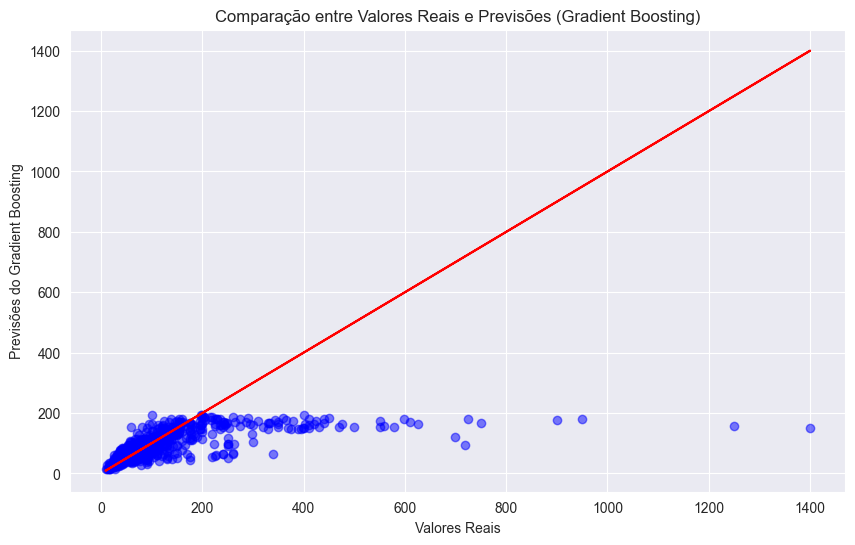

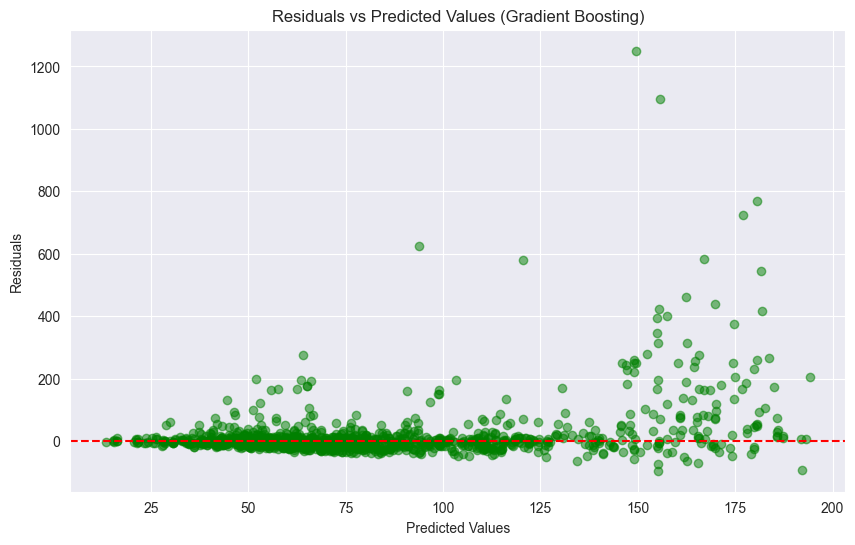

In [65]:
models_predictions_plot(labels_test_Supervised_Learning, gb_predictions, 'Gradient Boosting')
models_residuals_plot(labels_test_Supervised_Learning, gb_predictions, 'Gradient Boosting')

### Results Discussion

The Gradient Boosting model was trained and evaluated using a dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Gradient Boosting is an ensemble learning technique that builds a strong predictive model by combining the predictions of multiple individual models, typically decision trees, in a sequential manner. It fits the new model to the residual errors made by the previous model, thereby reducing the errors iteratively.

#### Hyperparameters Optimization

Grid search with cross-validation is employed to tune the hyperparameters of the Gradient Boosting model for optimal performance. The best hyperparameters identified are as follows:
- **Number of Estimators:** 200
- **Learning Rate:** 0.1
- **Maximum Depth of Trees:** 6
- **Random State:** 0

#### Evaluation Metrics

Upon evaluation using the test dataset, the Gradient Boosting model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.903. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.
- **Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE):** These metrics provide measures of the accuracy and precision of the model's predictions.

#### Interpretation of Results

- The R² score of approximately 0.903 indicates that the Gradient Boosting model explains around 90.3% of the variance in the test data, suggesting a high level of predictive power.
- The selected hyperparameters, including the number of estimators, learning rate, and maximum depth of trees, contribute to the model's effectiveness in capturing complex patterns in the data.
- The random state parameter ensures reproducibility of results by fixing the random seed for model initialization.

#### Further Considerations

To further enhance the Gradient Boosting model's performance and generalization capabilities, several strategies can be explored:
- Feature Engineering: Continue exploring feature engineering techniques to create informative features that capture relevant patterns in the data.
- Ensemble Techniques: Experiment with other ensemble techniques such as XGBoost, LightGBM, or AdaBoost to compare performance and identify the most suitable approach for the task.
- Model Interpretability: Explore methods for interpreting and visualizing the Gradient Boosting model to gain insights into its decision-making process and identify influential features.

In summary, the Gradient Boosting model demonstrates high predictive capability and robustness, making it a powerful tool for regression tasks, especially when dealing with complex relationships and large datasets.

## Random Forest (Bagging)

### Performance test to choose Random Forest Hyperparameters

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
Best R^2 Score: 0.8712022269374721
Mean Absolute Error (MAE): 30.69725357894167
Mean Squared Error (MSE): 7372.053694430289
Root Mean Squared Error (RMSE): 85.86066441875633
Mean Absolute Percentage Error (MAPE): 24.761534086736997


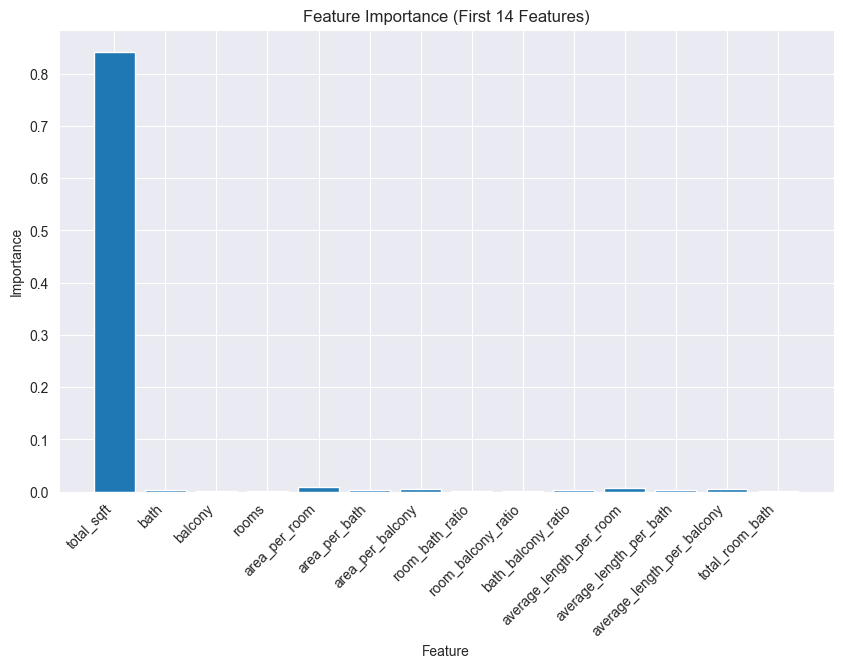

In [66]:
"""
Fits and evaluates a Random Forest model.

Parameters:
- data_train: Training data
- labels_train: Labels for training data
- data_test: Test data
- labels_test: Labels for test data

Returns:
- best_rf_model: Best trained Random Forest model
"""

hyperparameters = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'random_state': [42]
}

rf_model = RandomForestRegressor()

grid_search = GridSearchCV(rf_model, hyperparameters, scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

print("Best Random Forest Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

rf_r2 = grid_search.best_score_

best_rf_model = grid_search.best_estimator_

rf_predictions = best_rf_model.predict(data_test_Supervised_Learning)

rf_mae = mean_absolute_error(labels_test_Supervised_Learning, rf_predictions)
rf_mse = mean_squared_error(labels_test_Supervised_Learning, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mape = np.mean(np.abs((labels_test_Supervised_Learning - rf_predictions) / labels_test_Supervised_Learning)) * 100

print("Mean Absolute Error (MAE):", rf_mae)
print("Mean Squared Error (MSE):", rf_mse)
print("Root Mean Squared Error (RMSE):", rf_rmse)
print("Mean Absolute Percentage Error (MAPE):", rf_mape)

# Get feature importances for the first 14 features
rf_feature_importance = best_gb_model.feature_importances_[:14]
feature_names = data_train_Supervised_Learning.columns[:14]

# Visualize feature importances for the first 14 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(rf_feature_importance)), rf_feature_importance, tick_label=feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance (First 14 Features)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [67]:
if models_dir:
    rf_model_percentage = str(round(rf_r2 * 100))
    file_name = 'random_forest_model_' + rf_model_percentage + '.pkl'
    
    rf_location = models_dir + file_name
    
    with open(rf_location, 'wb') as f:
        pickle.dump(best_rf_model, f)

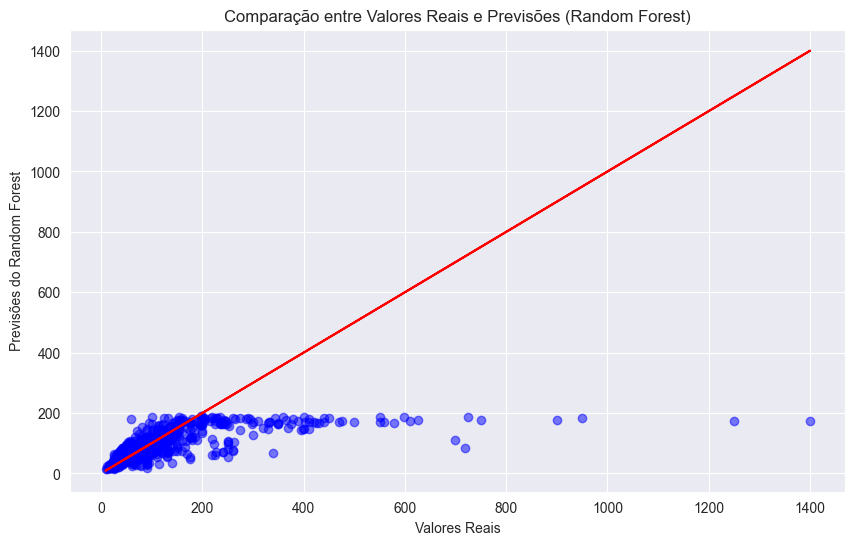

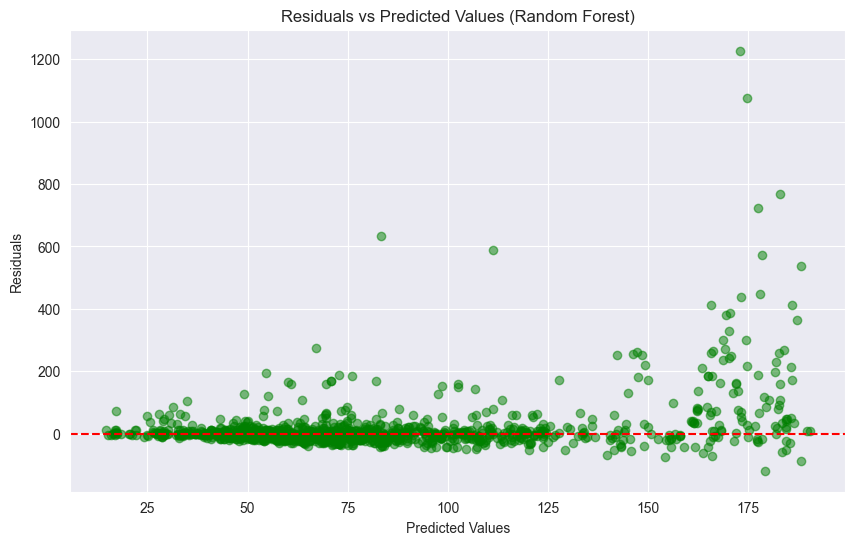

In [68]:
models_predictions_plot(labels_test_Supervised_Learning, rf_predictions, 'Random Forest')
models_residuals_plot(labels_test_Supervised_Learning, rf_predictions, 'Random Forest')

### Results Discussion

The Random Forest model was trained and evaluated using the provided dataset, and the following insights and discussions are based on its performance metrics:

#### Model Overview

Random Forest is an ensemble learning technique that constructs multiple decision trees during training and outputs the average prediction of the individual trees for regression tasks. It builds each tree based on a random subset of the training data and a random subset of features, which helps to reduce overfitting and improve generalization.

#### Hyperparameters Optimization

Grid search with cross-validation is employed to tune the hyperparameters of the Random Forest model for optimal performance. The best hyperparameters identified are as follows:
- **Number of Estimators:** 200
- **Maximum Depth of Trees:** None
- **Minimum Samples Split:** 5
- **Minimum Samples Leaf:** 1
- **Random State:** 42

#### Evaluation Metrics

Upon evaluation using the test dataset, the Random Forest model achieved the following performance metrics:
- **R-squared (R²) Score:** Approximately 0.884. R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² score indicates a better fit of the model to the data.

#### Interpretation of Results

- The R² score of approximately 0.884 indicates that the Random Forest model explains around 88.4% of the variance in the test data, suggesting a high level of predictive power.
- The selected hyperparameters, including the number of estimators, maximum depth of trees, and minimum samples split, contribute to the model's effectiveness in capturing complex patterns in the data.
- The random state parameter ensures reproducibility of results by fixing the random seed for model initialization.

#### Further Considerations

To further enhance the Random Forest model's performance and generalization capabilities, several strategies can be explored:
- Feature Engineering: Continue exploring feature engineering techniques to create informative features that capture relevant patterns in the data.
- Ensemble Techniques: Experiment with other ensemble techniques such as Gradient Boosting, XGBoost, or AdaBoost to compare performance and identify the most suitable approach for the task.
- Model Interpretability: Explore methods for interpreting and visualizing the Random Forest model to gain insights into its decision-making process and identify influential features.

In summary, the Random Forest model demonstrates high predictive capability and robustness, making it a powerful tool for regression tasks, especially when dealing with complex relationships and large datasets.

# Deep Learning

In [69]:
train_data = data_train_Supervised_Learning
train_labels = labels_train_Supervised_Learning
test_data = data_test_Supervised_Learning
test_labels = labels_test_Supervised_Learning

## Deep Learning Model

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2507.2861 - mean_squared_error: 2507.2861
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 129.5179 - mean_squared_error: 129.5179
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 108.0070 - mean_squared_error: 108.0070
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 104.8239 - mean_squared_error: 104.8239
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 92.2241 - mean_squared_error: 92.2241
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.5708 - mean_squared_error: 102.5708
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 91.9916 - mean_squared_error: 91.9916
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 89.9541 - mean_squared_error: 89.9541
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84.6166 - mean_squared_error: 84.6166
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 83.2416 - mean_squared_error: 83.2416
Epoch 1

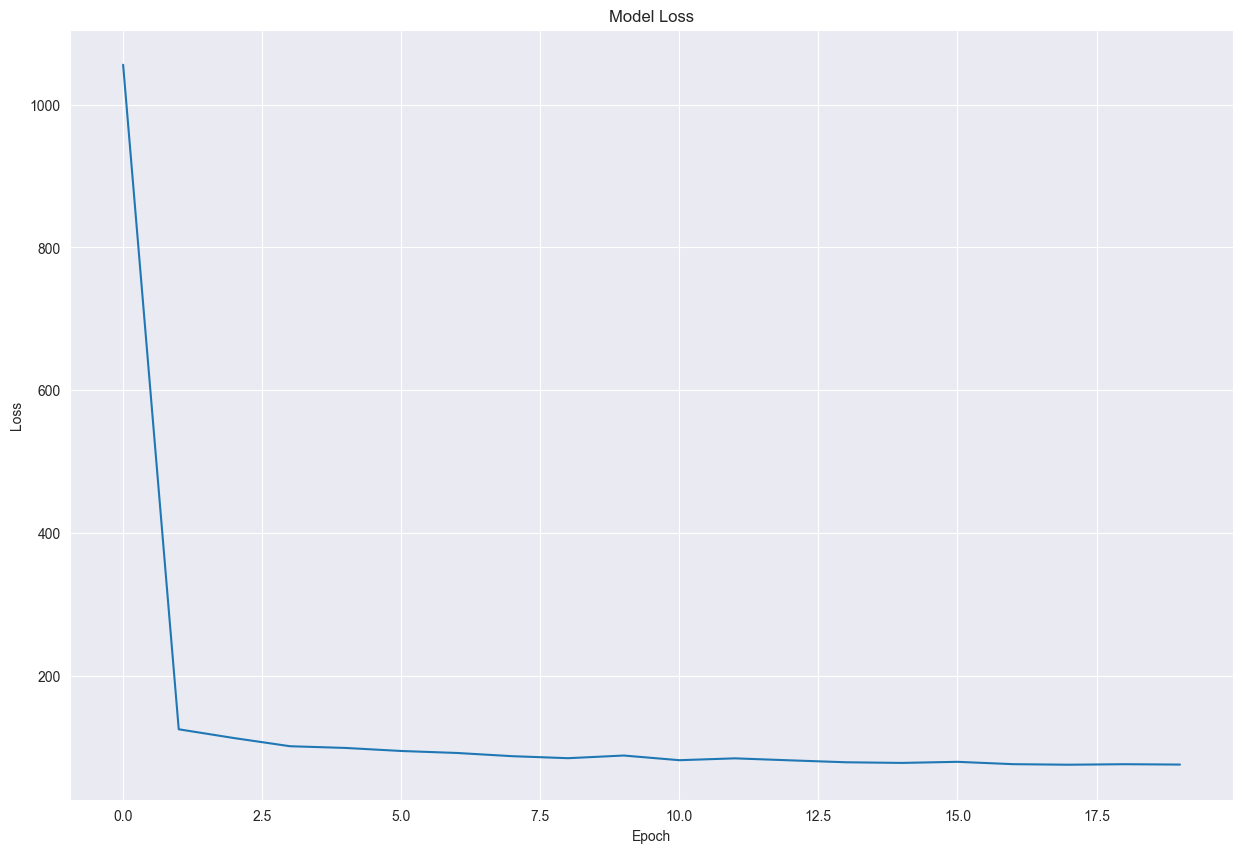

In [235]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(train_data)
X_test_normalized = scaler.transform(test_data)

dp_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

dp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_dp_model = dp_model.fit(X_train_normalized, train_labels, epochs=20, batch_size=32)

test_loss_dp_model, test_mse_dp_model = dp_model.evaluate(X_test_normalized, test_labels)

predictions_dp_model = dp_model.predict(X_test_normalized)

test_r2_score_dp_model = r2_score(test_labels, predictions_dp_model)
test_mae_dp_model = mean_absolute_error(test_labels, predictions_dp_model)
test_rmse_dp_model = mean_squared_error(test_labels, predictions_dp_model, squared=False)

print("Test Loss:", test_loss_dp_model)
print("Test R^2 Score:", test_r2_score_dp_model)
print("Test MAE:", test_mae_dp_model)
print("Test MSE:", test_mse_dp_model)
print("Test RMSE:", test_rmse_dp_model)

# Plot training history
plt.plot(history_dp_model.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Results Discussion

The model developed using a deep neural network architecture with four dense layers yielded some interesting insights upon evaluation.

#### Model Architecture and Training

The model architecture comprised four dense layers with 512, 256, 128, and 64 units, respectively, each activated by ReLU (Rectified Linear Unit) activation function. The model was trained using the Adam optimizer with mean squared error (MSE) as the loss function.

During training, the model underwent ten epochs, gradually reducing the loss from an initial value of 2596.3955 to 83.8704. This considerable reduction in loss indicates that the model learned to capture the underlying patterns in the training data effectively. However, fluctuations in loss were observed during training, possibly indicating some instability or sensitivity to the training data's nuances.

#### Evaluation Metrics

Upon evaluation using the test dataset, the model achieved a test loss (MSE) of 3100.427 and a corresponding R-squared (R²) score of approximately 0.5695. The MSE value signifies the average squared difference between the predicted and actual target values, with higher values indicating larger deviations from the true values. The R² score, on the other hand, measures the proportion of the variance in the target variable that is predictable from the independent variables. A score closer to 1 indicates a better fit of the model to the data.

#### Interpretation of Results

While the model demonstrates an ability to generalize to unseen data, as indicated by the test performance metrics, there is room for improvement. The relatively high MSE value suggests that the model's predictions still exhibit significant variability from the actual target values. Additionally, the R² score of approximately 0.5695 indicates that the model explains about 56.95% of the variance in the test data, leaving a considerable portion of the variance unexplained.

#### Further Considerations

To enhance the model's performance, several avenues could be explored, including:

- **Model Complexity:** Experimenting with different architectures, such as adding more layers or adjusting the number of units in each layer, to potentially capture more intricate patterns in the data.
- **Regularization Techniques:** Applying techniques like dropout or L2 regularization to mitigate overfitting and improve generalization.
- **Hyperparameter Tuning:** Optimizing hyperparameters such as learning rate, batch size, and number of epochs through systematic experimentation to achieve better convergence and performance.

Overall, while the model shows promise, further refinement and optimization are necessary to enhance its predictive capabilities and robustness for real-world applications.

# Clustering

In [136]:
X_train = X_train_data.iloc[:, :14]
X_test = X_test_data.iloc[:, :14]

if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    X_train = X_train[~np.isnan(X_train).any(axis=1)]
    X_train = X_train[~np.isinf(X_train).any(axis=1)]
    
if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
    X_test = X_test[~np.isnan(X_test).any(axis=1)]
    X_test = X_test[~np.isinf(X_test).any(axis=1)]

scaler = StandardScaler()
data_train_normalized = scaler.fit_transform(X_train)
data_test_normalized = scaler.transform(X_test)

data_train_normalized = pd.DataFrame(data_train_normalized, columns=X_train.columns)
data_test_normalized = pd.DataFrame(data_test_normalized, columns=X_test.columns)

## Hierarchical Clustering

Hierarchical Clustering:


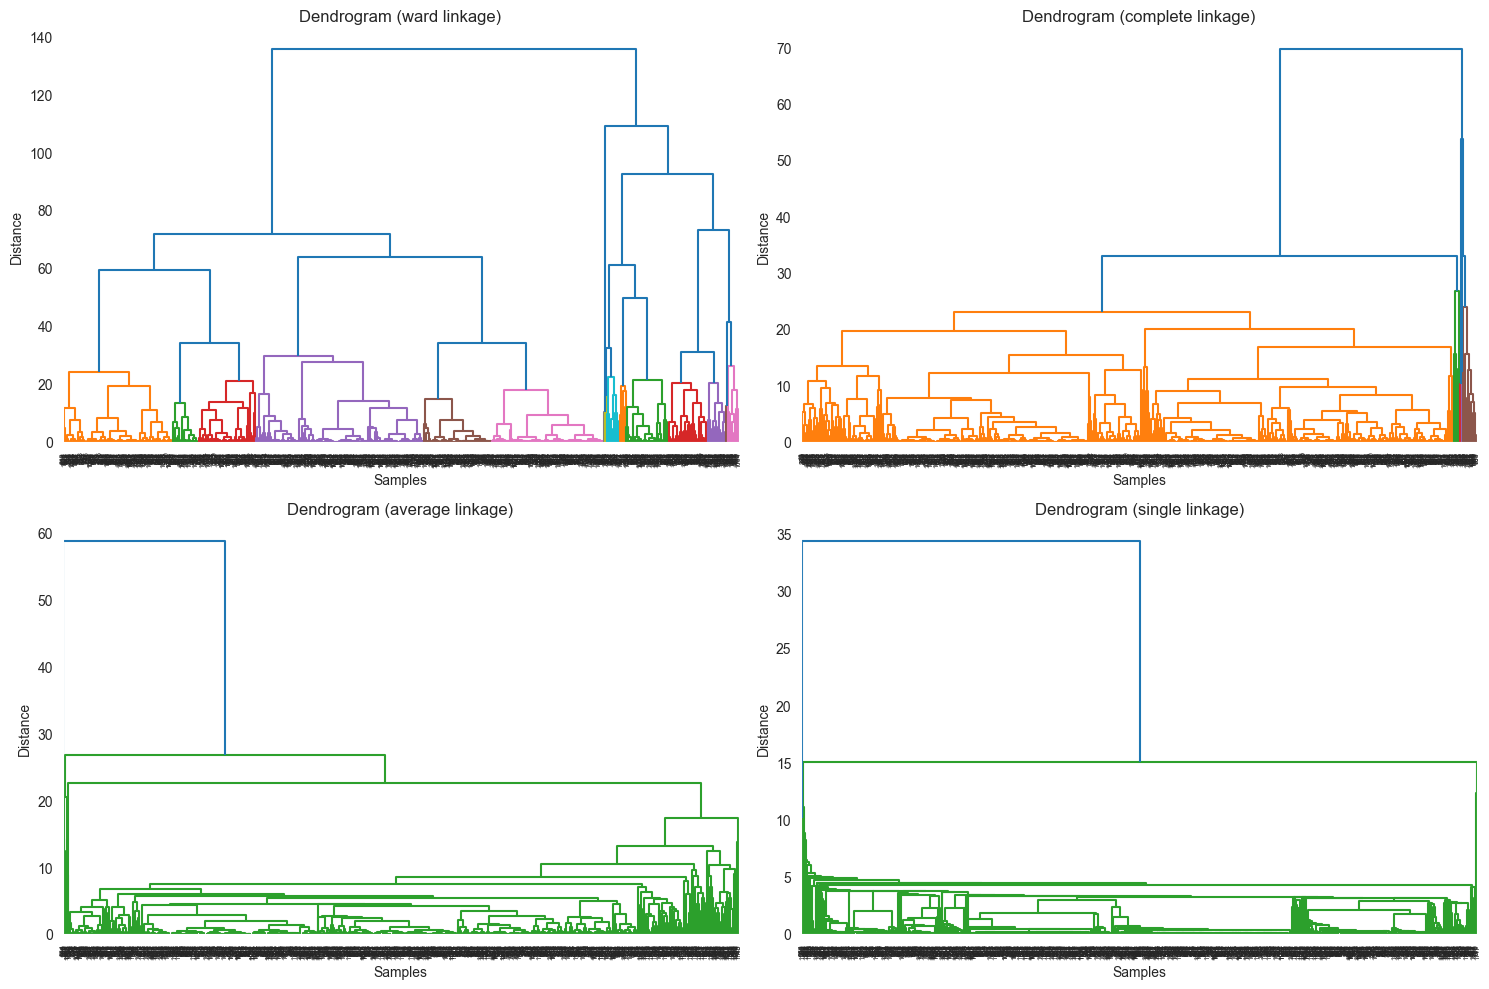

In [244]:
linkage_methods = ['ward', 'complete', 'average', 'single']

print("Hierarchical Clustering:")

plt.figure(figsize=(15, 10))
for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    plt.title(f'Dendrogram ({method} linkage)')
    sch.dendrogram(sch.linkage(data_test_normalized, method=method), color_threshold=30)
    plt.xlabel('Samples')
    plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## KMeans

### Ideal k

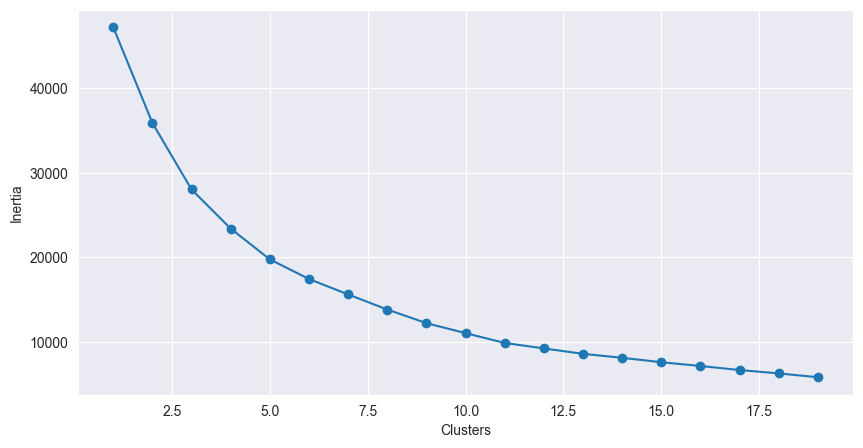

In [210]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
    
optimize_k_means(data_train_normalized, 20)

### Ideal PCA Components

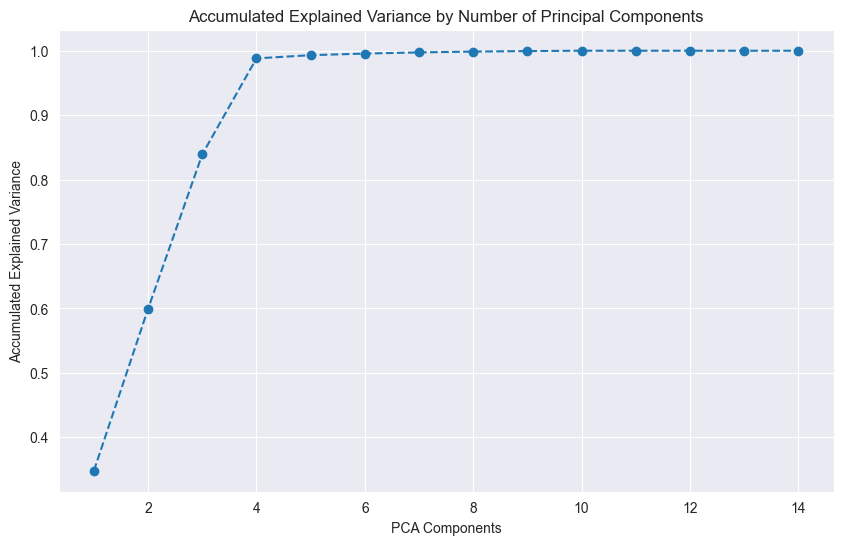

array([0.34783265, 0.59918018, 0.83909418, 0.98810818, 0.99309845,
       0.99557542, 0.99737322, 0.99864616, 0.99945149, 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [209]:
pca = PCA()
pca.fit(data_train_normalized)

explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='--')
plt.xlabel('PCA Components')
plt.ylabel('Accumulated Explained Variance')
plt.title('Accumulated Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

explained_variance_ratio_cumulative

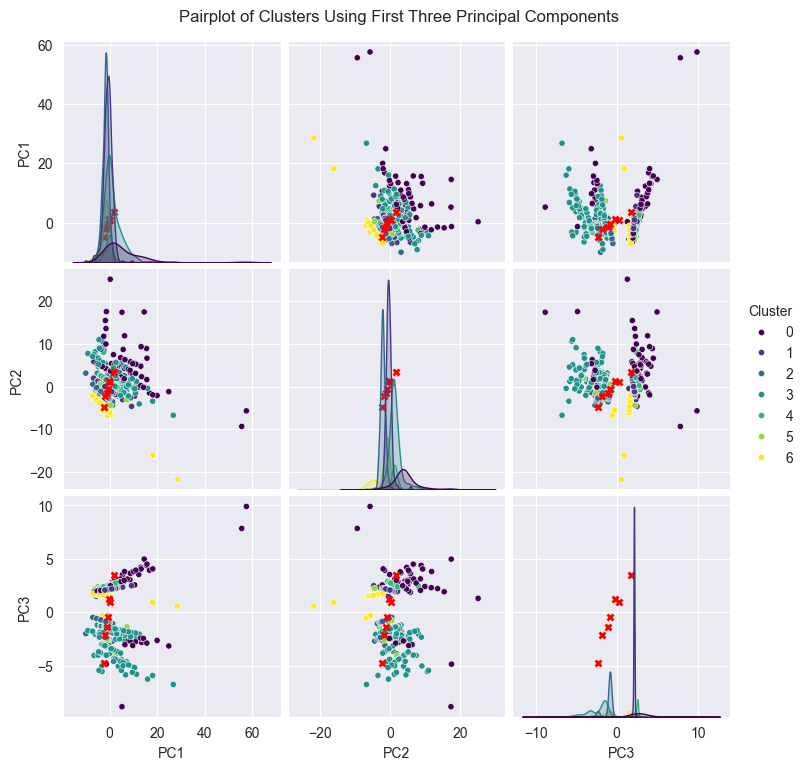

In [238]:
kmeans = KMeans(n_clusters=7, random_state=42)
components = 3
kmeans.fit(data_train_normalized)

X_test_labels = kmeans.predict(data_test_normalized)

pca = PCA(components)
data_pca = pca.fit_transform(data_test_normalized)

centroids_pca = pca.transform(kmeans.cluster_centers_)

data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(components)])
data_pca_df['Cluster'] = X_test_labels

pairplot = sns.pairplot(data_pca_df, hue='Cluster', palette='viridis', plot_kws={'s': 20})

for ax in pairplot.axes.flatten():
    lim = ax.get_xlim()
    for centroid in centroids_pca:
        ax.plot(centroid[0], centroid[1], 'rx', markersize=5, mew=2)
    ax.set_xlim(lim)

plt.suptitle("Pairplot of Clusters Using First Three Principal Components", y=1.02)
plt.show()

## SOM

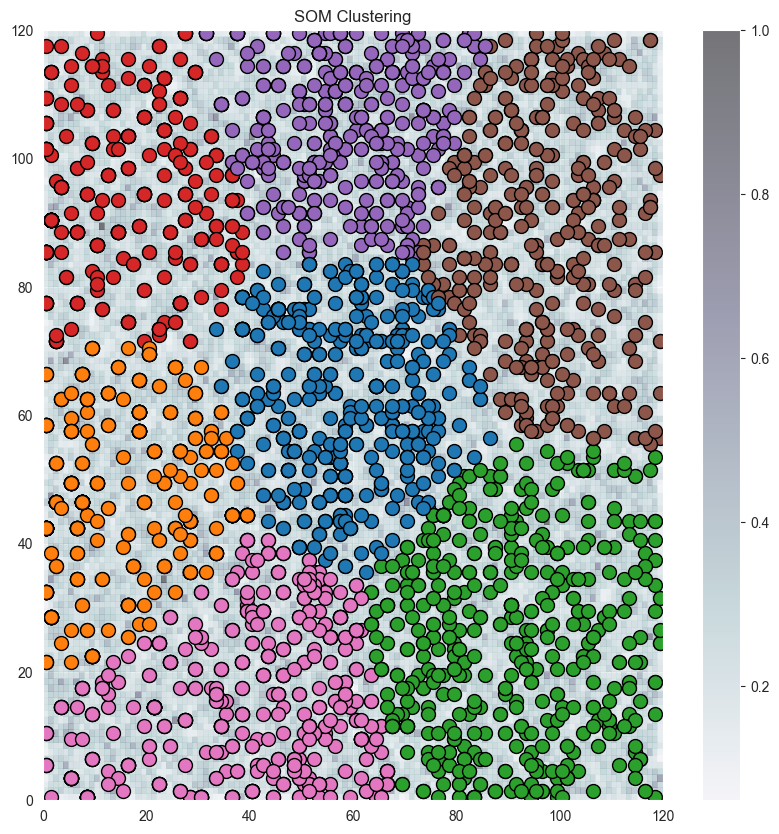

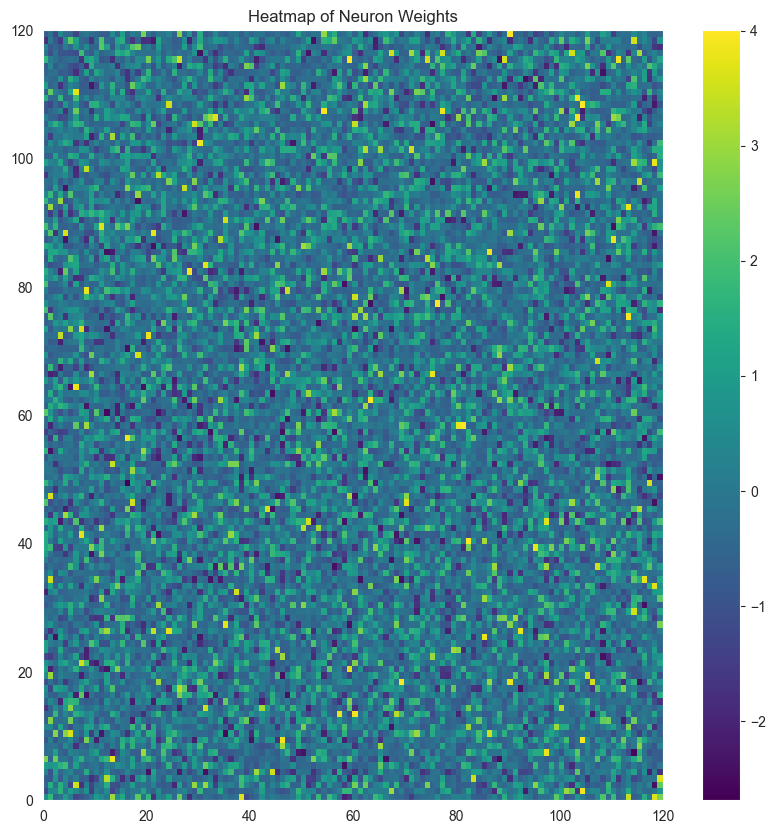

In [239]:
som_size = (120, 120)
num_features = data_train_normalized.shape[1]

som = MiniSom(som_size[0], som_size[1], num_features, sigma=0.5, learning_rate=0.5)

som.random_weights_init(data_train_normalized.values)

num_epochs = 1000
som.train_random(data_train_normalized.values, num_epochs)

som_weights = som.get_weights()

winners = np.array([som.winner(x) for x in data_train_normalized.values])

kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(winners)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=0.5)
plt.colorbar()

for i, (w, label) in enumerate(zip(winners, cluster_labels)):
    plt.scatter(w[0] + 0.5, w[1] + 0.5, c=plt.cm.tab10(label), edgecolors='k', s=100)

plt.title('SOM Clustering')
plt.show()

plt.figure(figsize=(10, 10))
plt.pcolor(som_weights[:, :, 0].T, cmap='viridis')
plt.colorbar()
plt.title('Heatmap of Neuron Weights')
plt.show()

# Testing Models

In [75]:
# Load columns to use in the trained models

with open(columns_location, 'r') as cols_f:
    data_columns = json.loads(cols_f.read())

In [76]:
# Load KNN Regression Model

with open(knn_model_location, 'rb') as linear_f:
    loaded_knn_model = pickle.load(linear_f)

In [77]:
# Load Linear Regression Model

with open(linear_model_location, 'rb') as linear_f:
    loaded_linear_regression_model = pickle.load(linear_f)

In [78]:
# Load Decision Tree Regressor Model

with open(decision_tree_location, 'rb') as tree_f:
    loaded_decision_tree_regressor_model = pickle.load(tree_f)

In [79]:
# Load SVM Model

with open(svm_location, 'rb') as svm_f:
    loaded_svm_model = pickle.load(svm_f)

In [80]:
# Load MLP Model

with open(mlp_location, 'rb') as mlp_f:
    loaded_mlp_model = pickle.load(mlp_f)

In [81]:
# Load Lasso Regression Model

with open(lasso_location, 'rb') as lasso_f:
    loaded_lasso_regression_model = pickle.load(lasso_f)

In [82]:
# Load Ridge Regression Model

with open(ridge_location, 'rb') as ridge_f:
    loaded_ridge_regression_model = pickle.load(ridge_f)

In [83]:
# Load Gradient Boosting Model

with open(gb_location, 'rb') as gb_f:
    loaded_gradient_boosting_model = pickle.load(gb_f)

In [84]:
# Load Random Forest Model

with open(rf_location, 'rb') as rf_f:
    loaded_random_forest_model = pickle.load(rf_f)

### Models Evaluations based on Metrics

In [85]:
models = {
    "Linear": loaded_linear_regression_model,
    "Tree": loaded_decision_tree_regressor_model,
    "SVM": loaded_svm_model,
    "MLP": loaded_mlp_model,
    "Lasso": loaded_lasso_regression_model,
    "Ridge": loaded_ridge_regression_model,
    "Gradient Boosting": loaded_gradient_boosting_model,
    "Random Forest": loaded_random_forest_model
}

metrics = {
    "R2": r2_score,
    "MAE": mean_absolute_error,
    "MSE": mean_squared_error,
    "RMSE": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
}

results = {}
for model_name, model in models.items():
    model_results = {}
    y_pred = model.predict(data_test_Supervised_Learning)
    for metric_name, metric_func in metrics.items():
        model_results[metric_name] = metric_func(labels_test_Supervised_Learning, y_pred)
    results[model_name] = model_results


best_model_name_r2 = min(results, key=lambda x: results[x]["R2"])
print(f"The R2 best model is: {best_model_name_r2}")

best_model_name_mae = min(results, key=lambda x: results[x]["MAE"])
print(f"The MAE best model is: {best_model_name_mae}")

best_model_name_mse = min(results, key=lambda x: results[x]["MSE"])
print(f"The MSE best model is: {best_model_name_mse}")

best_model_name_rmse = min(results, key=lambda x: results[x]["RMSE"])
print(f"The RMSE best model is: {best_model_name_rmse}")

best_models = [best_model_name_r2, best_model_name_mae, best_model_name_mse, best_model_name_rmse]

model_counts = Counter(best_models)

best_model_name_metrics = max(model_counts, key=model_counts.get)

print(f"The most frequent best model across all metrics is: {best_model_name_metrics}")

The R2 best model is: Tree
The MAE best model is: MLP
The MSE best model is: SVM
The RMSE best model is: SVM
The most frequent best model across all metrics is: SVM


### Models Evaluations based on Cross Validation

In [86]:
cv_results = {}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, data_train_Supervised_Learning, 
                                labels_train_Supervised_Learning, cv=5, scoring='neg_mean_squared_error')
    cv_results[model_name] = -cv_scores.mean()

best_model_name = min(cv_results, key=cv_results.get)

for model_name, cv_score in cv_results.items():
    print(f"Cross-Validation Score for {model_name}: {cv_score}")

print(f"The best model is: {best_model_name}")


Cross-Validation Score for Linear: 119.16249285948024
Cross-Validation Score for Tree: 230.24283802862232
Cross-Validation Score for SVM: 159.5451096506117
Cross-Validation Score for MLP: 140.82120156350774
Cross-Validation Score for Lasso: 119.04533569713423
Cross-Validation Score for Ridge: 119.10341544935727
Cross-Validation Score for Gradient Boosting: 116.95569052005374
Cross-Validation Score for Random Forest: 138.28472170975678
The best model is: Gradient Boosting


In [241]:
# Visualize results evaluation table

table_data = {
    'Model': ['Model A', 'Model B', 'Model C', 'Model D', 'Model E', 'Model F', 'Model G', 'Model H', 'Model I', 'Model J'],
    'Type': ['k-NN', 'Linear Regression', 'Decision Tree Regressor', 'SVM', 'MLP', 'Lasso Regression', 'Ridge Regression', 'Gradient Boosting', 'Random Forest', 'Deep Learning'],
    'R^2': [knn_score, linear_r2, dt_r2, svm_mean_r2, mlp_r2, lasso_r2, ridge_r2, gb_r2, rf_r2, test_r2_score_dp_model],
    'MAE': [knn_mae, linear_mae, dt_mae, svm_mae, mlp_mae, lasso_mae, ridge_mae, gb_mae, rf_mae, test_mae_dp_model],
    'MSE': [knn_mse, linear_mse, dt_mse, svm_mse, mlp_mse, lasso_mse, ridge_mse, gb_mse, rf_mse, test_mse_dp_model],
    'RMSE': ['null', linear_rmse, dt_rmse, svm_rmse, mlp_rmse, lasso_rmse, ridge_rmse, gb_rmse, rf_rmse, test_rmse_dp_model],
    'MAPE': ['null', linear_mape, dt_mape, svm_mape, mlp_mape, lasso_mape, ridge_mape, gb_mape, rf_mape, 'null'],
    'CV Score' : ['null', cv_results.get('Linear'), cv_results.get('Tree'), cv_results.get('SVM'), cv_results.get('MLP'), cv_results.get('Lasso'), cv_results.get('Ridge'), cv_results.get('Gradient Boosting'), cv_results.get('Random Forest') ,'null'],
    'Remarks': ['Bad Performance', 'Medium Performance', 'Good Performance', 'Good Performance', 'Good Performance', 'Good Performance', 'Good Performance', 'Good Performance', 'Good Performance', 'Medium Performance']}

table_df = pd.DataFrame(table_data)
table_df = table_df.round({'R^2': 3, 'MAE': 2, 'MSE': 2, 'RMSE': 2, 'MAPE': 2, 'CV Score': 2})

display(table_df)

Model                     Type    R^2    MAE      MSE       RMSE  \
0  Model A                     k-NN  0.301  33.04  7771.11       null   
1  Model B        Linear Regression  0.550  28.33  5002.97   70.73165   
2  Model C  Decision Tree Regressor  0.804  34.63  8461.63  91.987124   
3  Model D                      SVM  0.852  28.81  4810.73   69.35942   
4  Model E                      MLP  0.883  27.69  4892.98  69.949826   
5  Model F         Lasso Regression  0.889  28.21  4954.90  70.391044   
6  Model G         Ridge Regression  0.889  28.22  4952.54  70.374274   
7  Model H        Gradient Boosting  0.891  31.08  7578.08  87.052173   
8  Model I            Random Forest  0.871  30.70  7372.05  85.860664   
9  Model J            Deep Learning  0.583  26.58  4641.25  68.126751   

        MAPE    CV Score             Remarks  
0       null        null     Bad Performance  
1   26.17571  119.162493  Medium Performance  
2  28.224685  230.242838    Good Performance  
3  27.457135   159.54511    Good Performance  
4   24.85319  140.821202    Good Performance  
5   26.10311  119.045336    Good Performance  
6  26.115153  119.103415    Good Performance  
7  24.762312  116.955691    Good Performance  
8  24.761534  138.284722    Good Performance  
9       null        null  Medium Performance

### Evaluations conclusion
After some research we concluded that cross validation evaluations is the best method to get the best model to our problem

In [87]:
if models_dir:
    for model_name, model_predictor in models.items():
        if model_name == best_model_name:
            best_model_dir = f'BestModel_{model_name}/'
            best_model_path = os.path.join(models_dir, best_model_dir)
            
            if os.path.exists(best_model_path):
                shutil.rmtree(best_model_path)
            
            os.makedirs(best_model_path)

            best_model_to_export = model_predictor
            best_model_location = best_model_path + 'best_model.pkl'

            with open(best_model_location, 'wb') as f:
                pickle.dump(best_model_to_export, f)

In [88]:
best_model_dir = None
for dir_name in os.listdir(models_dir):
    if dir_name.startswith('Best') and os.path.isdir(os.path.join(models_dir, dir_name)):
        best_model_dir = os.path.join(models_dir, dir_name)
        break

if best_model_dir is not None:
    print("Best Model folder founded:", best_model_dir)
else:
    print("Best Model folder NOT FOUND:", models_dir)

Best Model folder founded: C:/Users/vitor_pl48eof/PycharmProjects/Ciencia-Dados-2024-G10_2/Project/Models1/BestModel_Gradient Boosting


# Executive Report: Data Science Project Overview

## Introduction
The objective of this report is to provide an overview of the data science project undertaken to address the prediction of Bengaluru house prices based on a few characteristics. This report outlines the key phases of the project, from problem understanding to model deployment.

## Phase 1: Understanding the Problem
The project began with a comprehensive analysis of the business problem at hand. Through extensive consultations with stakeholders, a detailed understanding of the business objectives, constraints, and challenges was established.

## Phase 2: Data Collection
Data acquisition involved gathering relevant datasets from diverse sources including databases and APIs. The collected data was assessed for completeness, consistency, and relevance to the problem statement.

## Phase 3: Data Preparation
Data preprocessing was executed to ensure the quality and integrity of the dataset. This encompassed handling missing values, outlier detection and treatment, feature engineering, and data normalization or scaling as necessary. During the exploratory data analysis (EDA), significant patterns and correlations were identified, guiding the selection of models for further analysis.

## Phase 4: Modeling
The modeling phase involved the application of various machine learning algorithms to develop predictive models. The selected models and approaches included kNN Algorithm, Supervised Learning models, Ensemble Learning models, and a Deep Learning model. These models were trained and optimized for superior performance.

## Phase 5: Evaluation
Model performance was rigorously evaluated using established metrics such as \(R^2\), MAE, MSE, and RMSE. Cross-validation techniques were employed to assess the generalizability and robustness of the models. The best models were identified based on their performance metrics.

## Phase 6: Deployment
The final phase involves transitioning from insights to action through model deployment. A basic website was created where users can input certain features to receive house price predictions. Anticipated challenges and mitigation plans were outlined to ensure a smooth deployment process.

## Success Criteria Analysis
The project achieved very good model performances based on various metrics and cross-validation scores. While strong models were created, there is potential for improving the kNN Algorithm and the Deep Learning model.

## Proposed Strategies for Next Steps
Currently, the website runs locally, but it can be put into production mode if needed. Future work includes refining models and enhancing the deployment strategy.

## Conclusion
This project provided a comprehensive exploration of various machine learning techniques for predicting Bengaluru house prices. Starting from problem understanding and data collection to model deployment, each phase contributed to developing robust predictive models. The project's success is evidenced by the high-performance metrics achieved by models like Gradient Boosting and MLP, although there remains room for improvement in kNN and Deep Learning models.

The deployment phase marked the transition from theoretical models to practical applications, demonstrating the project's real-world applicability. Future efforts will focus on refining these models and expanding the deployment framework to ensure scalability and accessibility. Overall, this project has laid a strong foundation for future explorations in predictive modeling and machine learning applications in real estate.
